# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import zipfile
import requests
import os
import pathlib
import numpy as np
import pathlib
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from urllib.parse import urlparse
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Tue May 23 14:01:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.50                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060         On | 00000000:01:00.0  On |                  N/A |
| N/A   82C    P8                6W /  N/A|    156MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_transformers_alice' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../input', 'alice_short_story')
train_file = os.listdir(dataset_dir)
print(train_file)

['alice.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 1243 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 128
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 2000

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### The Custom Dataset Class

In [10]:
class NLPDataset():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text_file = open(file_path)
        self.lines = self.text_file.read()
        self.enc = tiktoken.encoding_for_model("gpt2")
    
    def __len__(self):
        return len(self.file_paths)

    def get_data(self):
        final_vector = self.enc.encode(self.lines)
        return torch.tensor(final_vector[0::], dtype=torch.int32)

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([1536])
Number of unique tokens: 618


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 1383
Number of validation samples: 153


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

1383
153


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
def get_batch(split='train'):
    device_type = device
    data = dataset_train if split == 'train' else dataset_valid
    ix = torch.randint(len(data) - SEQUENCE_LENGTH, (BATCH_SIZE,))
    x = torch.stack([(data[i:i+SEQUENCE_LENGTH]) for i in ix])
    y = torch.stack([(data[i+1:i+1+SEQUENCE_LENGTH]) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [18]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Training Utilities

In [19]:
# Training function.
def train(model, dataset_train, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    bleu_score = 0
    counter = 0
    for i in tqdm(
        range(0, dataset_train.size(0), SEQUENCE_LENGTH), 
        total=int(dataset_train.size(0)/SEQUENCE_LENGTH)
    ):
        counter += 1
        inputs, labels = get_batch('train')
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs)
        
        labels = labels.contiguous().view(-1)
        outputs = outputs.view(-1, NUM_WORDS)
        # Calculate the loss.
        loss = criterion(
            outputs, 
            labels.type(torch.int64)
        )
        train_running_loss += loss.item()
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    return epoch_loss

# Validation function.
def validate(model, dataset_valid, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i in tqdm(
            range(0, dataset_valid.size(0), SEQUENCE_LENGTH), 
            total=int(dataset_valid.size(0)/SEQUENCE_LENGTH)
        ):
            counter += 1
            inputs, labels = get_batch()
            # Forward pass.
            outputs = model(inputs)
        
            labels = labels.contiguous().view(-1)
            # Calculate the loss.
            loss = criterion(
                outputs.view(-1, NUM_WORDS), 
                labels.type(torch.int64)
            )
            valid_running_loss += loss.item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    return epoch_loss

## Model

In [20]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
)

In [21]:
_ = model.to(device)

## Training

In [22]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropo

In [23]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, 
                             dataset_train, 
                             optimizer, 
                             criterion, 
                             device)
    valid_epoch_loss = validate(model, 
                                dataset_valid,  
                                criterion, 
                                device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 10.339447021484375
Validation loss: 9.101326942443848
--------------------------------------------------
[INFO]: Epoch 2 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 9.21936728737571
Validation loss: 8.538783550262451
--------------------------------------------------
[INFO]: Epoch 3 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 8.26836195859042
Validation loss: 8.016369819641113
--------------------------------------------------
[INFO]: Epoch 4 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 7.63187482140281
Validation loss: 6.924480676651001
--------------------------------------------------
[INFO]: Epoch 5 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.9552154107527295
Validation loss: 6.785462141036987
--------------------------------------------------
[INFO]: Epoch 6 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.583828449249268
Validation loss: 5.986090421676636
--------------------------------------------------
[INFO]: Epoch 7 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.152520049702037
Validation loss: 5.7767510414123535
--------------------------------------------------
[INFO]: Epoch 8 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.84924975308505
Validation loss: 5.6159937381744385
--------------------------------------------------
[INFO]: Epoch 9 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.905241099270907
Validation loss: 5.888704538345337
--------------------------------------------------
[INFO]: Epoch 10 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.753701340068471
Validation loss: 5.823184013366699
--------------------------------------------------
[INFO]: Epoch 11 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.686863552440297
Validation loss: 5.390508651733398
--------------------------------------------------
[INFO]: Epoch 12 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.666624892841686
Validation loss: 5.593735456466675
--------------------------------------------------
[INFO]: Epoch 13 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.548349640586159
Validation loss: 5.409763336181641
--------------------------------------------------
[INFO]: Epoch 14 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.522386117414995
Validation loss: 5.3591156005859375
--------------------------------------------------
[INFO]: Epoch 15 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.412910288030451
Validation loss: 5.5811991691589355
--------------------------------------------------
[INFO]: Epoch 16 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.573720238425515
Validation loss: 5.392744064331055
--------------------------------------------------
[INFO]: Epoch 17 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.591236201199618
Validation loss: 5.327239990234375
--------------------------------------------------
[INFO]: Epoch 18 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.5260211337696425
Validation loss: 5.698704242706299
--------------------------------------------------
[INFO]: Epoch 19 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.5203518000516025
Validation loss: 5.18932318687439
--------------------------------------------------
[INFO]: Epoch 20 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.456503304568204
Validation loss: 5.35326886177063
--------------------------------------------------
[INFO]: Epoch 21 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.451060338453813
Validation loss: 5.367975950241089
--------------------------------------------------
[INFO]: Epoch 22 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.589660167694092
Validation loss: 5.26279878616333
--------------------------------------------------
[INFO]: Epoch 23 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.441075975244695
Validation loss: 5.435431241989136
--------------------------------------------------
[INFO]: Epoch 24 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.485777984965932
Validation loss: 5.460921049118042
--------------------------------------------------
[INFO]: Epoch 25 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.442607706243342
Validation loss: 5.335904598236084
--------------------------------------------------
[INFO]: Epoch 26 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.461642395366322
Validation loss: 5.316067218780518
--------------------------------------------------
[INFO]: Epoch 27 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.461242589083585
Validation loss: 5.416343450546265
--------------------------------------------------
[INFO]: Epoch 28 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.442959438670766
Validation loss: 5.220747709274292
--------------------------------------------------
[INFO]: Epoch 29 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.445059863003817
Validation loss: 5.158660411834717
--------------------------------------------------
[INFO]: Epoch 30 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.406500772996382
Validation loss: 5.066815137863159
--------------------------------------------------
[INFO]: Epoch 31 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.252301996404475
Validation loss: 4.967510461807251
--------------------------------------------------
[INFO]: Epoch 32 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.183067321777344
Validation loss: 5.036187648773193
--------------------------------------------------
[INFO]: Epoch 33 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.083782022649592
Validation loss: 5.035339832305908
--------------------------------------------------
[INFO]: Epoch 34 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.149083614349365
Validation loss: 5.211938858032227
--------------------------------------------------
[INFO]: Epoch 35 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.114884549921209
Validation loss: 4.789130926132202
--------------------------------------------------
[INFO]: Epoch 36 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.0379532900723545
Validation loss: 4.528392791748047
--------------------------------------------------
[INFO]: Epoch 37 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.993165666406805
Validation loss: 4.3266026973724365
--------------------------------------------------
[INFO]: Epoch 38 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.878986315293745
Validation loss: 4.191891670227051
--------------------------------------------------
[INFO]: Epoch 39 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.782066258517179
Validation loss: 4.06214702129364
--------------------------------------------------
[INFO]: Epoch 40 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.678506157614968
Validation loss: 4.048144340515137
--------------------------------------------------
[INFO]: Epoch 41 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.580498478629372
Validation loss: 4.054085373878479
--------------------------------------------------
[INFO]: Epoch 42 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.434590903195468
Validation loss: 4.051429748535156
--------------------------------------------------
[INFO]: Epoch 43 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.341086517680775
Validation loss: 3.8387749195098877
--------------------------------------------------
[INFO]: Epoch 44 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.309284210205078
Validation loss: 3.819830060005188
--------------------------------------------------
[INFO]: Epoch 45 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.443915410475298
Validation loss: 4.091935038566589
--------------------------------------------------
[INFO]: Epoch 46 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.33858323097229
Validation loss: 4.8468732833862305
--------------------------------------------------
[INFO]: Epoch 47 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.0033299055966465
Validation loss: 3.328055739402771
--------------------------------------------------
[INFO]: Epoch 48 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.182936863465742
Validation loss: 3.1497870683670044
--------------------------------------------------
[INFO]: Epoch 49 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.183950640938499
Validation loss: 3.564555048942566
--------------------------------------------------
[INFO]: Epoch 50 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.180919322100553
Validation loss: 3.100519299507141
--------------------------------------------------
[INFO]: Epoch 51 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.915453455664895
Validation loss: 3.076332449913025
--------------------------------------------------
[INFO]: Epoch 52 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.738462274724787
Validation loss: 3.100773811340332
--------------------------------------------------
[INFO]: Epoch 53 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.035702466964722
Validation loss: 3.4134429693222046
--------------------------------------------------
[INFO]: Epoch 54 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.6812127720225942
Validation loss: 3.0079479217529297
--------------------------------------------------
[INFO]: Epoch 55 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.5703577345067803
Validation loss: 3.594172954559326
--------------------------------------------------
[INFO]: Epoch 56 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.6475292335857046
Validation loss: 2.941998600959778
--------------------------------------------------
[INFO]: Epoch 57 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.7053672833876177
Validation loss: 2.495521306991577
--------------------------------------------------
[INFO]: Epoch 58 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.433292800729925
Validation loss: 3.1470909118652344
--------------------------------------------------
[INFO]: Epoch 59 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.432302149859342
Validation loss: 3.0557663440704346
--------------------------------------------------
[INFO]: Epoch 60 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.3864028453826904
Validation loss: 3.0033189058303833
--------------------------------------------------
[INFO]: Epoch 61 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.4332337379455566
Validation loss: 3.1751813888549805
--------------------------------------------------
[INFO]: Epoch 62 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.228847633708607
Validation loss: 2.6642861366271973
--------------------------------------------------
[INFO]: Epoch 63 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.2137402187694204
Validation loss: 2.81212842464447
--------------------------------------------------
[INFO]: Epoch 64 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.3160678039897573
Validation loss: 2.823532223701477
--------------------------------------------------
[INFO]: Epoch 65 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.267185926437378
Validation loss: 2.853414535522461
--------------------------------------------------
[INFO]: Epoch 66 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.135484370318326
Validation loss: 2.5488510131835938
--------------------------------------------------
[INFO]: Epoch 67 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0943723808635366
Validation loss: 2.76131010055542
--------------------------------------------------
[INFO]: Epoch 68 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0513031482696533
Validation loss: 2.6691768169403076
--------------------------------------------------
[INFO]: Epoch 69 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.1177491274746982
Validation loss: 2.5826923847198486
--------------------------------------------------
[INFO]: Epoch 70 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.95930552482605
Validation loss: 2.366045832633972
--------------------------------------------------
[INFO]: Epoch 71 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0056597102772105
Validation loss: 2.265695571899414
--------------------------------------------------
[INFO]: Epoch 72 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.9522806731137363
Validation loss: 2.314855217933655
--------------------------------------------------
[INFO]: Epoch 73 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.847444252534346
Validation loss: 2.207010507583618
--------------------------------------------------
[INFO]: Epoch 74 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8464071533896704
Validation loss: 2.878991484642029
--------------------------------------------------
[INFO]: Epoch 75 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8916915980252353
Validation loss: 2.9971513748168945
--------------------------------------------------
[INFO]: Epoch 76 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.7988482171838935
Validation loss: 2.3379896879196167
--------------------------------------------------
[INFO]: Epoch 77 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.6325645446777344
Validation loss: 2.2146859169006348
--------------------------------------------------
[INFO]: Epoch 78 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8937890963120894
Validation loss: 2.4202775955200195
--------------------------------------------------
[INFO]: Epoch 79 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8512906811454077
Validation loss: 2.114719271659851
--------------------------------------------------
[INFO]: Epoch 80 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.646959326483987
Validation loss: 2.2603291273117065
--------------------------------------------------
[INFO]: Epoch 81 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.6856178153644907
Validation loss: 2.1717710494995117
--------------------------------------------------
[INFO]: Epoch 82 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8180794065648858
Validation loss: 1.9929529428482056
--------------------------------------------------
[INFO]: Epoch 83 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5016636198217217
Validation loss: 2.2399168014526367
--------------------------------------------------
[INFO]: Epoch 84 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5515879067507656
Validation loss: 1.8126060366630554
--------------------------------------------------
[INFO]: Epoch 85 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.447022156281905
Validation loss: 1.9637113809585571
--------------------------------------------------
[INFO]: Epoch 86 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.41520415652882
Validation loss: 2.04721999168396
--------------------------------------------------
[INFO]: Epoch 87 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5175722403959795
Validation loss: 2.0922569036483765
--------------------------------------------------
[INFO]: Epoch 88 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.548352349888195
Validation loss: 1.7814319729804993
--------------------------------------------------
[INFO]: Epoch 89 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.4157976670698686
Validation loss: 1.9196053743362427
--------------------------------------------------
[INFO]: Epoch 90 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.486132188276811
Validation loss: 1.9096553325653076
--------------------------------------------------
[INFO]: Epoch 91 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.366532477465543
Validation loss: 1.9339519143104553
--------------------------------------------------
[INFO]: Epoch 92 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3505762707103384
Validation loss: 1.7126989960670471
--------------------------------------------------
[INFO]: Epoch 93 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.352071003480391
Validation loss: 1.7511649131774902
--------------------------------------------------
[INFO]: Epoch 94 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.322363105687228
Validation loss: 1.7001168727874756
--------------------------------------------------
[INFO]: Epoch 95 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3343413092873315
Validation loss: 1.7822307348251343
--------------------------------------------------
[INFO]: Epoch 96 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2250171574679287
Validation loss: 1.7467111349105835
--------------------------------------------------
[INFO]: Epoch 97 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3224718028848823
Validation loss: 1.7519363760948181
--------------------------------------------------
[INFO]: Epoch 98 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.219675898551941
Validation loss: 1.8683920502662659
--------------------------------------------------
[INFO]: Epoch 99 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3729453520341353
Validation loss: 1.6361078023910522
--------------------------------------------------
[INFO]: Epoch 100 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.409024401144548
Validation loss: 1.631514310836792
--------------------------------------------------
[INFO]: Epoch 101 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0973460999402134
Validation loss: 2.297577202320099
--------------------------------------------------
[INFO]: Epoch 102 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.290606292811307
Validation loss: 1.4949623346328735
--------------------------------------------------
[INFO]: Epoch 103 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.080739909952337
Validation loss: 1.537710189819336
--------------------------------------------------
[INFO]: Epoch 104 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.299495220184326
Validation loss: 1.4233636856079102
--------------------------------------------------
[INFO]: Epoch 105 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0738315148787065
Validation loss: 2.2452215552330017
--------------------------------------------------
[INFO]: Epoch 106 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.1093078634955664
Validation loss: 2.162358522415161
--------------------------------------------------
[INFO]: Epoch 107 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.998015750538219
Validation loss: 1.7589609026908875
--------------------------------------------------
[INFO]: Epoch 108 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9793101765892722
Validation loss: 2.519336521625519
--------------------------------------------------
[INFO]: Epoch 109 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.1222851384769785
Validation loss: 1.5873168110847473
--------------------------------------------------
[INFO]: Epoch 110 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9079231348904697
Validation loss: 1.7225327491760254
--------------------------------------------------
[INFO]: Epoch 111 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.928955229845914
Validation loss: 1.7909340858459473
--------------------------------------------------
[INFO]: Epoch 112 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0010050535202026
Validation loss: 1.7011975049972534
--------------------------------------------------
[INFO]: Epoch 113 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0059073838320645
Validation loss: 2.228078544139862
--------------------------------------------------
[INFO]: Epoch 114 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8895160284909336
Validation loss: 1.266320288181305
--------------------------------------------------
[INFO]: Epoch 115 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9131243987516924
Validation loss: 1.402562439441681
--------------------------------------------------
[INFO]: Epoch 116 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8729146177118474
Validation loss: 1.6059181690216064
--------------------------------------------------
[INFO]: Epoch 117 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.1460313471880825
Validation loss: 1.3197778463363647
--------------------------------------------------
[INFO]: Epoch 118 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.846126209605824
Validation loss: 1.4745257496833801
--------------------------------------------------
[INFO]: Epoch 119 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.778083237734708
Validation loss: 1.251355767250061
--------------------------------------------------
[INFO]: Epoch 120 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9085457866842097
Validation loss: 2.1635732650756836
--------------------------------------------------
[INFO]: Epoch 121 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9655840071764858
Validation loss: 1.4885867834091187
--------------------------------------------------
[INFO]: Epoch 122 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7681078694083474
Validation loss: 1.268107295036316
--------------------------------------------------
[INFO]: Epoch 123 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.889474706216292
Validation loss: 1.6182644963264465
--------------------------------------------------
[INFO]: Epoch 124 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8286567601290615
Validation loss: 1.2960344552993774
--------------------------------------------------
[INFO]: Epoch 125 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8165779547257856
Validation loss: 1.556268572807312
--------------------------------------------------
[INFO]: Epoch 126 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.984465566548434
Validation loss: 1.320010006427765
--------------------------------------------------
[INFO]: Epoch 127 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7118052460930564
Validation loss: 1.4048455357551575
--------------------------------------------------
[INFO]: Epoch 128 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9006262800910256
Validation loss: 1.4999056458473206
--------------------------------------------------
[INFO]: Epoch 129 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7383683919906616
Validation loss: 1.4981375336647034
--------------------------------------------------
[INFO]: Epoch 130 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7044402360916138
Validation loss: 1.3753974437713623
--------------------------------------------------
[INFO]: Epoch 131 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9198650338433005
Validation loss: 1.4820284843444824
--------------------------------------------------
[INFO]: Epoch 132 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.709793741052801
Validation loss: 1.4464683532714844
--------------------------------------------------
[INFO]: Epoch 133 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7048805518583818
Validation loss: 1.2747762799263
--------------------------------------------------
[INFO]: Epoch 134 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7440329898487439
Validation loss: 1.4214946031570435
--------------------------------------------------
[INFO]: Epoch 135 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5993500514463945
Validation loss: 1.2053393721580505
--------------------------------------------------
[INFO]: Epoch 136 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6943336075002497
Validation loss: 1.1411152482032776
--------------------------------------------------
[INFO]: Epoch 137 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7504275278611616
Validation loss: 2.0267419815063477
--------------------------------------------------
[INFO]: Epoch 138 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5564162514426492
Validation loss: 2.1815291047096252
--------------------------------------------------
[INFO]: Epoch 139 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5930035547776655
Validation loss: 2.0553505420684814
--------------------------------------------------
[INFO]: Epoch 140 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7184556614268909
Validation loss: 1.2826741933822632
--------------------------------------------------
[INFO]: Epoch 141 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6407995549115268
Validation loss: 1.2317146062850952
--------------------------------------------------
[INFO]: Epoch 142 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6898140582171353
Validation loss: 1.3848580718040466
--------------------------------------------------
[INFO]: Epoch 143 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5671273903413252
Validation loss: 1.3214733004570007
--------------------------------------------------
[INFO]: Epoch 144 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6079369349913164
Validation loss: 1.0729509592056274
--------------------------------------------------
[INFO]: Epoch 145 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4968475211750378
Validation loss: 1.304889440536499
--------------------------------------------------
[INFO]: Epoch 146 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6328785202719949
Validation loss: 1.141067624092102
--------------------------------------------------
[INFO]: Epoch 147 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6898348873311824
Validation loss: 1.1835575699806213
--------------------------------------------------
[INFO]: Epoch 148 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5174348571083762
Validation loss: 1.168158233165741
--------------------------------------------------
[INFO]: Epoch 149 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9608734304254705
Validation loss: 1.2252859473228455
--------------------------------------------------
[INFO]: Epoch 150 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5738500248302112
Validation loss: 1.2662781476974487
--------------------------------------------------
[INFO]: Epoch 151 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5574690645391291
Validation loss: 1.7922489643096924
--------------------------------------------------
[INFO]: Epoch 152 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4655080925334583
Validation loss: 1.220768392086029
--------------------------------------------------
[INFO]: Epoch 153 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5528655594045466
Validation loss: 1.2127196192741394
--------------------------------------------------
[INFO]: Epoch 154 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5954665379090742
Validation loss: 1.2118089199066162
--------------------------------------------------
[INFO]: Epoch 155 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.728584961457686
Validation loss: 1.1686915159225464
--------------------------------------------------
[INFO]: Epoch 156 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4662554805929011
Validation loss: 1.2525981068611145
--------------------------------------------------
[INFO]: Epoch 157 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4471190084110608
Validation loss: 1.2826277613639832
--------------------------------------------------
[INFO]: Epoch 158 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5422250574285334
Validation loss: 1.1798556447029114
--------------------------------------------------
[INFO]: Epoch 159 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5897335464304143
Validation loss: 1.256407380104065
--------------------------------------------------
[INFO]: Epoch 160 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.584200685674494
Validation loss: 1.0298646688461304
--------------------------------------------------
[INFO]: Epoch 161 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3632837642322888
Validation loss: 1.4918477535247803
--------------------------------------------------
[INFO]: Epoch 162 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6206456206061624
Validation loss: 1.512525051832199
--------------------------------------------------
[INFO]: Epoch 163 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3763636892492122
Validation loss: 1.273478627204895
--------------------------------------------------
[INFO]: Epoch 164 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.386650334705006
Validation loss: 1.3565406799316406
--------------------------------------------------
[INFO]: Epoch 165 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5689765214920044
Validation loss: 1.1539722979068756
--------------------------------------------------
[INFO]: Epoch 166 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.470116918737238
Validation loss: 1.0822874903678894
--------------------------------------------------
[INFO]: Epoch 167 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4080619703639636
Validation loss: 1.3954920768737793
--------------------------------------------------
[INFO]: Epoch 168 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5627690770409324
Validation loss: 1.0539653897285461
--------------------------------------------------
[INFO]: Epoch 169 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4156635999679565
Validation loss: 1.1862233877182007
--------------------------------------------------
[INFO]: Epoch 170 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3487156412818215
Validation loss: 1.1828524470329285
--------------------------------------------------
[INFO]: Epoch 171 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.388575792312622
Validation loss: 1.0882062911987305
--------------------------------------------------
[INFO]: Epoch 172 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4578465006568215
Validation loss: 1.0480927228927612
--------------------------------------------------
[INFO]: Epoch 173 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3355881951072
Validation loss: 1.0278800427913666
--------------------------------------------------
[INFO]: Epoch 174 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4772715676914563
Validation loss: 1.3275101780891418
--------------------------------------------------
[INFO]: Epoch 175 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4061433510346846
Validation loss: 1.0751148462295532
--------------------------------------------------
[INFO]: Epoch 176 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3078891472382979
Validation loss: 1.212863564491272
--------------------------------------------------
[INFO]: Epoch 177 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.34364792433652
Validation loss: 1.0021644830703735
--------------------------------------------------
[INFO]: Epoch 178 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3198244354941628
Validation loss: 0.9494212567806244
--------------------------------------------------
[INFO]: Epoch 179 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3058377829465
Validation loss: 1.0396460592746735
--------------------------------------------------
[INFO]: Epoch 180 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3274720907211304
Validation loss: 0.9416345357894897
--------------------------------------------------
[INFO]: Epoch 181 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3350923278115012
Validation loss: 1.0583440661430359
--------------------------------------------------
[INFO]: Epoch 182 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3712433684955945
Validation loss: 1.036389410495758
--------------------------------------------------
[INFO]: Epoch 183 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.299006375399503
Validation loss: 0.9782646000385284
--------------------------------------------------
[INFO]: Epoch 184 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2859345999631016
Validation loss: 1.118877649307251
--------------------------------------------------
[INFO]: Epoch 185 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2987869652834805
Validation loss: 1.1213546395301819
--------------------------------------------------
[INFO]: Epoch 186 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.323874451897361
Validation loss: 0.980074405670166
--------------------------------------------------
[INFO]: Epoch 187 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2894215692173352
Validation loss: 1.5114028453826904
--------------------------------------------------
[INFO]: Epoch 188 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2537188638340344
Validation loss: 0.9628162384033203
--------------------------------------------------
[INFO]: Epoch 189 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3717051636088977
Validation loss: 1.0135210752487183
--------------------------------------------------
[INFO]: Epoch 190 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.170161864974282
Validation loss: 1.2658416628837585
--------------------------------------------------
[INFO]: Epoch 191 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2247969237240879
Validation loss: 0.9369184970855713
--------------------------------------------------
[INFO]: Epoch 192 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3442929983139038
Validation loss: 1.034395843744278
--------------------------------------------------
[INFO]: Epoch 193 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2948098941282793
Validation loss: 1.0396279692649841
--------------------------------------------------
[INFO]: Epoch 194 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2880511283874512
Validation loss: 0.9609560072422028
--------------------------------------------------
[INFO]: Epoch 195 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2801244475624778
Validation loss: 1.028131902217865
--------------------------------------------------
[INFO]: Epoch 196 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2348871556195347
Validation loss: 1.0811426639556885
--------------------------------------------------
[INFO]: Epoch 197 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.313998980955644
Validation loss: 0.9579229652881622
--------------------------------------------------
[INFO]: Epoch 198 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4052663282914595
Validation loss: 0.9508306384086609
--------------------------------------------------
[INFO]: Epoch 199 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2628123760223389
Validation loss: 0.9964283406734467
--------------------------------------------------
[INFO]: Epoch 200 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1417445052753796
Validation loss: 0.877397894859314
--------------------------------------------------
[INFO]: Epoch 201 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2057879079471936
Validation loss: 1.238937258720398
--------------------------------------------------
[INFO]: Epoch 202 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1457509398460388
Validation loss: 0.8948297202587128
--------------------------------------------------
[INFO]: Epoch 203 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2936571402983232
Validation loss: 0.8811003267765045
--------------------------------------------------
[INFO]: Epoch 204 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1977627331560308
Validation loss: 0.8579316437244415
--------------------------------------------------
[INFO]: Epoch 205 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1398323286663403
Validation loss: 1.3395583629608154
--------------------------------------------------
[INFO]: Epoch 206 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.249586354602467
Validation loss: 1.2328773736953735
--------------------------------------------------
[INFO]: Epoch 207 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.232365158471194
Validation loss: 1.0047635734081268
--------------------------------------------------
[INFO]: Epoch 208 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.203465841033242
Validation loss: 0.9541573524475098
--------------------------------------------------
[INFO]: Epoch 209 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1012473810802808
Validation loss: 0.9743189215660095
--------------------------------------------------
[INFO]: Epoch 210 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1268057823181152
Validation loss: 0.8210851550102234
--------------------------------------------------
[INFO]: Epoch 211 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1300658258524807
Validation loss: 0.9053367972373962
--------------------------------------------------
[INFO]: Epoch 212 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1752329468727112
Validation loss: 1.0451402962207794
--------------------------------------------------
[INFO]: Epoch 213 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0791853991421787
Validation loss: 0.974004328250885
--------------------------------------------------
[INFO]: Epoch 214 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0760974071242593
Validation loss: 0.9077519476413727
--------------------------------------------------
[INFO]: Epoch 215 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1123582287268206
Validation loss: 0.9786600768566132
--------------------------------------------------
[INFO]: Epoch 216 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1735838543285022
Validation loss: 0.9940628707408905
--------------------------------------------------
[INFO]: Epoch 217 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1001627174290745
Validation loss: 1.2181983590126038
--------------------------------------------------
[INFO]: Epoch 218 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.168295220895247
Validation loss: 1.0072034299373627
--------------------------------------------------
[INFO]: Epoch 219 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2625323642383923
Validation loss: 0.9569184482097626
--------------------------------------------------
[INFO]: Epoch 220 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0639635161920027
Validation loss: 0.9636487066745758
--------------------------------------------------
[INFO]: Epoch 221 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1126429709521206
Validation loss: 0.9067517220973969
--------------------------------------------------
[INFO]: Epoch 222 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0972453084858982
Validation loss: 0.928661584854126
--------------------------------------------------
[INFO]: Epoch 223 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1168303435499018
Validation loss: 0.787798285484314
--------------------------------------------------
[INFO]: Epoch 224 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0798283652825789
Validation loss: 0.9041887819766998
--------------------------------------------------
[INFO]: Epoch 225 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0139667283404956
Validation loss: 0.8855169117450714
--------------------------------------------------
[INFO]: Epoch 226 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0713710893284192
Validation loss: 0.7841762900352478
--------------------------------------------------
[INFO]: Epoch 227 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2140958525917747
Validation loss: 1.0601820349693298
--------------------------------------------------
[INFO]: Epoch 228 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1682767163623462
Validation loss: 0.9965799152851105
--------------------------------------------------
[INFO]: Epoch 229 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0907548069953918
Validation loss: 0.850453644990921
--------------------------------------------------
[INFO]: Epoch 230 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1520630283789202
Validation loss: 0.893966406583786
--------------------------------------------------
[INFO]: Epoch 231 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0335812839594753
Validation loss: 0.8463249802589417
--------------------------------------------------
[INFO]: Epoch 232 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0153489112854004
Validation loss: 0.9410814344882965
--------------------------------------------------
[INFO]: Epoch 233 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.142531308260831
Validation loss: 0.8533035516738892
--------------------------------------------------
[INFO]: Epoch 234 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.040243219245564
Validation loss: 0.9501099288463593
--------------------------------------------------
[INFO]: Epoch 235 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0398417982188137
Validation loss: 0.775956392288208
--------------------------------------------------
[INFO]: Epoch 236 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0328704985705288
Validation loss: 0.7820224761962891
--------------------------------------------------
[INFO]: Epoch 237 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1179129535501653
Validation loss: 1.1268497109413147
--------------------------------------------------
[INFO]: Epoch 238 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0764809792692012
Validation loss: 0.8847492039203644
--------------------------------------------------
[INFO]: Epoch 239 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9506269585002552
Validation loss: 0.9316961765289307
--------------------------------------------------
[INFO]: Epoch 240 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0768237168138677
Validation loss: 0.9231496751308441
--------------------------------------------------
[INFO]: Epoch 241 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.09087534384294
Validation loss: 0.794268399477005
--------------------------------------------------
[INFO]: Epoch 242 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9979973977262323
Validation loss: 0.8611358404159546
--------------------------------------------------
[INFO]: Epoch 243 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1009204225106672
Validation loss: 0.9037266075611115
--------------------------------------------------
[INFO]: Epoch 244 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1161739501086148
Validation loss: 0.7912500202655792
--------------------------------------------------
[INFO]: Epoch 245 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.015307150103829
Validation loss: 0.8240295648574829
--------------------------------------------------
[INFO]: Epoch 246 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0594844763929194
Validation loss: 0.897373378276825
--------------------------------------------------
[INFO]: Epoch 247 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1812797676433215
Validation loss: 1.0955971479415894
--------------------------------------------------
[INFO]: Epoch 248 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1048444509506226
Validation loss: 0.9247728884220123
--------------------------------------------------
[INFO]: Epoch 249 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.103070166977969
Validation loss: 0.9590290188789368
--------------------------------------------------
[INFO]: Epoch 250 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1049140149896794
Validation loss: 0.824892669916153
--------------------------------------------------
[INFO]: Epoch 251 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0526024807583203
Validation loss: 0.8169351518154144
--------------------------------------------------
[INFO]: Epoch 252 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0610143217173489
Validation loss: 0.7932954728603363
--------------------------------------------------
[INFO]: Epoch 253 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0819923281669617
Validation loss: 0.8603977560997009
--------------------------------------------------
[INFO]: Epoch 254 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.04390841180628
Validation loss: 0.7809998393058777
--------------------------------------------------
[INFO]: Epoch 255 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0295574773441662
Validation loss: 0.8810772001743317
--------------------------------------------------
[INFO]: Epoch 256 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0671620477329602
Validation loss: 1.0643811523914337
--------------------------------------------------
[INFO]: Epoch 257 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.06312142718922
Validation loss: 0.8967665135860443
--------------------------------------------------
[INFO]: Epoch 258 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0276005593213169
Validation loss: 0.8537457883358002
--------------------------------------------------
[INFO]: Epoch 259 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0590256994420832
Validation loss: 0.8158493638038635
--------------------------------------------------
[INFO]: Epoch 260 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0343612053177573
Validation loss: 0.8136905133724213
--------------------------------------------------
[INFO]: Epoch 261 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.042325122789903
Validation loss: 0.8562713861465454
--------------------------------------------------
[INFO]: Epoch 262 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9814792654731057
Validation loss: 0.8758351802825928
--------------------------------------------------
[INFO]: Epoch 263 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9917296333746477
Validation loss: 1.0292044281959534
--------------------------------------------------
[INFO]: Epoch 264 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1086356531489978
Validation loss: 0.8307888805866241
--------------------------------------------------
[INFO]: Epoch 265 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9653830799189481
Validation loss: 0.7816942632198334
--------------------------------------------------
[INFO]: Epoch 266 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.093626775524833
Validation loss: 0.7684823572635651
--------------------------------------------------
[INFO]: Epoch 267 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0843335390090942
Validation loss: 0.8147309124469757
--------------------------------------------------
[INFO]: Epoch 268 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0614759109236978
Validation loss: 1.0122007727622986
--------------------------------------------------
[INFO]: Epoch 269 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.039835512638092
Validation loss: 0.794446587562561
--------------------------------------------------
[INFO]: Epoch 270 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0219903750853105
Validation loss: 0.8410092890262604
--------------------------------------------------
[INFO]: Epoch 271 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0327798507430337
Validation loss: 0.823557049036026
--------------------------------------------------
[INFO]: Epoch 272 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9755568287589333
Validation loss: 0.8211072087287903
--------------------------------------------------
[INFO]: Epoch 273 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9517665667967363
Validation loss: 0.8151394724845886
--------------------------------------------------
[INFO]: Epoch 274 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9568407210436735
Validation loss: 0.882935643196106
--------------------------------------------------
[INFO]: Epoch 275 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0094983686100354
Validation loss: 0.8098803460597992
--------------------------------------------------
[INFO]: Epoch 276 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9379431930455294
Validation loss: 0.8076763451099396
--------------------------------------------------
[INFO]: Epoch 277 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9539955475113608
Validation loss: 0.8042115867137909
--------------------------------------------------
[INFO]: Epoch 278 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9611039107496088
Validation loss: 0.7118043899536133
--------------------------------------------------
[INFO]: Epoch 279 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9996092807162892
Validation loss: 0.8021924793720245
--------------------------------------------------
[INFO]: Epoch 280 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9543252749876543
Validation loss: 0.8009470105171204
--------------------------------------------------
[INFO]: Epoch 281 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9525875340808522
Validation loss: 0.8660714328289032
--------------------------------------------------
[INFO]: Epoch 282 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0099554983052341
Validation loss: 0.8601586818695068
--------------------------------------------------
[INFO]: Epoch 283 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.022350782697851
Validation loss: 0.8202248811721802
--------------------------------------------------
[INFO]: Epoch 284 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0089147632772273
Validation loss: 0.7812424302101135
--------------------------------------------------
[INFO]: Epoch 285 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9731742577119307
Validation loss: 0.7503592669963837
--------------------------------------------------
[INFO]: Epoch 286 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9680387106808749
Validation loss: 0.8012880384922028
--------------------------------------------------
[INFO]: Epoch 287 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9357404600490223
Validation loss: 0.747567355632782
--------------------------------------------------
[INFO]: Epoch 288 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0540896274826743
Validation loss: 0.7770603597164154
--------------------------------------------------
[INFO]: Epoch 289 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0084862112998962
Validation loss: 0.8667267262935638
--------------------------------------------------
[INFO]: Epoch 290 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0373219630934976
Validation loss: 0.8102632761001587
--------------------------------------------------
[INFO]: Epoch 291 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.031326331875541
Validation loss: 0.7871068120002747
--------------------------------------------------
[INFO]: Epoch 292 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9759452559731223
Validation loss: 0.7729929089546204
--------------------------------------------------
[INFO]: Epoch 293 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9425380446694114
Validation loss: 0.706034779548645
--------------------------------------------------
[INFO]: Epoch 294 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.02824697711251
Validation loss: 0.7978317141532898
--------------------------------------------------
[INFO]: Epoch 295 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9320491227236661
Validation loss: 0.765140563249588
--------------------------------------------------
[INFO]: Epoch 296 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9290745691819624
Validation loss: 0.7691583335399628
--------------------------------------------------
[INFO]: Epoch 297 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9645253203131936
Validation loss: 0.7729232013225555
--------------------------------------------------
[INFO]: Epoch 298 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9108613512732766
Validation loss: 0.8575778305530548
--------------------------------------------------
[INFO]: Epoch 299 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9289010221307928
Validation loss: 0.7874855399131775
--------------------------------------------------
[INFO]: Epoch 300 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9567244161259044
Validation loss: 0.8257062137126923
--------------------------------------------------
[INFO]: Epoch 301 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9421744454990734
Validation loss: 0.808567464351654
--------------------------------------------------
[INFO]: Epoch 302 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9381466182795438
Validation loss: 0.8179509937763214
--------------------------------------------------
[INFO]: Epoch 303 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0179866498166865
Validation loss: 0.870588093996048
--------------------------------------------------
[INFO]: Epoch 304 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9649706049398943
Validation loss: 0.7868513464927673
--------------------------------------------------
[INFO]: Epoch 305 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9140813838351857
Validation loss: 0.8045563399791718
--------------------------------------------------
[INFO]: Epoch 306 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9539823857220736
Validation loss: 0.699750542640686
--------------------------------------------------
[INFO]: Epoch 307 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9540244774384932
Validation loss: 0.7879129648208618
--------------------------------------------------
[INFO]: Epoch 308 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9462792494080283
Validation loss: 0.7989653646945953
--------------------------------------------------
[INFO]: Epoch 309 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8872170177373019
Validation loss: 0.7815040647983551
--------------------------------------------------
[INFO]: Epoch 310 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8400798277421431
Validation loss: 0.7901647090911865
--------------------------------------------------
[INFO]: Epoch 311 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9253709370439703
Validation loss: 0.7841773629188538
--------------------------------------------------
[INFO]: Epoch 312 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8744856444272128
Validation loss: 0.8393725156784058
--------------------------------------------------
[INFO]: Epoch 313 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9587120522152294
Validation loss: 0.8024048507213593
--------------------------------------------------
[INFO]: Epoch 314 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.897561105814847
Validation loss: 0.7363609969615936
--------------------------------------------------
[INFO]: Epoch 315 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9246038902889598
Validation loss: 0.7198473513126373
--------------------------------------------------
[INFO]: Epoch 316 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8516553965481845
Validation loss: 0.8823946118354797
--------------------------------------------------
[INFO]: Epoch 317 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8917692086913369
Validation loss: 0.7871814072132111
--------------------------------------------------
[INFO]: Epoch 318 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8961876305666837
Validation loss: 0.8018383085727692
--------------------------------------------------
[INFO]: Epoch 319 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8960989280180498
Validation loss: 0.6842258274555206
--------------------------------------------------
[INFO]: Epoch 320 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9449526396664706
Validation loss: 0.7766746580600739
--------------------------------------------------
[INFO]: Epoch 321 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.934053361415863
Validation loss: 0.7431965172290802
--------------------------------------------------
[INFO]: Epoch 322 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8918714685873552
Validation loss: 0.8524743616580963
--------------------------------------------------
[INFO]: Epoch 323 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.931677823716944
Validation loss: 0.7357091903686523
--------------------------------------------------
[INFO]: Epoch 324 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9723997007716786
Validation loss: 0.7429856657981873
--------------------------------------------------
[INFO]: Epoch 325 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8827401724728671
Validation loss: 0.7482804954051971
--------------------------------------------------
[INFO]: Epoch 326 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9009110114791177
Validation loss: 0.7619920074939728
--------------------------------------------------
[INFO]: Epoch 327 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9284265745769847
Validation loss: 0.6706545948982239
--------------------------------------------------
[INFO]: Epoch 328 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.862946629524231
Validation loss: 0.7834437787532806
--------------------------------------------------
[INFO]: Epoch 329 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8992895700714805
Validation loss: 0.8006046712398529
--------------------------------------------------
[INFO]: Epoch 330 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9055354757742449
Validation loss: 0.7184969782829285
--------------------------------------------------
[INFO]: Epoch 331 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8854171146046032
Validation loss: 0.8067868649959564
--------------------------------------------------
[INFO]: Epoch 332 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8715427951379255
Validation loss: 0.7687467932701111
--------------------------------------------------
[INFO]: Epoch 333 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9042898091402921
Validation loss: 0.7865609526634216
--------------------------------------------------
[INFO]: Epoch 334 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8906590776009993
Validation loss: 0.7131515741348267
--------------------------------------------------
[INFO]: Epoch 335 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.878381837498058
Validation loss: 0.7925853431224823
--------------------------------------------------
[INFO]: Epoch 336 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.835455677726052
Validation loss: 0.731499433517456
--------------------------------------------------
[INFO]: Epoch 337 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9100167046893727
Validation loss: 0.7364473044872284
--------------------------------------------------
[INFO]: Epoch 338 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9191878817298196
Validation loss: 0.6931470632553101
--------------------------------------------------
[INFO]: Epoch 339 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9388936974785544
Validation loss: 0.8174057900905609
--------------------------------------------------
[INFO]: Epoch 340 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9075235507704995
Validation loss: 0.7735731899738312
--------------------------------------------------
[INFO]: Epoch 341 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9260441389950839
Validation loss: 0.775231659412384
--------------------------------------------------
[INFO]: Epoch 342 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9019951603629373
Validation loss: 0.7872682809829712
--------------------------------------------------
[INFO]: Epoch 343 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9425147013230757
Validation loss: 0.7041404545307159
--------------------------------------------------
[INFO]: Epoch 344 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9319211840629578
Validation loss: 0.7659541964530945
--------------------------------------------------
[INFO]: Epoch 345 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8926104794849049
Validation loss: 0.7767597138881683
--------------------------------------------------
[INFO]: Epoch 346 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9090826294638894
Validation loss: 0.8127695024013519
--------------------------------------------------
[INFO]: Epoch 347 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8771659569306807
Validation loss: 0.6623395681381226
--------------------------------------------------
[INFO]: Epoch 348 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8784343979575417
Validation loss: 0.6597242653369904
--------------------------------------------------
[INFO]: Epoch 349 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8736768852580677
Validation loss: 0.7910369634628296
--------------------------------------------------
[INFO]: Epoch 350 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8558260852640326
Validation loss: 0.8004463911056519
--------------------------------------------------
[INFO]: Epoch 351 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9409001903100447
Validation loss: 0.7883201837539673
--------------------------------------------------
[INFO]: Epoch 352 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8591518618843772
Validation loss: 0.7781824469566345
--------------------------------------------------
[INFO]: Epoch 353 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8283324404196306
Validation loss: 0.780269205570221
--------------------------------------------------
[INFO]: Epoch 354 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9365102377804843
Validation loss: 0.8542394638061523
--------------------------------------------------
[INFO]: Epoch 355 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8978916840119795
Validation loss: 0.7469914853572845
--------------------------------------------------
[INFO]: Epoch 356 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9282028024846857
Validation loss: 0.7620971500873566
--------------------------------------------------
[INFO]: Epoch 357 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9120595455169678
Validation loss: 0.7775214314460754
--------------------------------------------------
[INFO]: Epoch 358 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8820864449847828
Validation loss: 0.6886835396289825
--------------------------------------------------
[INFO]: Epoch 359 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8887956034053456
Validation loss: 0.7298459410667419
--------------------------------------------------
[INFO]: Epoch 360 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8769700527191162
Validation loss: 0.7576645016670227
--------------------------------------------------
[INFO]: Epoch 361 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8776285431601785
Validation loss: 0.7398087680339813
--------------------------------------------------
[INFO]: Epoch 362 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8244994391094554
Validation loss: 0.8459026515483856
--------------------------------------------------
[INFO]: Epoch 363 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.836321234703064
Validation loss: 0.8744027614593506
--------------------------------------------------
[INFO]: Epoch 364 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9207236875187267
Validation loss: 0.7863490581512451
--------------------------------------------------
[INFO]: Epoch 365 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8798411976207386
Validation loss: 0.7200296819210052
--------------------------------------------------
[INFO]: Epoch 366 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9169507785276934
Validation loss: 0.7159831821918488
--------------------------------------------------
[INFO]: Epoch 367 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8586087118495594
Validation loss: 0.8272401690483093
--------------------------------------------------
[INFO]: Epoch 368 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.858205952427604
Validation loss: 0.8966205716133118
--------------------------------------------------
[INFO]: Epoch 369 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9392835985530507
Validation loss: 0.7340643107891083
--------------------------------------------------
[INFO]: Epoch 370 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8912671750242059
Validation loss: 0.7891033291816711
--------------------------------------------------
[INFO]: Epoch 371 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9238469492305409
Validation loss: 0.7422294914722443
--------------------------------------------------
[INFO]: Epoch 372 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8655294992706992
Validation loss: 0.6967457830905914
--------------------------------------------------
[INFO]: Epoch 373 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8687111681157892
Validation loss: 0.8469133079051971
--------------------------------------------------
[INFO]: Epoch 374 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8843040249564431
Validation loss: 0.8025705516338348
--------------------------------------------------
[INFO]: Epoch 375 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9178055849942294
Validation loss: 0.7308720648288727
--------------------------------------------------
[INFO]: Epoch 376 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8963636105710809
Validation loss: 0.7047121822834015
--------------------------------------------------
[INFO]: Epoch 377 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8679722005670721
Validation loss: 0.8077180683612823
--------------------------------------------------
[INFO]: Epoch 378 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8514297550374811
Validation loss: 0.8014851212501526
--------------------------------------------------
[INFO]: Epoch 379 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8509200594641946
Validation loss: 0.7210423946380615
--------------------------------------------------
[INFO]: Epoch 380 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8935262398286299
Validation loss: 0.740320235490799
--------------------------------------------------
[INFO]: Epoch 381 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8623552376573737
Validation loss: 0.7263436615467072
--------------------------------------------------
[INFO]: Epoch 382 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8868923078883778
Validation loss: 0.7365131974220276
--------------------------------------------------
[INFO]: Epoch 383 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8600962974808433
Validation loss: 0.6700931787490845
--------------------------------------------------
[INFO]: Epoch 384 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.827711820602417
Validation loss: 0.7636574506759644
--------------------------------------------------
[INFO]: Epoch 385 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8856961835514415
Validation loss: 0.7592610418796539
--------------------------------------------------
[INFO]: Epoch 386 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8537250811403448
Validation loss: 0.6975864470005035
--------------------------------------------------
[INFO]: Epoch 387 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8542519320141185
Validation loss: 0.9466609358787537
--------------------------------------------------
[INFO]: Epoch 388 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8592202825979753
Validation loss: 0.7494809925556183
--------------------------------------------------
[INFO]: Epoch 389 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8615398190238259
Validation loss: 0.7621058225631714
--------------------------------------------------
[INFO]: Epoch 390 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8993040106513284
Validation loss: 0.7751840949058533
--------------------------------------------------
[INFO]: Epoch 391 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8780506795102899
Validation loss: 0.7593840658664703
--------------------------------------------------
[INFO]: Epoch 392 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8644850579175082
Validation loss: 0.8281268179416656
--------------------------------------------------
[INFO]: Epoch 393 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8723274957049977
Validation loss: 0.8031706809997559
--------------------------------------------------
[INFO]: Epoch 394 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8275156400420449
Validation loss: 0.7049148678779602
--------------------------------------------------
[INFO]: Epoch 395 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8573466268452731
Validation loss: 0.7425059676170349
--------------------------------------------------
[INFO]: Epoch 396 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8776496648788452
Validation loss: 0.7779703438282013
--------------------------------------------------
[INFO]: Epoch 397 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8414346738295122
Validation loss: 0.8307906687259674
--------------------------------------------------
[INFO]: Epoch 398 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8659235239028931
Validation loss: 0.7930026352405548
--------------------------------------------------
[INFO]: Epoch 399 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8683060461824591
Validation loss: 0.6639708578586578
--------------------------------------------------
[INFO]: Epoch 400 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.84730018268932
Validation loss: 0.7744415104389191
--------------------------------------------------
[INFO]: Epoch 401 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.862878989089619
Validation loss: 0.7119131088256836
--------------------------------------------------
[INFO]: Epoch 402 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8338187282735651
Validation loss: 0.6737435460090637
--------------------------------------------------
[INFO]: Epoch 403 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8638037605719133
Validation loss: 0.7171101272106171
--------------------------------------------------
[INFO]: Epoch 404 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9021796855059537
Validation loss: 0.7115464508533478
--------------------------------------------------
[INFO]: Epoch 405 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8139063499190591
Validation loss: 0.691684752702713
--------------------------------------------------
[INFO]: Epoch 406 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8203935785727068
Validation loss: 0.7694782912731171
--------------------------------------------------
[INFO]: Epoch 407 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8557172959501093
Validation loss: 0.9667050838470459
--------------------------------------------------
[INFO]: Epoch 408 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8547926653515209
Validation loss: 0.666095107793808
--------------------------------------------------
[INFO]: Epoch 409 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8301366459239613
Validation loss: 0.814075231552124
--------------------------------------------------
[INFO]: Epoch 410 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8657024231824008
Validation loss: 0.6585606932640076
--------------------------------------------------
[INFO]: Epoch 411 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8890542442148383
Validation loss: 0.7222657799720764
--------------------------------------------------
[INFO]: Epoch 412 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8657155091112311
Validation loss: 0.7295161187648773
--------------------------------------------------
[INFO]: Epoch 413 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8583104285326871
Validation loss: 0.7248663604259491
--------------------------------------------------
[INFO]: Epoch 414 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8496160290457986
Validation loss: 0.7325378358364105
--------------------------------------------------
[INFO]: Epoch 415 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8995180942795493
Validation loss: 0.7527188360691071
--------------------------------------------------
[INFO]: Epoch 416 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8999609784646467
Validation loss: 0.662872701883316
--------------------------------------------------
[INFO]: Epoch 417 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8864664435386658
Validation loss: 0.811385840177536
--------------------------------------------------
[INFO]: Epoch 418 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8866650787266818
Validation loss: 0.8707940876483917
--------------------------------------------------
[INFO]: Epoch 419 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8772329850630327
Validation loss: 0.7497252821922302
--------------------------------------------------
[INFO]: Epoch 420 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8433727134357799
Validation loss: 0.7291138470172882
--------------------------------------------------
[INFO]: Epoch 421 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8349181630394675
Validation loss: 0.7783698737621307
--------------------------------------------------
[INFO]: Epoch 422 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8672658638520674
Validation loss: 0.6824612617492676
--------------------------------------------------
[INFO]: Epoch 423 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8743654435331171
Validation loss: 0.779414176940918
--------------------------------------------------
[INFO]: Epoch 424 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8653907125646417
Validation loss: 0.6947758197784424
--------------------------------------------------
[INFO]: Epoch 425 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8612906824458729
Validation loss: 0.7107510268688202
--------------------------------------------------
[INFO]: Epoch 426 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8217426321723245
Validation loss: 0.7370339334011078
--------------------------------------------------
[INFO]: Epoch 427 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8390221704136241
Validation loss: 0.7964284718036652
--------------------------------------------------
[INFO]: Epoch 428 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8107425191185691
Validation loss: 0.7958447635173798
--------------------------------------------------
[INFO]: Epoch 429 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8047008460218256
Validation loss: 0.6587981283664703
--------------------------------------------------
[INFO]: Epoch 430 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8535759394819086
Validation loss: 0.6807471811771393
--------------------------------------------------
[INFO]: Epoch 431 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8048200661485846
Validation loss: 0.7122367918491364
--------------------------------------------------
[INFO]: Epoch 432 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8056108463894237
Validation loss: 0.685663640499115
--------------------------------------------------
[INFO]: Epoch 433 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7791784622452476
Validation loss: 0.7646508812904358
--------------------------------------------------
[INFO]: Epoch 434 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8063770532608032
Validation loss: 0.7587567865848541
--------------------------------------------------
[INFO]: Epoch 435 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7989980632608588
Validation loss: 0.7651107609272003
--------------------------------------------------
[INFO]: Epoch 436 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8018845103003762
Validation loss: 0.7278755307197571
--------------------------------------------------
[INFO]: Epoch 437 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7843250415541909
Validation loss: 0.8257988393306732
--------------------------------------------------
[INFO]: Epoch 438 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8242285359989513
Validation loss: 0.7363235950469971
--------------------------------------------------
[INFO]: Epoch 439 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8594915704293684
Validation loss: 0.7522534430027008
--------------------------------------------------
[INFO]: Epoch 440 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8250697363506664
Validation loss: 0.7009004652500153
--------------------------------------------------
[INFO]: Epoch 441 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8716525652191855
Validation loss: 0.7293190658092499
--------------------------------------------------
[INFO]: Epoch 442 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7948403846133839
Validation loss: 0.7520422041416168
--------------------------------------------------
[INFO]: Epoch 443 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8845954266461459
Validation loss: 0.8066419363021851
--------------------------------------------------
[INFO]: Epoch 444 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7770870978182013
Validation loss: 0.7617702782154083
--------------------------------------------------
[INFO]: Epoch 445 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8485192277214744
Validation loss: 0.7839707732200623
--------------------------------------------------
[INFO]: Epoch 446 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8889668692242015
Validation loss: 0.7814387381076813
--------------------------------------------------
[INFO]: Epoch 447 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8638802333311602
Validation loss: 0.6257752776145935
--------------------------------------------------
[INFO]: Epoch 448 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8788946108384565
Validation loss: 0.7026882469654083
--------------------------------------------------
[INFO]: Epoch 449 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.844689900224859
Validation loss: 0.7994339466094971
--------------------------------------------------
[INFO]: Epoch 450 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9102021835067056
Validation loss: 0.8341900110244751
--------------------------------------------------
[INFO]: Epoch 451 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9179435426538641
Validation loss: 0.6911672651767731
--------------------------------------------------
[INFO]: Epoch 452 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.875135752287778
Validation loss: 0.6797083020210266
--------------------------------------------------
[INFO]: Epoch 453 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8812479051676664
Validation loss: 0.7270925343036652
--------------------------------------------------
[INFO]: Epoch 454 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8512470938942649
Validation loss: 0.7728915512561798
--------------------------------------------------
[INFO]: Epoch 455 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8416375084356829
Validation loss: 0.8010157644748688
--------------------------------------------------
[INFO]: Epoch 456 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8894669196822427
Validation loss: 0.7901577055454254
--------------------------------------------------
[INFO]: Epoch 457 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8747961846264926
Validation loss: 0.6837531328201294
--------------------------------------------------
[INFO]: Epoch 458 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7864121903072704
Validation loss: 0.8078096508979797
--------------------------------------------------
[INFO]: Epoch 459 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.84795466336337
Validation loss: 0.7508304715156555
--------------------------------------------------
[INFO]: Epoch 460 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8239446011456576
Validation loss: 0.6632681488990784
--------------------------------------------------
[INFO]: Epoch 461 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8233828815546903
Validation loss: 0.7689312696456909
--------------------------------------------------
[INFO]: Epoch 462 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.836608187718825
Validation loss: 0.7088543772697449
--------------------------------------------------
[INFO]: Epoch 463 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8401230519468134
Validation loss: 0.7090583443641663
--------------------------------------------------
[INFO]: Epoch 464 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8633891018954191
Validation loss: 0.6880024075508118
--------------------------------------------------
[INFO]: Epoch 465 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8537535992535678
Validation loss: 0.7363063097000122
--------------------------------------------------
[INFO]: Epoch 466 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8354656913063743
Validation loss: 0.7629932165145874
--------------------------------------------------
[INFO]: Epoch 467 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8289018002423373
Validation loss: 0.7776012718677521
--------------------------------------------------
[INFO]: Epoch 468 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7949708645994013
Validation loss: 0.7562054693698883
--------------------------------------------------
[INFO]: Epoch 469 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8504365086555481
Validation loss: 0.787651389837265
--------------------------------------------------
[INFO]: Epoch 470 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8213057247075167
Validation loss: 0.6827599704265594
--------------------------------------------------
[INFO]: Epoch 471 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7958356196230109
Validation loss: 0.7300208508968353
--------------------------------------------------
[INFO]: Epoch 472 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8645746003497731
Validation loss: 0.7308781445026398
--------------------------------------------------
[INFO]: Epoch 473 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.795731398192319
Validation loss: 0.7847489714622498
--------------------------------------------------
[INFO]: Epoch 474 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7773018262603066
Validation loss: 0.7779274880886078
--------------------------------------------------
[INFO]: Epoch 475 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7919247258793224
Validation loss: 0.704643964767456
--------------------------------------------------
[INFO]: Epoch 476 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8320651000196283
Validation loss: 0.6679990291595459
--------------------------------------------------
[INFO]: Epoch 477 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.829430179162459
Validation loss: 0.6739096641540527
--------------------------------------------------
[INFO]: Epoch 478 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.837554546919736
Validation loss: 0.7930803298950195
--------------------------------------------------
[INFO]: Epoch 479 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8767958933656866
Validation loss: 0.703113317489624
--------------------------------------------------
[INFO]: Epoch 480 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8651200153610923
Validation loss: 0.717662900686264
--------------------------------------------------
[INFO]: Epoch 481 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8171078996224836
Validation loss: 0.7529791593551636
--------------------------------------------------
[INFO]: Epoch 482 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8555331717837941
Validation loss: 0.6880878508090973
--------------------------------------------------
[INFO]: Epoch 483 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8382606668905779
Validation loss: 0.7671473026275635
--------------------------------------------------
[INFO]: Epoch 484 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7970555370504205
Validation loss: 0.76531121134758
--------------------------------------------------
[INFO]: Epoch 485 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8389075181700967
Validation loss: 0.7069845795631409
--------------------------------------------------
[INFO]: Epoch 486 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8366335955533114
Validation loss: 0.7705399692058563
--------------------------------------------------
[INFO]: Epoch 487 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8329080668362704
Validation loss: 0.7839770913124084
--------------------------------------------------
[INFO]: Epoch 488 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8127210302786394
Validation loss: 0.759787529706955
--------------------------------------------------
[INFO]: Epoch 489 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8453977378931913
Validation loss: 0.6867278516292572
--------------------------------------------------
[INFO]: Epoch 490 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8358554189855402
Validation loss: 0.6951515078544617
--------------------------------------------------
[INFO]: Epoch 491 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7785876230760054
Validation loss: 0.669791042804718
--------------------------------------------------
[INFO]: Epoch 492 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7981287078423933
Validation loss: 0.7167176306247711
--------------------------------------------------
[INFO]: Epoch 493 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7899339199066162
Validation loss: 0.6996749043464661
--------------------------------------------------
[INFO]: Epoch 494 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8086412928321145
Validation loss: 0.7729484140872955
--------------------------------------------------
[INFO]: Epoch 495 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8268072550947015
Validation loss: 0.6878019273281097
--------------------------------------------------
[INFO]: Epoch 496 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8130317818034779
Validation loss: 0.7050179839134216
--------------------------------------------------
[INFO]: Epoch 497 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8094456629319624
Validation loss: 0.7045016884803772
--------------------------------------------------
[INFO]: Epoch 498 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8069968223571777
Validation loss: 0.6297807991504669
--------------------------------------------------
[INFO]: Epoch 499 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8253365809267218
Validation loss: 0.6810300052165985
--------------------------------------------------
[INFO]: Epoch 500 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8295307755470276
Validation loss: 0.8180458545684814
--------------------------------------------------
[INFO]: Epoch 501 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8000591180541299
Validation loss: 0.6640932857990265
--------------------------------------------------
[INFO]: Epoch 502 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8022843924435702
Validation loss: 0.7323959171772003
--------------------------------------------------
[INFO]: Epoch 503 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8210788369178772
Validation loss: 0.7765972018241882
--------------------------------------------------
[INFO]: Epoch 504 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7766025824980303
Validation loss: 0.766035407781601
--------------------------------------------------
[INFO]: Epoch 505 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8382402658462524
Validation loss: 0.6506229937076569
--------------------------------------------------
[INFO]: Epoch 506 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8615289276296442
Validation loss: 0.7557887434959412
--------------------------------------------------
[INFO]: Epoch 507 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8179361820220947
Validation loss: 0.7166413962841034
--------------------------------------------------
[INFO]: Epoch 508 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8572985258969393
Validation loss: 0.6540415287017822
--------------------------------------------------
[INFO]: Epoch 509 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8140068054199219
Validation loss: 0.7639736831188202
--------------------------------------------------
[INFO]: Epoch 510 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8459580974145369
Validation loss: 0.9064919352531433
--------------------------------------------------
[INFO]: Epoch 511 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8288471373644742
Validation loss: 0.7872231900691986
--------------------------------------------------
[INFO]: Epoch 512 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8192507407881997
Validation loss: 0.7559094130992889
--------------------------------------------------
[INFO]: Epoch 513 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8204612677747553
Validation loss: 0.7270628213882446
--------------------------------------------------
[INFO]: Epoch 514 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8562029004096985
Validation loss: 0.729182779788971
--------------------------------------------------
[INFO]: Epoch 515 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7592702833088961
Validation loss: 0.7502890825271606
--------------------------------------------------
[INFO]: Epoch 516 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8427966941486705
Validation loss: 0.7235777974128723
--------------------------------------------------
[INFO]: Epoch 517 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8208872730081732
Validation loss: 0.7152296602725983
--------------------------------------------------
[INFO]: Epoch 518 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8133899623697455
Validation loss: 0.7036956548690796
--------------------------------------------------
[INFO]: Epoch 519 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8321470022201538
Validation loss: 0.7885375022888184
--------------------------------------------------
[INFO]: Epoch 520 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8267869407480414
Validation loss: 0.8050122857093811
--------------------------------------------------
[INFO]: Epoch 521 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7885163588957353
Validation loss: 0.7758380770683289
--------------------------------------------------
[INFO]: Epoch 522 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7978264418515292
Validation loss: 0.6224830150604248
--------------------------------------------------
[INFO]: Epoch 523 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8086261857639659
Validation loss: 0.6821492314338684
--------------------------------------------------
[INFO]: Epoch 524 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8076114600354974
Validation loss: 0.7108668982982635
--------------------------------------------------
[INFO]: Epoch 525 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7980826226147738
Validation loss: 0.6881909668445587
--------------------------------------------------
[INFO]: Epoch 526 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7797065810723738
Validation loss: 0.7460371851921082
--------------------------------------------------
[INFO]: Epoch 527 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8268919045274908
Validation loss: 0.6922977864742279
--------------------------------------------------
[INFO]: Epoch 528 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8580474094911055
Validation loss: 0.720738023519516
--------------------------------------------------
[INFO]: Epoch 529 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8325790166854858
Validation loss: 0.7320356965065002
--------------------------------------------------
[INFO]: Epoch 530 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8221889138221741
Validation loss: 0.7692351937294006
--------------------------------------------------
[INFO]: Epoch 531 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8212993578477339
Validation loss: 0.7319155037403107
--------------------------------------------------
[INFO]: Epoch 532 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8271254355257208
Validation loss: 0.7997305989265442
--------------------------------------------------
[INFO]: Epoch 533 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8169658292423595
Validation loss: 0.6930436789989471
--------------------------------------------------
[INFO]: Epoch 534 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7799578525803306
Validation loss: 0.8255003094673157
--------------------------------------------------
[INFO]: Epoch 535 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8113068667325106
Validation loss: 0.7539587616920471
--------------------------------------------------
[INFO]: Epoch 536 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8394231254404242
Validation loss: 0.766086220741272
--------------------------------------------------
[INFO]: Epoch 537 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7472538514570757
Validation loss: 0.6219349503517151
--------------------------------------------------
[INFO]: Epoch 538 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8190597620877352
Validation loss: 0.7321294844150543
--------------------------------------------------
[INFO]: Epoch 539 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8295194018970836
Validation loss: 0.7126436233520508
--------------------------------------------------
[INFO]: Epoch 540 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8017374927347357
Validation loss: 0.7467289865016937
--------------------------------------------------
[INFO]: Epoch 541 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7791278091343966
Validation loss: 0.7565516829490662
--------------------------------------------------
[INFO]: Epoch 542 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7993851466612383
Validation loss: 0.7660695910453796
--------------------------------------------------
[INFO]: Epoch 543 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8203221396966414
Validation loss: 0.6782319247722626
--------------------------------------------------
[INFO]: Epoch 544 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7804648063399575
Validation loss: 0.7199813425540924
--------------------------------------------------
[INFO]: Epoch 545 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8405480222268538
Validation loss: 0.6891630291938782
--------------------------------------------------
[INFO]: Epoch 546 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8247769583355297
Validation loss: 0.8478729426860809
--------------------------------------------------
[INFO]: Epoch 547 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8015371777794578
Validation loss: 0.7417186200618744
--------------------------------------------------
[INFO]: Epoch 548 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8619883602315729
Validation loss: 0.6408756971359253
--------------------------------------------------
[INFO]: Epoch 549 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8080264817584645
Validation loss: 0.7707198262214661
--------------------------------------------------
[INFO]: Epoch 550 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8189492550763217
Validation loss: 0.7920816838741302
--------------------------------------------------
[INFO]: Epoch 551 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8320785977623679
Validation loss: 0.7216730117797852
--------------------------------------------------
[INFO]: Epoch 552 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8160414804111827
Validation loss: 0.7530774176120758
--------------------------------------------------
[INFO]: Epoch 553 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7829160527749495
Validation loss: 0.8161660432815552
--------------------------------------------------
[INFO]: Epoch 554 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7454690066250887
Validation loss: 0.7768397629261017
--------------------------------------------------
[INFO]: Epoch 555 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8007027019153942
Validation loss: 0.6773108243942261
--------------------------------------------------
[INFO]: Epoch 556 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7882347215305675
Validation loss: 0.6807584464550018
--------------------------------------------------
[INFO]: Epoch 557 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8067384253848683
Validation loss: 0.7429368495941162
--------------------------------------------------
[INFO]: Epoch 558 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8168525912544944
Validation loss: 0.6648513972759247
--------------------------------------------------
[INFO]: Epoch 559 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8147713162682273
Validation loss: 0.7438977956771851
--------------------------------------------------
[INFO]: Epoch 560 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7653421867977489
Validation loss: 0.7168050706386566
--------------------------------------------------
[INFO]: Epoch 561 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7959633415395563
Validation loss: 0.8188491761684418
--------------------------------------------------
[INFO]: Epoch 562 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8356761932373047
Validation loss: 0.7869601845741272
--------------------------------------------------
[INFO]: Epoch 563 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8276723027229309
Validation loss: 0.769097238779068
--------------------------------------------------
[INFO]: Epoch 564 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8248488686301492
Validation loss: 0.7634556889533997
--------------------------------------------------
[INFO]: Epoch 565 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8324063962156122
Validation loss: 0.6725297570228577
--------------------------------------------------
[INFO]: Epoch 566 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7886131730946627
Validation loss: 0.743817150592804
--------------------------------------------------
[INFO]: Epoch 567 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8092864480885592
Validation loss: 0.7826926708221436
--------------------------------------------------
[INFO]: Epoch 568 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8437138145620172
Validation loss: 0.747220367193222
--------------------------------------------------
[INFO]: Epoch 569 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8349370631304655
Validation loss: 0.7464135885238647
--------------------------------------------------
[INFO]: Epoch 570 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8368110223249956
Validation loss: 0.7325152456760406
--------------------------------------------------
[INFO]: Epoch 571 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.81640686230226
Validation loss: 0.7721690535545349
--------------------------------------------------
[INFO]: Epoch 572 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8349588025699962
Validation loss: 0.6558132767677307
--------------------------------------------------
[INFO]: Epoch 573 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7787776318463412
Validation loss: 0.6963829398155212
--------------------------------------------------
[INFO]: Epoch 574 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.767147568139163
Validation loss: 0.7228206396102905
--------------------------------------------------
[INFO]: Epoch 575 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7684839801354841
Validation loss: 0.8391365110874176
--------------------------------------------------
[INFO]: Epoch 576 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8006325364112854
Validation loss: 0.767808347940445
--------------------------------------------------
[INFO]: Epoch 577 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8250991431149569
Validation loss: 0.8295237123966217
--------------------------------------------------
[INFO]: Epoch 578 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7776213017376986
Validation loss: 0.6715115606784821
--------------------------------------------------
[INFO]: Epoch 579 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7686491120945323
Validation loss: 0.7852655053138733
--------------------------------------------------
[INFO]: Epoch 580 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7986661520871249
Validation loss: 0.7457875609397888
--------------------------------------------------
[INFO]: Epoch 581 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8050110015002164
Validation loss: 0.7304884493350983
--------------------------------------------------
[INFO]: Epoch 582 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8064364519986239
Validation loss: 0.7599977552890778
--------------------------------------------------
[INFO]: Epoch 583 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7731500484726646
Validation loss: 0.6754297018051147
--------------------------------------------------
[INFO]: Epoch 584 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7808741710402749
Validation loss: 0.6700649857521057
--------------------------------------------------
[INFO]: Epoch 585 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7876657464287498
Validation loss: 0.7293375134468079
--------------------------------------------------
[INFO]: Epoch 586 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8328282995657488
Validation loss: 0.7179006338119507
--------------------------------------------------
[INFO]: Epoch 587 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8367571343075145
Validation loss: 0.7524749338626862
--------------------------------------------------
[INFO]: Epoch 588 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8023262294855985
Validation loss: 0.7041585147380829
--------------------------------------------------
[INFO]: Epoch 589 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8030881556597623
Validation loss: 0.7489351034164429
--------------------------------------------------
[INFO]: Epoch 590 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8044917204163291
Validation loss: 0.7443702220916748
--------------------------------------------------
[INFO]: Epoch 591 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8168739947405729
Validation loss: 0.7525302767753601
--------------------------------------------------
[INFO]: Epoch 592 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7895333766937256
Validation loss: 0.760673850774765
--------------------------------------------------
[INFO]: Epoch 593 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7776318680156361
Validation loss: 0.6967887282371521
--------------------------------------------------
[INFO]: Epoch 594 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7622336799448187
Validation loss: 0.7612693607807159
--------------------------------------------------
[INFO]: Epoch 595 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7574379389936273
Validation loss: 0.6814073622226715
--------------------------------------------------
[INFO]: Epoch 596 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.778845256025141
Validation loss: 0.7618692219257355
--------------------------------------------------
[INFO]: Epoch 597 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7666780894452875
Validation loss: 0.7321271896362305
--------------------------------------------------
[INFO]: Epoch 598 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7760707627643239
Validation loss: 0.7265097200870514
--------------------------------------------------
[INFO]: Epoch 599 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7931263446807861
Validation loss: 0.7280233800411224
--------------------------------------------------
[INFO]: Epoch 600 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7743441733446988
Validation loss: 0.751835823059082
--------------------------------------------------
[INFO]: Epoch 601 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7783520113338124
Validation loss: 0.723450243473053
--------------------------------------------------
[INFO]: Epoch 602 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7600692944093184
Validation loss: 0.6881096661090851
--------------------------------------------------
[INFO]: Epoch 603 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7596942457285795
Validation loss: 0.6925734281539917
--------------------------------------------------
[INFO]: Epoch 604 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7750932032411749
Validation loss: 0.7385913133621216
--------------------------------------------------
[INFO]: Epoch 605 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8034637136892839
Validation loss: 0.6520592570304871
--------------------------------------------------
[INFO]: Epoch 606 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7685627666386691
Validation loss: 0.7570345997810364
--------------------------------------------------
[INFO]: Epoch 607 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7501263997771523
Validation loss: 0.7145230770111084
--------------------------------------------------
[INFO]: Epoch 608 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8143231760371815
Validation loss: 0.667542576789856
--------------------------------------------------
[INFO]: Epoch 609 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7826661521738226
Validation loss: 0.7038568556308746
--------------------------------------------------
[INFO]: Epoch 610 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8026254014535383
Validation loss: 0.7551917433738708
--------------------------------------------------
[INFO]: Epoch 611 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8313121578910134
Validation loss: 0.6929751634597778
--------------------------------------------------
[INFO]: Epoch 612 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7623121575875715
Validation loss: 0.6625993847846985
--------------------------------------------------
[INFO]: Epoch 613 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8073941794308749
Validation loss: 0.7073568999767303
--------------------------------------------------
[INFO]: Epoch 614 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7478522170673717
Validation loss: 0.6967214941978455
--------------------------------------------------
[INFO]: Epoch 615 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7805711301890287
Validation loss: 0.6730822920799255
--------------------------------------------------
[INFO]: Epoch 616 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7715058706023477
Validation loss: 0.6735210418701172
--------------------------------------------------
[INFO]: Epoch 617 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7387330423701893
Validation loss: 0.7770256996154785
--------------------------------------------------
[INFO]: Epoch 618 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7567080313509161
Validation loss: 0.7376493811607361
--------------------------------------------------
[INFO]: Epoch 619 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7691230936483904
Validation loss: 0.736645370721817
--------------------------------------------------
[INFO]: Epoch 620 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7837962345643477
Validation loss: 0.6998824775218964
--------------------------------------------------
[INFO]: Epoch 621 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7873354662548412
Validation loss: 0.6965831816196442
--------------------------------------------------
[INFO]: Epoch 622 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7469134601679716
Validation loss: 0.7512426376342773
--------------------------------------------------
[INFO]: Epoch 623 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7917919754981995
Validation loss: 0.7177045047283173
--------------------------------------------------
[INFO]: Epoch 624 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.786417240446264
Validation loss: 0.7253684401512146
--------------------------------------------------
[INFO]: Epoch 625 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8082532395016063
Validation loss: 0.7287843227386475
--------------------------------------------------
[INFO]: Epoch 626 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7974322492426092
Validation loss: 0.634471207857132
--------------------------------------------------
[INFO]: Epoch 627 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7979293844916604
Validation loss: 0.7650147080421448
--------------------------------------------------
[INFO]: Epoch 628 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7675317796793851
Validation loss: 0.7768596112728119
--------------------------------------------------
[INFO]: Epoch 629 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7707524353807623
Validation loss: 0.7101358771324158
--------------------------------------------------
[INFO]: Epoch 630 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7906391241333701
Validation loss: 0.7299832999706268
--------------------------------------------------
[INFO]: Epoch 631 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8118923035534945
Validation loss: 0.7539013922214508
--------------------------------------------------
[INFO]: Epoch 632 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8434729955413125
Validation loss: 0.8074003756046295
--------------------------------------------------
[INFO]: Epoch 633 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8084888349879872
Validation loss: 0.6663893759250641
--------------------------------------------------
[INFO]: Epoch 634 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8625240434299816
Validation loss: 0.7636075913906097
--------------------------------------------------
[INFO]: Epoch 635 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.829014079137282
Validation loss: 0.7581563591957092
--------------------------------------------------
[INFO]: Epoch 636 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8544484972953796
Validation loss: 0.6211037635803223
--------------------------------------------------
[INFO]: Epoch 637 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8602289123968645
Validation loss: 0.7258842587471008
--------------------------------------------------
[INFO]: Epoch 638 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8129778179255399
Validation loss: 0.7142924964427948
--------------------------------------------------
[INFO]: Epoch 639 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8084819533608176
Validation loss: 0.7603218257427216
--------------------------------------------------
[INFO]: Epoch 640 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8028053749691356
Validation loss: 0.612519770860672
--------------------------------------------------
[INFO]: Epoch 641 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7853192470290444
Validation loss: 0.6828796863555908
--------------------------------------------------
[INFO]: Epoch 642 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8230089924552224
Validation loss: 0.7387734055519104
--------------------------------------------------
[INFO]: Epoch 643 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7899452556263317
Validation loss: 0.6404808163642883
--------------------------------------------------
[INFO]: Epoch 644 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7787415493618358
Validation loss: 0.6644081473350525
--------------------------------------------------
[INFO]: Epoch 645 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.758104530247775
Validation loss: 0.7444784343242645
--------------------------------------------------
[INFO]: Epoch 646 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7959554357962175
Validation loss: 0.6885415315628052
--------------------------------------------------
[INFO]: Epoch 647 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7768030871044506
Validation loss: 0.6737691164016724
--------------------------------------------------
[INFO]: Epoch 648 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8152444525198503
Validation loss: 0.7062758207321167
--------------------------------------------------
[INFO]: Epoch 649 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7576458129015836
Validation loss: 0.6681908071041107
--------------------------------------------------
[INFO]: Epoch 650 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.749769313768907
Validation loss: 0.7287125885486603
--------------------------------------------------
[INFO]: Epoch 651 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.813551745631478
Validation loss: 0.760728269815445
--------------------------------------------------
[INFO]: Epoch 652 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7811080054803328
Validation loss: 0.7048487067222595
--------------------------------------------------
[INFO]: Epoch 653 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.768332074988972
Validation loss: 0.7212260067462921
--------------------------------------------------
[INFO]: Epoch 654 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7574849453839388
Validation loss: 0.7031917870044708
--------------------------------------------------
[INFO]: Epoch 655 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7879520437934182
Validation loss: 0.7054154276847839
--------------------------------------------------
[INFO]: Epoch 656 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7855542247945612
Validation loss: 0.7205769419670105
--------------------------------------------------
[INFO]: Epoch 657 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7801311883059415
Validation loss: 0.6858005821704865
--------------------------------------------------
[INFO]: Epoch 658 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7543114098635587
Validation loss: 0.6285107135772705
--------------------------------------------------
[INFO]: Epoch 659 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.763905097137798
Validation loss: 0.7257198095321655
--------------------------------------------------
[INFO]: Epoch 660 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7604411894624884
Validation loss: 0.7639214098453522
--------------------------------------------------
[INFO]: Epoch 661 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7940446626056324
Validation loss: 0.680934339761734
--------------------------------------------------
[INFO]: Epoch 662 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.766442748633298
Validation loss: 0.7722944021224976
--------------------------------------------------
[INFO]: Epoch 663 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7846059799194336
Validation loss: 0.7548420429229736
--------------------------------------------------
[INFO]: Epoch 664 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7835759737274863
Validation loss: 0.6786266565322876
--------------------------------------------------
[INFO]: Epoch 665 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7843087803233754
Validation loss: 0.7641059756278992
--------------------------------------------------
[INFO]: Epoch 666 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.783799865029075
Validation loss: 0.692571222782135
--------------------------------------------------
[INFO]: Epoch 667 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7605881907723167
Validation loss: 0.771536260843277
--------------------------------------------------
[INFO]: Epoch 668 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7727611335841092
Validation loss: 0.687028169631958
--------------------------------------------------
[INFO]: Epoch 669 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7820608074014838
Validation loss: 0.6336364448070526
--------------------------------------------------
[INFO]: Epoch 670 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7585710774768483
Validation loss: 0.7120938003063202
--------------------------------------------------
[INFO]: Epoch 671 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7715918205001138
Validation loss: 0.730060338973999
--------------------------------------------------
[INFO]: Epoch 672 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7802637707103383
Validation loss: 0.7371721267700195
--------------------------------------------------
[INFO]: Epoch 673 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7743630571798845
Validation loss: 0.7399151623249054
--------------------------------------------------
[INFO]: Epoch 674 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7900648442181674
Validation loss: 0.7137109637260437
--------------------------------------------------
[INFO]: Epoch 675 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7752389257604425
Validation loss: 0.7264210283756256
--------------------------------------------------
[INFO]: Epoch 676 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7693740779703314
Validation loss: 0.7494816482067108
--------------------------------------------------
[INFO]: Epoch 677 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8050763823769309
Validation loss: 0.777043491601944
--------------------------------------------------
[INFO]: Epoch 678 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.800906159661033
Validation loss: 0.693359911441803
--------------------------------------------------
[INFO]: Epoch 679 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7946103486147794
Validation loss: 0.7427246272563934
--------------------------------------------------
[INFO]: Epoch 680 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8087648315863176
Validation loss: 0.748303085565567
--------------------------------------------------
[INFO]: Epoch 681 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8193211338736794
Validation loss: 0.7548293769359589
--------------------------------------------------
[INFO]: Epoch 682 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8050074685703624
Validation loss: 0.7844497859477997
--------------------------------------------------
[INFO]: Epoch 683 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8342493664134633
Validation loss: 0.760554313659668
--------------------------------------------------
[INFO]: Epoch 684 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8155384930697355
Validation loss: 0.8327082693576813
--------------------------------------------------
[INFO]: Epoch 685 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7689007195559415
Validation loss: 0.7701530158519745
--------------------------------------------------
[INFO]: Epoch 686 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8403279402039268
Validation loss: 0.8233576118946075
--------------------------------------------------
[INFO]: Epoch 687 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7868371172384783
Validation loss: 0.7303560376167297
--------------------------------------------------
[INFO]: Epoch 688 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8271427750587463
Validation loss: 0.5967018902301788
--------------------------------------------------
[INFO]: Epoch 689 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8411754315549677
Validation loss: 0.6978573501110077
--------------------------------------------------
[INFO]: Epoch 690 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8509221076965332
Validation loss: 0.6885557770729065
--------------------------------------------------
[INFO]: Epoch 691 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7874520475214178
Validation loss: 0.6434252262115479
--------------------------------------------------
[INFO]: Epoch 692 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7990441268140619
Validation loss: 0.7907309532165527
--------------------------------------------------
[INFO]: Epoch 693 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7827717878601768
Validation loss: 0.7437147796154022
--------------------------------------------------
[INFO]: Epoch 694 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7645706317641519
Validation loss: 0.7432034909725189
--------------------------------------------------
[INFO]: Epoch 695 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7879178361459211
Validation loss: 0.6692464351654053
--------------------------------------------------
[INFO]: Epoch 696 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7956415198066018
Validation loss: 0.7417797148227692
--------------------------------------------------
[INFO]: Epoch 697 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.781898021697998
Validation loss: 0.6613034009933472
--------------------------------------------------
[INFO]: Epoch 698 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.769626341082833
Validation loss: 0.7141366302967072
--------------------------------------------------
[INFO]: Epoch 699 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7732543078335848
Validation loss: 0.7663444876670837
--------------------------------------------------
[INFO]: Epoch 700 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7363036491654136
Validation loss: 0.7934514880180359
--------------------------------------------------
[INFO]: Epoch 701 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7461223222992637
Validation loss: 0.7399346828460693
--------------------------------------------------
[INFO]: Epoch 702 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7925798676230691
Validation loss: 0.6720421612262726
--------------------------------------------------
[INFO]: Epoch 703 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.73792118917812
Validation loss: 0.7446825504302979
--------------------------------------------------
[INFO]: Epoch 704 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8088772188533436
Validation loss: 0.6134127378463745
--------------------------------------------------
[INFO]: Epoch 705 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.766481800512834
Validation loss: 0.6589080989360809
--------------------------------------------------
[INFO]: Epoch 706 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7674217603423379
Validation loss: 0.6864601075649261
--------------------------------------------------
[INFO]: Epoch 707 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7667921781539917
Validation loss: 0.746148943901062
--------------------------------------------------
[INFO]: Epoch 708 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7685407616875388
Validation loss: 0.7166434824466705
--------------------------------------------------
[INFO]: Epoch 709 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7740881443023682
Validation loss: 0.6804354786872864
--------------------------------------------------
[INFO]: Epoch 710 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7526778362014077
Validation loss: 0.6880361139774323
--------------------------------------------------
[INFO]: Epoch 711 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7937412858009338
Validation loss: 0.6776559948921204
--------------------------------------------------
[INFO]: Epoch 712 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7595330314202742
Validation loss: 0.7502382397651672
--------------------------------------------------
[INFO]: Epoch 713 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7780585993419994
Validation loss: 0.5931995511054993
--------------------------------------------------
[INFO]: Epoch 714 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7714751308614557
Validation loss: 0.6955225467681885
--------------------------------------------------
[INFO]: Epoch 715 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.811809165911241
Validation loss: 0.6151099801063538
--------------------------------------------------
[INFO]: Epoch 716 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7635017254135825
Validation loss: 0.6758742332458496
--------------------------------------------------
[INFO]: Epoch 717 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7937602292407643
Validation loss: 0.7545149028301239
--------------------------------------------------
[INFO]: Epoch 718 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7703778635371815
Validation loss: 0.8813645839691162
--------------------------------------------------
[INFO]: Epoch 719 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.749818270856684
Validation loss: 0.7718234956264496
--------------------------------------------------
[INFO]: Epoch 720 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7769370620900934
Validation loss: 0.7009890675544739
--------------------------------------------------
[INFO]: Epoch 721 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7706403894857927
Validation loss: 0.7510767877101898
--------------------------------------------------
[INFO]: Epoch 722 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7597991986708208
Validation loss: 0.7045040428638458
--------------------------------------------------
[INFO]: Epoch 723 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7734384590929205
Validation loss: 0.7671427130699158
--------------------------------------------------
[INFO]: Epoch 724 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7841713374311273
Validation loss: 0.6829773783683777
--------------------------------------------------
[INFO]: Epoch 725 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8089836727489125
Validation loss: 0.7737597823143005
--------------------------------------------------
[INFO]: Epoch 726 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.748988536271182
Validation loss: 0.676128089427948
--------------------------------------------------
[INFO]: Epoch 727 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7447988770224832
Validation loss: 0.7607944309711456
--------------------------------------------------
[INFO]: Epoch 728 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7720815160057761
Validation loss: 0.7597363293170929
--------------------------------------------------
[INFO]: Epoch 729 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7871680530634794
Validation loss: 0.7868866324424744
--------------------------------------------------
[INFO]: Epoch 730 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7664884057911959
Validation loss: 0.820056140422821
--------------------------------------------------
[INFO]: Epoch 731 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8114678263664246
Validation loss: 0.7193049192428589
--------------------------------------------------
[INFO]: Epoch 732 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.822959693995389
Validation loss: 0.7478910386562347
--------------------------------------------------
[INFO]: Epoch 733 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7631586031480269
Validation loss: 0.8038171529769897
--------------------------------------------------
[INFO]: Epoch 734 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7420757141980258
Validation loss: 0.7383934855461121
--------------------------------------------------
[INFO]: Epoch 735 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7645504799756137
Validation loss: 0.7095718085765839
--------------------------------------------------
[INFO]: Epoch 736 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7593213970010931
Validation loss: 0.6431528925895691
--------------------------------------------------
[INFO]: Epoch 737 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7937299284068021
Validation loss: 0.6772718131542206
--------------------------------------------------
[INFO]: Epoch 738 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8098789236762307
Validation loss: 0.715909868478775
--------------------------------------------------
[INFO]: Epoch 739 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7739511240612377
Validation loss: 0.713167667388916
--------------------------------------------------
[INFO]: Epoch 740 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.785044480453838
Validation loss: 0.7244009673595428
--------------------------------------------------
[INFO]: Epoch 741 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7751436612822793
Validation loss: 0.7511060535907745
--------------------------------------------------
[INFO]: Epoch 742 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.749006596478549
Validation loss: 0.7018967270851135
--------------------------------------------------
[INFO]: Epoch 743 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7751359289342706
Validation loss: 0.7103924751281738
--------------------------------------------------
[INFO]: Epoch 744 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7798324498263273
Validation loss: 0.7544775009155273
--------------------------------------------------
[INFO]: Epoch 745 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7685508565469221
Validation loss: 0.7230531573295593
--------------------------------------------------
[INFO]: Epoch 746 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7473832152106545
Validation loss: 0.6840344369411469
--------------------------------------------------
[INFO]: Epoch 747 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8002872304482893
Validation loss: 0.7265805006027222
--------------------------------------------------
[INFO]: Epoch 748 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7572463913397356
Validation loss: 0.73586106300354
--------------------------------------------------
[INFO]: Epoch 749 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7773425416512922
Validation loss: 0.6984669864177704
--------------------------------------------------
[INFO]: Epoch 750 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7915678891268644
Validation loss: 0.6779356002807617
--------------------------------------------------
[INFO]: Epoch 751 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8054247661070391
Validation loss: 0.7066982984542847
--------------------------------------------------
[INFO]: Epoch 752 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7654450806704435
Validation loss: 0.5772416889667511
--------------------------------------------------
[INFO]: Epoch 753 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7821183800697327
Validation loss: 0.6851519346237183
--------------------------------------------------
[INFO]: Epoch 754 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7766319134018638
Validation loss: 0.8191556632518768
--------------------------------------------------
[INFO]: Epoch 755 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7966637719761241
Validation loss: 0.6606045961380005
--------------------------------------------------
[INFO]: Epoch 756 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7555088617584922
Validation loss: 0.6730815470218658
--------------------------------------------------
[INFO]: Epoch 757 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8012000864202325
Validation loss: 0.7250491380691528
--------------------------------------------------
[INFO]: Epoch 758 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.758124443617734
Validation loss: 0.7304881513118744
--------------------------------------------------
[INFO]: Epoch 759 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7599753141403198
Validation loss: 0.6199634969234467
--------------------------------------------------
[INFO]: Epoch 760 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7919348532503302
Validation loss: 0.7156271934509277
--------------------------------------------------
[INFO]: Epoch 761 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7801173708655618
Validation loss: 0.6808748245239258
--------------------------------------------------
[INFO]: Epoch 762 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.769310555674813
Validation loss: 0.7079305052757263
--------------------------------------------------
[INFO]: Epoch 763 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.770782779563557
Validation loss: 0.7114909291267395
--------------------------------------------------
[INFO]: Epoch 764 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7411517446691339
Validation loss: 0.7303625047206879
--------------------------------------------------
[INFO]: Epoch 765 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7743786085735668
Validation loss: 0.7268359065055847
--------------------------------------------------
[INFO]: Epoch 766 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7384898554195057
Validation loss: 0.7433118224143982
--------------------------------------------------
[INFO]: Epoch 767 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7385020310228522
Validation loss: 0.6626801490783691
--------------------------------------------------
[INFO]: Epoch 768 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7566833279349587
Validation loss: 0.6991311609745026
--------------------------------------------------
[INFO]: Epoch 769 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7913463711738586
Validation loss: 0.6636770665645599
--------------------------------------------------
[INFO]: Epoch 770 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7813735821030356
Validation loss: 0.7192541658878326
--------------------------------------------------
[INFO]: Epoch 771 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7625825892795216
Validation loss: 0.7129328846931458
--------------------------------------------------
[INFO]: Epoch 772 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7825780185786161
Validation loss: 0.7084037661552429
--------------------------------------------------
[INFO]: Epoch 773 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.756896132772619
Validation loss: 0.7348584532737732
--------------------------------------------------
[INFO]: Epoch 774 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7579420696605336
Validation loss: 0.6886482834815979
--------------------------------------------------
[INFO]: Epoch 775 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7851044373078779
Validation loss: 0.7303815484046936
--------------------------------------------------
[INFO]: Epoch 776 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7489875609224493
Validation loss: 0.6483130156993866
--------------------------------------------------
[INFO]: Epoch 777 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7851181788878008
Validation loss: 0.7319267094135284
--------------------------------------------------
[INFO]: Epoch 778 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.823438590223139
Validation loss: 0.7506178617477417
--------------------------------------------------
[INFO]: Epoch 779 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7777305353771556
Validation loss: 0.7049239277839661
--------------------------------------------------
[INFO]: Epoch 780 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7650247541340914
Validation loss: 0.7886492908000946
--------------------------------------------------
[INFO]: Epoch 781 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.769065260887146
Validation loss: 0.6692363023757935
--------------------------------------------------
[INFO]: Epoch 782 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7573480010032654
Validation loss: 0.7373503148555756
--------------------------------------------------
[INFO]: Epoch 783 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7279918139631097
Validation loss: 0.7180975675582886
--------------------------------------------------
[INFO]: Epoch 784 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7350516861135309
Validation loss: 0.6103313267230988
--------------------------------------------------
[INFO]: Epoch 785 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7293651700019836
Validation loss: 0.7045562267303467
--------------------------------------------------
[INFO]: Epoch 786 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7364248687570746
Validation loss: 0.6800762712955475
--------------------------------------------------
[INFO]: Epoch 787 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7579035271297802
Validation loss: 0.7161178290843964
--------------------------------------------------
[INFO]: Epoch 788 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7788164778189226
Validation loss: 0.6576156914234161
--------------------------------------------------
[INFO]: Epoch 789 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7058494307778098
Validation loss: 0.7461768686771393
--------------------------------------------------
[INFO]: Epoch 790 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7689607685262506
Validation loss: 0.766937643289566
--------------------------------------------------
[INFO]: Epoch 791 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7847013690254905
Validation loss: 0.6792647838592529
--------------------------------------------------
[INFO]: Epoch 792 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7593889724124562
Validation loss: 0.6640149354934692
--------------------------------------------------
[INFO]: Epoch 793 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7808350053700533
Validation loss: 0.625783234834671
--------------------------------------------------
[INFO]: Epoch 794 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8091588562185114
Validation loss: 0.7231379449367523
--------------------------------------------------
[INFO]: Epoch 795 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7299521565437317
Validation loss: 0.6905874907970428
--------------------------------------------------
[INFO]: Epoch 796 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7745885415510698
Validation loss: 0.6836634278297424
--------------------------------------------------
[INFO]: Epoch 797 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7503485083580017
Validation loss: 0.6866413056850433
--------------------------------------------------
[INFO]: Epoch 798 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7771764235063032
Validation loss: 0.730231910943985
--------------------------------------------------
[INFO]: Epoch 799 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7634379321878607
Validation loss: 0.7281441986560822
--------------------------------------------------
[INFO]: Epoch 800 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7822142243385315
Validation loss: 0.7228095531463623
--------------------------------------------------
[INFO]: Epoch 801 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7821848609230735
Validation loss: 0.6408550441265106
--------------------------------------------------
[INFO]: Epoch 802 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340393987568942
Validation loss: 0.7346468269824982
--------------------------------------------------
[INFO]: Epoch 803 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7974672967737372
Validation loss: 0.7370666265487671
--------------------------------------------------
[INFO]: Epoch 804 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340412735939026
Validation loss: 0.7628806233406067
--------------------------------------------------
[INFO]: Epoch 805 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7226341529326006
Validation loss: 0.7094054520130157
--------------------------------------------------
[INFO]: Epoch 806 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7468110539696433
Validation loss: 0.7286290228366852
--------------------------------------------------
[INFO]: Epoch 807 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7406372265382246
Validation loss: 0.6947478652000427
--------------------------------------------------
[INFO]: Epoch 808 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7746796011924744
Validation loss: 0.7065601348876953
--------------------------------------------------
[INFO]: Epoch 809 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.781409973447973
Validation loss: 0.7924155592918396
--------------------------------------------------
[INFO]: Epoch 810 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7814229239117015
Validation loss: 0.7301408052444458
--------------------------------------------------
[INFO]: Epoch 811 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7337014946070585
Validation loss: 0.6416886448860168
--------------------------------------------------
[INFO]: Epoch 812 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.756688963283192
Validation loss: 0.7007681727409363
--------------------------------------------------
[INFO]: Epoch 813 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7026133103804155
Validation loss: 0.7398155629634857
--------------------------------------------------
[INFO]: Epoch 814 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7791553844105114
Validation loss: 0.737954169511795
--------------------------------------------------
[INFO]: Epoch 815 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7965269630605524
Validation loss: 0.6726151406764984
--------------------------------------------------
[INFO]: Epoch 816 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7692938880486921
Validation loss: 0.6477727293968201
--------------------------------------------------
[INFO]: Epoch 817 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7451613924720071
Validation loss: 0.7117391526699066
--------------------------------------------------
[INFO]: Epoch 818 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7446593967351046
Validation loss: 0.6472987532615662
--------------------------------------------------
[INFO]: Epoch 819 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7695965333418413
Validation loss: 0.7007083296775818
--------------------------------------------------
[INFO]: Epoch 820 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7152782841162248
Validation loss: 0.5846101641654968
--------------------------------------------------
[INFO]: Epoch 821 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.752591528675773
Validation loss: 0.7043720781803131
--------------------------------------------------
[INFO]: Epoch 822 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7848020575263284
Validation loss: 0.7538138926029205
--------------------------------------------------
[INFO]: Epoch 823 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8012309616262262
Validation loss: 0.7672352492809296
--------------------------------------------------
[INFO]: Epoch 824 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7249998883767561
Validation loss: 0.7463818192481995
--------------------------------------------------
[INFO]: Epoch 825 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7718819108876315
Validation loss: 0.7130706608295441
--------------------------------------------------
[INFO]: Epoch 826 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7556941671804949
Validation loss: 0.71442911028862
--------------------------------------------------
[INFO]: Epoch 827 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7545935240658846
Validation loss: 0.7506348192691803
--------------------------------------------------
[INFO]: Epoch 828 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7890934293920343
Validation loss: 0.6847017705440521
--------------------------------------------------
[INFO]: Epoch 829 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.763719152320515
Validation loss: 0.7473516166210175
--------------------------------------------------
[INFO]: Epoch 830 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7365126284686002
Validation loss: 0.7336123883724213
--------------------------------------------------
[INFO]: Epoch 831 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7522199262272228
Validation loss: 0.7897182404994965
--------------------------------------------------
[INFO]: Epoch 832 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7630893750624224
Validation loss: 0.6956420540809631
--------------------------------------------------
[INFO]: Epoch 833 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7902196537364613
Validation loss: 0.6558242440223694
--------------------------------------------------
[INFO]: Epoch 834 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7638914259997281
Validation loss: 0.6359204053878784
--------------------------------------------------
[INFO]: Epoch 835 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8033344041217457
Validation loss: 0.6379562020301819
--------------------------------------------------
[INFO]: Epoch 836 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7795896205035123
Validation loss: 0.6630585193634033
--------------------------------------------------
[INFO]: Epoch 837 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8047123497182672
Validation loss: 0.6766152679920197
--------------------------------------------------
[INFO]: Epoch 838 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7768626971678301
Validation loss: 0.6862379014492035
--------------------------------------------------
[INFO]: Epoch 839 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7195435112172907
Validation loss: 0.642827957868576
--------------------------------------------------
[INFO]: Epoch 840 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7781992771408774
Validation loss: 0.6747404336929321
--------------------------------------------------
[INFO]: Epoch 841 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7911729108203541
Validation loss: 0.7032769918441772
--------------------------------------------------
[INFO]: Epoch 842 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7229459177364003
Validation loss: 0.6637691557407379
--------------------------------------------------
[INFO]: Epoch 843 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7407943877306852
Validation loss: 0.7322802543640137
--------------------------------------------------
[INFO]: Epoch 844 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7332042347301136
Validation loss: 0.6641172170639038
--------------------------------------------------
[INFO]: Epoch 845 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.760917685248635
Validation loss: 0.737220823764801
--------------------------------------------------
[INFO]: Epoch 846 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7656614130193536
Validation loss: 0.6451537311077118
--------------------------------------------------
[INFO]: Epoch 847 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7464281049641696
Validation loss: 0.6782479286193848
--------------------------------------------------
[INFO]: Epoch 848 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7589316097172824
Validation loss: 0.6284779906272888
--------------------------------------------------
[INFO]: Epoch 849 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7845236117189581
Validation loss: 0.7566566169261932
--------------------------------------------------
[INFO]: Epoch 850 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7808931795033541
Validation loss: 0.7264992296695709
--------------------------------------------------
[INFO]: Epoch 851 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7847506674853238
Validation loss: 0.6758872866630554
--------------------------------------------------
[INFO]: Epoch 852 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7663937102664601
Validation loss: 0.6889817118644714
--------------------------------------------------
[INFO]: Epoch 853 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7067634788426486
Validation loss: 0.6894539296627045
--------------------------------------------------
[INFO]: Epoch 854 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7635540745475076
Validation loss: 0.7212055921554565
--------------------------------------------------
[INFO]: Epoch 855 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7376569455320184
Validation loss: 0.7348918914794922
--------------------------------------------------
[INFO]: Epoch 856 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7354959195310419
Validation loss: 0.721740335226059
--------------------------------------------------
[INFO]: Epoch 857 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7402242963964288
Validation loss: 0.6387206315994263
--------------------------------------------------
[INFO]: Epoch 858 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7692597670988603
Validation loss: 0.7132591605186462
--------------------------------------------------
[INFO]: Epoch 859 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7497624538161538
Validation loss: 0.7003577053546906
--------------------------------------------------
[INFO]: Epoch 860 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7529276392676614
Validation loss: 0.7029582262039185
--------------------------------------------------
[INFO]: Epoch 861 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7401163415475325
Validation loss: 0.7351490557193756
--------------------------------------------------
[INFO]: Epoch 862 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.742239464413036
Validation loss: 0.7265587151050568
--------------------------------------------------
[INFO]: Epoch 863 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7250905253670432
Validation loss: 0.7244203090667725
--------------------------------------------------
[INFO]: Epoch 864 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7435160441832109
Validation loss: 0.6881309449672699
--------------------------------------------------
[INFO]: Epoch 865 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7600290070880543
Validation loss: 0.5960395634174347
--------------------------------------------------
[INFO]: Epoch 866 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.718410459431735
Validation loss: 0.5827552974224091
--------------------------------------------------
[INFO]: Epoch 867 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7835248058492487
Validation loss: 0.7119053602218628
--------------------------------------------------
[INFO]: Epoch 868 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7543713504617865
Validation loss: 0.6222856938838959
--------------------------------------------------
[INFO]: Epoch 869 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7473228357054971
Validation loss: 0.7322288155555725
--------------------------------------------------
[INFO]: Epoch 870 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7439663410186768
Validation loss: 0.6620633006095886
--------------------------------------------------
[INFO]: Epoch 871 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7018580870194868
Validation loss: 0.6805033981800079
--------------------------------------------------
[INFO]: Epoch 872 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727526686408303
Validation loss: 0.702338457107544
--------------------------------------------------
[INFO]: Epoch 873 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7848842523314736
Validation loss: 0.781625896692276
--------------------------------------------------
[INFO]: Epoch 874 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7441565502773632
Validation loss: 0.7098204493522644
--------------------------------------------------
[INFO]: Epoch 875 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7445614771409468
Validation loss: 0.6295965313911438
--------------------------------------------------
[INFO]: Epoch 876 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7264341441067782
Validation loss: 0.6476508975028992
--------------------------------------------------
[INFO]: Epoch 877 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7758947935971346
Validation loss: 0.73087939620018
--------------------------------------------------
[INFO]: Epoch 878 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7570351524786516
Validation loss: 0.7078167796134949
--------------------------------------------------
[INFO]: Epoch 879 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7656362165104259
Validation loss: 0.6835612654685974
--------------------------------------------------
[INFO]: Epoch 880 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7896010333841498
Validation loss: 0.6655278205871582
--------------------------------------------------
[INFO]: Epoch 881 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7473851333964955
Validation loss: 0.6504411697387695
--------------------------------------------------
[INFO]: Epoch 882 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7504536997188221
Validation loss: 0.7127404510974884
--------------------------------------------------
[INFO]: Epoch 883 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8096063462170687
Validation loss: 0.7534406185150146
--------------------------------------------------
[INFO]: Epoch 884 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7520330168984153
Validation loss: 0.7192245423793793
--------------------------------------------------
[INFO]: Epoch 885 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7803044806827198
Validation loss: 0.6020964682102203
--------------------------------------------------
[INFO]: Epoch 886 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7648226131092418
Validation loss: 0.7297754287719727
--------------------------------------------------
[INFO]: Epoch 887 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7515284689989957
Validation loss: 0.6738174855709076
--------------------------------------------------
[INFO]: Epoch 888 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7317592068151995
Validation loss: 0.7320777177810669
--------------------------------------------------
[INFO]: Epoch 889 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7451384609395807
Validation loss: 0.6468595862388611
--------------------------------------------------
[INFO]: Epoch 890 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7619879733432423
Validation loss: 0.7371689975261688
--------------------------------------------------
[INFO]: Epoch 891 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7621581283482638
Validation loss: 0.7240113615989685
--------------------------------------------------
[INFO]: Epoch 892 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7361759164116599
Validation loss: 0.705631673336029
--------------------------------------------------
[INFO]: Epoch 893 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7134700634262778
Validation loss: 0.6397928595542908
--------------------------------------------------
[INFO]: Epoch 894 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7472081726247614
Validation loss: 0.7747710943222046
--------------------------------------------------
[INFO]: Epoch 895 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7513146833939985
Validation loss: 0.666646420955658
--------------------------------------------------
[INFO]: Epoch 896 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7751756960695441
Validation loss: 0.7471640706062317
--------------------------------------------------
[INFO]: Epoch 897 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7361434969035062
Validation loss: 0.6931423544883728
--------------------------------------------------
[INFO]: Epoch 898 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7424906275489114
Validation loss: 0.6702393293380737
--------------------------------------------------
[INFO]: Epoch 899 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7676058790900491
Validation loss: 0.678693413734436
--------------------------------------------------
[INFO]: Epoch 900 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7385948300361633
Validation loss: 0.7581144571304321
--------------------------------------------------
[INFO]: Epoch 901 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7610225460746072
Validation loss: 0.7355400621891022
--------------------------------------------------
[INFO]: Epoch 902 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8002386635000055
Validation loss: 0.6602435111999512
--------------------------------------------------
[INFO]: Epoch 903 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7676171497865156
Validation loss: 0.6845656931400299
--------------------------------------------------
[INFO]: Epoch 904 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7776631929657676
Validation loss: 0.6867296993732452
--------------------------------------------------
[INFO]: Epoch 905 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7294779203154824
Validation loss: 0.6907522678375244
--------------------------------------------------
[INFO]: Epoch 906 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7671410820700906
Validation loss: 0.6614062786102295
--------------------------------------------------
[INFO]: Epoch 907 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7395311648195441
Validation loss: 0.7557892799377441
--------------------------------------------------
[INFO]: Epoch 908 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7512033419175581
Validation loss: 0.6146456301212311
--------------------------------------------------
[INFO]: Epoch 909 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7589008862322028
Validation loss: 0.7375083565711975
--------------------------------------------------
[INFO]: Epoch 910 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7807429487054999
Validation loss: 0.7040266692638397
--------------------------------------------------
[INFO]: Epoch 911 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7887500903823159
Validation loss: 0.7391869127750397
--------------------------------------------------
[INFO]: Epoch 912 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7355299592018127
Validation loss: 0.7218888401985168
--------------------------------------------------
[INFO]: Epoch 913 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7255964550105009
Validation loss: 0.6576657295227051
--------------------------------------------------
[INFO]: Epoch 914 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7512977556748823
Validation loss: 0.7007638812065125
--------------------------------------------------
[INFO]: Epoch 915 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7383367148312655
Validation loss: 0.7402828931808472
--------------------------------------------------
[INFO]: Epoch 916 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7851665399291299
Validation loss: 0.681939035654068
--------------------------------------------------
[INFO]: Epoch 917 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7700664726170626
Validation loss: 0.6383751034736633
--------------------------------------------------
[INFO]: Epoch 918 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.748635698448528
Validation loss: 0.6813826560974121
--------------------------------------------------
[INFO]: Epoch 919 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7614783807234331
Validation loss: 0.7501088678836823
--------------------------------------------------
[INFO]: Epoch 920 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7141986272551797
Validation loss: 0.64952352643013
--------------------------------------------------
[INFO]: Epoch 921 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7401471083814447
Validation loss: 0.6900804340839386
--------------------------------------------------
[INFO]: Epoch 922 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7477330565452576
Validation loss: 0.6769609153270721
--------------------------------------------------
[INFO]: Epoch 923 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7625555992126465
Validation loss: 0.6935323774814606
--------------------------------------------------
[INFO]: Epoch 924 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7723884365775369
Validation loss: 0.7011703848838806
--------------------------------------------------
[INFO]: Epoch 925 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7598794807087291
Validation loss: 0.6552237272262573
--------------------------------------------------
[INFO]: Epoch 926 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7273027138276533
Validation loss: 0.7025985419750214
--------------------------------------------------
[INFO]: Epoch 927 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7446974515914917
Validation loss: 0.6968836188316345
--------------------------------------------------
[INFO]: Epoch 928 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.731069646098397
Validation loss: 0.7308807671070099
--------------------------------------------------
[INFO]: Epoch 929 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7528980807824568
Validation loss: 0.609040766954422
--------------------------------------------------
[INFO]: Epoch 930 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.743234092539007
Validation loss: 0.644941508769989
--------------------------------------------------
[INFO]: Epoch 931 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7454291040247137
Validation loss: 0.7138048112392426
--------------------------------------------------
[INFO]: Epoch 932 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7272943800145929
Validation loss: 0.7161383926868439
--------------------------------------------------
[INFO]: Epoch 933 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7183418273925781
Validation loss: 0.7293051183223724
--------------------------------------------------
[INFO]: Epoch 934 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7625315839594061
Validation loss: 0.6998002827167511
--------------------------------------------------
[INFO]: Epoch 935 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7818547649817034
Validation loss: 0.7029124796390533
--------------------------------------------------
[INFO]: Epoch 936 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7818326354026794
Validation loss: 0.6716679334640503
--------------------------------------------------
[INFO]: Epoch 937 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7382115613330494
Validation loss: 0.6799455285072327
--------------------------------------------------
[INFO]: Epoch 938 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7416414564306085
Validation loss: 0.6677213609218597
--------------------------------------------------
[INFO]: Epoch 939 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7715019366957925
Validation loss: 0.8055399954319
--------------------------------------------------
[INFO]: Epoch 940 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7450842207128351
Validation loss: 0.675248920917511
--------------------------------------------------
[INFO]: Epoch 941 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7652934356169268
Validation loss: 0.6748346388339996
--------------------------------------------------
[INFO]: Epoch 942 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7358145280317827
Validation loss: 0.6484267711639404
--------------------------------------------------
[INFO]: Epoch 943 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7223235802216963
Validation loss: 0.739922821521759
--------------------------------------------------
[INFO]: Epoch 944 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7442926222627814
Validation loss: 0.6340130269527435
--------------------------------------------------
[INFO]: Epoch 945 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7638351592150602
Validation loss: 0.6808843910694122
--------------------------------------------------
[INFO]: Epoch 946 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7358823906291615
Validation loss: 0.6314534544944763
--------------------------------------------------
[INFO]: Epoch 947 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7408196113326333
Validation loss: 0.7124240100383759
--------------------------------------------------
[INFO]: Epoch 948 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.73984741080891
Validation loss: 0.6800197660923004
--------------------------------------------------
[INFO]: Epoch 949 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7572722976857965
Validation loss: 0.6666121780872345
--------------------------------------------------
[INFO]: Epoch 950 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7731865861199119
Validation loss: 0.6378363370895386
--------------------------------------------------
[INFO]: Epoch 951 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7523170438679782
Validation loss: 0.621265172958374
--------------------------------------------------
[INFO]: Epoch 952 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7557515068487688
Validation loss: 0.68086376786232
--------------------------------------------------
[INFO]: Epoch 953 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7213555520231073
Validation loss: 0.7059708535671234
--------------------------------------------------
[INFO]: Epoch 954 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7667403004386208
Validation loss: 0.6305810809135437
--------------------------------------------------
[INFO]: Epoch 955 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8119832168925892
Validation loss: 0.727269858121872
--------------------------------------------------
[INFO]: Epoch 956 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7734285701404918
Validation loss: 0.6753062605857849
--------------------------------------------------
[INFO]: Epoch 957 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7647258368405428
Validation loss: 0.6903125941753387
--------------------------------------------------
[INFO]: Epoch 958 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7335640842264349
Validation loss: 0.7088384628295898
--------------------------------------------------
[INFO]: Epoch 959 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7480572462081909
Validation loss: 0.5613766312599182
--------------------------------------------------
[INFO]: Epoch 960 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7298800511793657
Validation loss: 0.6490407288074493
--------------------------------------------------
[INFO]: Epoch 961 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7694704532623291
Validation loss: 0.7855487763881683
--------------------------------------------------
[INFO]: Epoch 962 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7530018903992393
Validation loss: 0.7187514901161194
--------------------------------------------------
[INFO]: Epoch 963 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7532448931173845
Validation loss: 0.6924405097961426
--------------------------------------------------
[INFO]: Epoch 964 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7409728765487671
Validation loss: 0.6435507833957672
--------------------------------------------------
[INFO]: Epoch 965 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7921086333014749
Validation loss: 0.6773910522460938
--------------------------------------------------
[INFO]: Epoch 966 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7824462814764543
Validation loss: 0.6326900720596313
--------------------------------------------------
[INFO]: Epoch 967 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7545993436466564
Validation loss: 0.6702739000320435
--------------------------------------------------
[INFO]: Epoch 968 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.704116398637945
Validation loss: 0.7203142642974854
--------------------------------------------------
[INFO]: Epoch 969 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7324513847177679
Validation loss: 0.6785042583942413
--------------------------------------------------
[INFO]: Epoch 970 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7807885896075856
Validation loss: 0.7085959315299988
--------------------------------------------------
[INFO]: Epoch 971 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7337739088318564
Validation loss: 0.7318264245986938
--------------------------------------------------
[INFO]: Epoch 972 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7601043907078829
Validation loss: 0.6474248468875885
--------------------------------------------------
[INFO]: Epoch 973 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7764811244877902
Validation loss: 0.7341406047344208
--------------------------------------------------
[INFO]: Epoch 974 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7509038177403536
Validation loss: 0.6348369121551514
--------------------------------------------------
[INFO]: Epoch 975 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7796000675721602
Validation loss: 0.7108681797981262
--------------------------------------------------
[INFO]: Epoch 976 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7422652352939952
Validation loss: 0.7356245219707489
--------------------------------------------------
[INFO]: Epoch 977 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7431142059239474
Validation loss: 0.5820662677288055
--------------------------------------------------
[INFO]: Epoch 978 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7998910763046958
Validation loss: 0.7422195076942444
--------------------------------------------------
[INFO]: Epoch 979 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7683241909200494
Validation loss: 0.7397645711898804
--------------------------------------------------
[INFO]: Epoch 980 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7252475619316101
Validation loss: 0.7798030078411102
--------------------------------------------------
[INFO]: Epoch 981 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7517347606745634
Validation loss: 0.684143990278244
--------------------------------------------------
[INFO]: Epoch 982 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7558942382985895
Validation loss: 0.6838379800319672
--------------------------------------------------
[INFO]: Epoch 983 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7583995732394132
Validation loss: 0.6914390921592712
--------------------------------------------------
[INFO]: Epoch 984 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7284241318702698
Validation loss: 0.6760934293270111
--------------------------------------------------
[INFO]: Epoch 985 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7587768327106129
Validation loss: 0.7235276997089386
--------------------------------------------------
[INFO]: Epoch 986 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7544988556341692
Validation loss: 0.6488430798053741
--------------------------------------------------
[INFO]: Epoch 987 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7468911409378052
Validation loss: 0.7474135756492615
--------------------------------------------------
[INFO]: Epoch 988 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7703485868193887
Validation loss: 0.6478934288024902
--------------------------------------------------
[INFO]: Epoch 989 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7314319989897988
Validation loss: 0.6667487323284149
--------------------------------------------------
[INFO]: Epoch 990 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7753519795157693
Validation loss: 0.6580090820789337
--------------------------------------------------
[INFO]: Epoch 991 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7338976643302224
Validation loss: 0.6457640528678894
--------------------------------------------------
[INFO]: Epoch 992 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7002702951431274
Validation loss: 0.5931269228458405
--------------------------------------------------
[INFO]: Epoch 993 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7665942148728804
Validation loss: 0.765369325876236
--------------------------------------------------
[INFO]: Epoch 994 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7317221327261492
Validation loss: 0.6545548141002655
--------------------------------------------------
[INFO]: Epoch 995 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7385468103668906
Validation loss: 0.6936324238777161
--------------------------------------------------
[INFO]: Epoch 996 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7959155169400302
Validation loss: 0.6793515086174011
--------------------------------------------------
[INFO]: Epoch 997 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7234978404912081
Validation loss: 0.6448302268981934
--------------------------------------------------
[INFO]: Epoch 998 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7735802802172574
Validation loss: 0.6471878290176392
--------------------------------------------------
[INFO]: Epoch 999 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.788828665559942
Validation loss: 0.7292293012142181
--------------------------------------------------
[INFO]: Epoch 1000 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7400984872471202
Validation loss: 0.7371938228607178
--------------------------------------------------
[INFO]: Epoch 1001 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7166995731267062
Validation loss: 0.689642459154129
--------------------------------------------------
[INFO]: Epoch 1002 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6930851177735762
Validation loss: 0.7622174024581909
--------------------------------------------------
[INFO]: Epoch 1003 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7564476836811412
Validation loss: 0.7254373729228973
--------------------------------------------------
[INFO]: Epoch 1004 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7230551947246898
Validation loss: 0.6789261102676392
--------------------------------------------------
[INFO]: Epoch 1005 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7352356856519525
Validation loss: 0.7560661733150482
--------------------------------------------------
[INFO]: Epoch 1006 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.740306474945762
Validation loss: 0.7060107588768005
--------------------------------------------------
[INFO]: Epoch 1007 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7552531524138018
Validation loss: 0.7585699260234833
--------------------------------------------------
[INFO]: Epoch 1008 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7686117833310907
Validation loss: 0.6429897844791412
--------------------------------------------------
[INFO]: Epoch 1009 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7190208218314431
Validation loss: 0.6763133704662323
--------------------------------------------------
[INFO]: Epoch 1010 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7457825541496277
Validation loss: 0.7478243410587311
--------------------------------------------------
[INFO]: Epoch 1011 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7818592895161022
Validation loss: 0.8216768503189087
--------------------------------------------------
[INFO]: Epoch 1012 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7556923519481312
Validation loss: 0.7321330010890961
--------------------------------------------------
[INFO]: Epoch 1013 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7375325614755804
Validation loss: 0.7227734625339508
--------------------------------------------------
[INFO]: Epoch 1014 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.740835352377458
Validation loss: 0.7572962939739227
--------------------------------------------------
[INFO]: Epoch 1015 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7612553997473284
Validation loss: 0.698045939207077
--------------------------------------------------
[INFO]: Epoch 1016 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7674726247787476
Validation loss: 0.7275698482990265
--------------------------------------------------
[INFO]: Epoch 1017 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7219579978422686
Validation loss: 0.7682484984397888
--------------------------------------------------
[INFO]: Epoch 1018 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7693789872256193
Validation loss: 0.7566461265087128
--------------------------------------------------
[INFO]: Epoch 1019 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7517693422057412
Validation loss: 0.6415329575538635
--------------------------------------------------
[INFO]: Epoch 1020 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7442323728041216
Validation loss: 0.6484427452087402
--------------------------------------------------
[INFO]: Epoch 1021 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7394107471812855
Validation loss: 0.695795327425003
--------------------------------------------------
[INFO]: Epoch 1022 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.759872084314173
Validation loss: 0.6941647231578827
--------------------------------------------------
[INFO]: Epoch 1023 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7254929921843789
Validation loss: 0.7163335680961609
--------------------------------------------------
[INFO]: Epoch 1024 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7802715735001997
Validation loss: 0.5945735275745392
--------------------------------------------------
[INFO]: Epoch 1025 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7728602452711626
Validation loss: 0.7189007103443146
--------------------------------------------------
[INFO]: Epoch 1026 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.733603444966403
Validation loss: 0.7183566391468048
--------------------------------------------------
[INFO]: Epoch 1027 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7367786331610247
Validation loss: 0.7295781970024109
--------------------------------------------------
[INFO]: Epoch 1028 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7199358777566389
Validation loss: 0.715578019618988
--------------------------------------------------
[INFO]: Epoch 1029 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727254331111908
Validation loss: 0.7338062226772308
--------------------------------------------------
[INFO]: Epoch 1030 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7393286986784502
Validation loss: 0.6955229341983795
--------------------------------------------------
[INFO]: Epoch 1031 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7342082424597307
Validation loss: 0.6877362132072449
--------------------------------------------------
[INFO]: Epoch 1032 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.768327230756933
Validation loss: 0.7255729138851166
--------------------------------------------------
[INFO]: Epoch 1033 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7327925942160867
Validation loss: 0.7121769189834595
--------------------------------------------------
[INFO]: Epoch 1034 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7165720516985113
Validation loss: 0.6826737225055695
--------------------------------------------------
[INFO]: Epoch 1035 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8079555901614103
Validation loss: 0.6621615886688232
--------------------------------------------------
[INFO]: Epoch 1036 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7678229212760925
Validation loss: 0.6862211227416992
--------------------------------------------------
[INFO]: Epoch 1037 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.8225029652768915
Validation loss: 0.7333696186542511
--------------------------------------------------
[INFO]: Epoch 1038 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7224148945374922
Validation loss: 0.649230569601059
--------------------------------------------------
[INFO]: Epoch 1039 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7285801768302917
Validation loss: 0.6424817442893982
--------------------------------------------------
[INFO]: Epoch 1040 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7850695848464966
Validation loss: 0.6979066133499146
--------------------------------------------------
[INFO]: Epoch 1041 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7269307754256509
Validation loss: 0.6751343011856079
--------------------------------------------------
[INFO]: Epoch 1042 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7452815229242499
Validation loss: 0.7117486894130707
--------------------------------------------------
[INFO]: Epoch 1043 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6941734064709056
Validation loss: 0.6700101494789124
--------------------------------------------------
[INFO]: Epoch 1044 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7529420906847174
Validation loss: 0.6352677047252655
--------------------------------------------------
[INFO]: Epoch 1045 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7428995099934664
Validation loss: 0.6582192480564117
--------------------------------------------------
[INFO]: Epoch 1046 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7748813087289984
Validation loss: 0.7014999687671661
--------------------------------------------------
[INFO]: Epoch 1047 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7055477066473528
Validation loss: 0.704495370388031
--------------------------------------------------
[INFO]: Epoch 1048 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7167560024694963
Validation loss: 0.6627907752990723
--------------------------------------------------
[INFO]: Epoch 1049 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7334642897952687
Validation loss: 0.687580406665802
--------------------------------------------------
[INFO]: Epoch 1050 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7303203398531134
Validation loss: 0.6898106634616852
--------------------------------------------------
[INFO]: Epoch 1051 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7700426470149647
Validation loss: 0.6892085373401642
--------------------------------------------------
[INFO]: Epoch 1052 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7615664167837664
Validation loss: 0.7045901715755463
--------------------------------------------------
[INFO]: Epoch 1053 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7313291538845409
Validation loss: 0.6838379204273224
--------------------------------------------------
[INFO]: Epoch 1054 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7352755990895358
Validation loss: 0.765747457742691
--------------------------------------------------
[INFO]: Epoch 1055 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7247020981528542
Validation loss: 0.6812834441661835
--------------------------------------------------
[INFO]: Epoch 1056 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7569600452076305
Validation loss: 0.6948714554309845
--------------------------------------------------
[INFO]: Epoch 1057 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7471459128639915
Validation loss: 0.628709614276886
--------------------------------------------------
[INFO]: Epoch 1058 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7586797909303145
Validation loss: 0.7113529443740845
--------------------------------------------------
[INFO]: Epoch 1059 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7610522508621216
Validation loss: 0.6738094985485077
--------------------------------------------------
[INFO]: Epoch 1060 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7416163032705133
Validation loss: 0.666524738073349
--------------------------------------------------
[INFO]: Epoch 1061 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7791500741785223
Validation loss: 0.7487909197807312
--------------------------------------------------
[INFO]: Epoch 1062 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7274157296527516
Validation loss: 0.6719555854797363
--------------------------------------------------
[INFO]: Epoch 1063 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7570919611237266
Validation loss: 0.6126625835895538
--------------------------------------------------
[INFO]: Epoch 1064 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7093419920314442
Validation loss: 0.6371183395385742
--------------------------------------------------
[INFO]: Epoch 1065 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7321238571947272
Validation loss: 0.7276929914951324
--------------------------------------------------
[INFO]: Epoch 1066 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7384045449170199
Validation loss: 0.6013940572738647
--------------------------------------------------
[INFO]: Epoch 1067 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7402164123275063
Validation loss: 0.6797950267791748
--------------------------------------------------
[INFO]: Epoch 1068 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7353520555929705
Validation loss: 0.7273575961589813
--------------------------------------------------
[INFO]: Epoch 1069 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7685981013558127
Validation loss: 0.7292199432849884
--------------------------------------------------
[INFO]: Epoch 1070 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7467145107009194
Validation loss: 0.7139788269996643
--------------------------------------------------
[INFO]: Epoch 1071 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7949751669710333
Validation loss: 0.7632272243499756
--------------------------------------------------
[INFO]: Epoch 1072 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7242747924544595
Validation loss: 0.7285068929195404
--------------------------------------------------
[INFO]: Epoch 1073 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340897213328968
Validation loss: 0.7483538687229156
--------------------------------------------------
[INFO]: Epoch 1074 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7786064310507341
Validation loss: 0.7066994309425354
--------------------------------------------------
[INFO]: Epoch 1075 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7417239655147899
Validation loss: 0.706739068031311
--------------------------------------------------
[INFO]: Epoch 1076 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7270871942693536
Validation loss: 0.6453134715557098
--------------------------------------------------
[INFO]: Epoch 1077 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7445551265369762
Validation loss: 0.6278328597545624
--------------------------------------------------
[INFO]: Epoch 1078 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7082167376171459
Validation loss: 0.7441326975822449
--------------------------------------------------
[INFO]: Epoch 1079 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7454700361598622
Validation loss: 0.6983014643192291
--------------------------------------------------
[INFO]: Epoch 1080 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.728306385603818
Validation loss: 0.6893179714679718
--------------------------------------------------
[INFO]: Epoch 1081 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.741230460730466
Validation loss: 0.6911591589450836
--------------------------------------------------
[INFO]: Epoch 1082 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7588516311212019
Validation loss: 0.7599355280399323
--------------------------------------------------
[INFO]: Epoch 1083 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7674867348237471
Validation loss: 0.7259694337844849
--------------------------------------------------
[INFO]: Epoch 1084 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7535463842478666
Validation loss: 0.7506389021873474
--------------------------------------------------
[INFO]: Epoch 1085 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7421557090499185
Validation loss: 0.7532126903533936
--------------------------------------------------
[INFO]: Epoch 1086 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7550255981358615
Validation loss: 0.661406934261322
--------------------------------------------------
[INFO]: Epoch 1087 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7518541379408403
Validation loss: 0.7661067545413971
--------------------------------------------------
[INFO]: Epoch 1088 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7854732871055603
Validation loss: 0.681169331073761
--------------------------------------------------
[INFO]: Epoch 1089 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7769966396418485
Validation loss: 0.7425974607467651
--------------------------------------------------
[INFO]: Epoch 1090 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7217031717300415
Validation loss: 0.7283159494400024
--------------------------------------------------
[INFO]: Epoch 1091 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7583607922900807
Validation loss: 0.6323140561580658
--------------------------------------------------
[INFO]: Epoch 1092 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7535257718779824
Validation loss: 0.7558667063713074
--------------------------------------------------
[INFO]: Epoch 1093 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7495648969303478
Validation loss: 0.7070213556289673
--------------------------------------------------
[INFO]: Epoch 1094 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7356881499290466
Validation loss: 0.8199443817138672
--------------------------------------------------
[INFO]: Epoch 1095 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.774714318188754
Validation loss: 0.7406354248523712
--------------------------------------------------
[INFO]: Epoch 1096 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727106051011519
Validation loss: 0.6297248601913452
--------------------------------------------------
[INFO]: Epoch 1097 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7503229921514337
Validation loss: 0.7271908819675446
--------------------------------------------------
[INFO]: Epoch 1098 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.729303240776062
Validation loss: 0.6599176824092865
--------------------------------------------------
[INFO]: Epoch 1099 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7480687282302163
Validation loss: 0.6520523726940155
--------------------------------------------------
[INFO]: Epoch 1100 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7168928547339006
Validation loss: 0.6191914975643158
--------------------------------------------------
[INFO]: Epoch 1101 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.721569072116505
Validation loss: 0.7359927296638489
--------------------------------------------------
[INFO]: Epoch 1102 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7489776394583962
Validation loss: 0.7240428328514099
--------------------------------------------------
[INFO]: Epoch 1103 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7619426142085682
Validation loss: 0.7511291205883026
--------------------------------------------------
[INFO]: Epoch 1104 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7570277560840953
Validation loss: 0.7187139987945557
--------------------------------------------------
[INFO]: Epoch 1105 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7507994337515398
Validation loss: 0.8593778908252716
--------------------------------------------------
[INFO]: Epoch 1106 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7680939110842618
Validation loss: 0.8245134055614471
--------------------------------------------------
[INFO]: Epoch 1107 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7527154684066772
Validation loss: 0.8179351091384888
--------------------------------------------------
[INFO]: Epoch 1108 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7963871630755338
Validation loss: 0.6965191662311554
--------------------------------------------------
[INFO]: Epoch 1109 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7391068176789717
Validation loss: 0.7200736403465271
--------------------------------------------------
[INFO]: Epoch 1110 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7752758860588074
Validation loss: 0.6716811954975128
--------------------------------------------------
[INFO]: Epoch 1111 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7403117905963551
Validation loss: 0.7098925113677979
--------------------------------------------------
[INFO]: Epoch 1112 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7435676726427946
Validation loss: 0.6939943432807922
--------------------------------------------------
[INFO]: Epoch 1113 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7364735928448763
Validation loss: 0.5953232944011688
--------------------------------------------------
[INFO]: Epoch 1114 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.736684652892026
Validation loss: 0.7355696558952332
--------------------------------------------------
[INFO]: Epoch 1115 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7521850900216536
Validation loss: 0.6492944657802582
--------------------------------------------------
[INFO]: Epoch 1116 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.721645631573417
Validation loss: 0.7490201592445374
--------------------------------------------------
[INFO]: Epoch 1117 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7603004628961737
Validation loss: 0.7290250062942505
--------------------------------------------------
[INFO]: Epoch 1118 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7383753115480597
Validation loss: 0.7333305776119232
--------------------------------------------------
[INFO]: Epoch 1119 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7620448795231906
Validation loss: 0.6147260665893555
--------------------------------------------------
[INFO]: Epoch 1120 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7186295065012845
Validation loss: 0.7061701714992523
--------------------------------------------------
[INFO]: Epoch 1121 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7629245844754305
Validation loss: 0.666287750005722
--------------------------------------------------
[INFO]: Epoch 1122 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7635124759240584
Validation loss: 0.6938123106956482
--------------------------------------------------
[INFO]: Epoch 1123 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7855916185812517
Validation loss: 0.728240042924881
--------------------------------------------------
[INFO]: Epoch 1124 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7452708970416676
Validation loss: 0.7114742398262024
--------------------------------------------------
[INFO]: Epoch 1125 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7697927355766296
Validation loss: 0.6988320648670197
--------------------------------------------------
[INFO]: Epoch 1126 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.723547794602134
Validation loss: 0.736807256937027
--------------------------------------------------
[INFO]: Epoch 1127 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7243972041390159
Validation loss: 0.7272206544876099
--------------------------------------------------
[INFO]: Epoch 1128 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7345370270989158
Validation loss: 0.7876102030277252
--------------------------------------------------
[INFO]: Epoch 1129 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7522043531591242
Validation loss: 0.6514048874378204
--------------------------------------------------
[INFO]: Epoch 1130 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7492401816628196
Validation loss: 0.7531124651432037
--------------------------------------------------
[INFO]: Epoch 1131 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7491343779997393
Validation loss: 0.6927781403064728
--------------------------------------------------
[INFO]: Epoch 1132 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7421337420290167
Validation loss: 0.7150145769119263
--------------------------------------------------
[INFO]: Epoch 1133 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7604674913666465
Validation loss: 0.7512169778347015
--------------------------------------------------
[INFO]: Epoch 1134 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7447768124667081
Validation loss: 0.732751190662384
--------------------------------------------------
[INFO]: Epoch 1135 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7096189802343195
Validation loss: 0.7582787871360779
--------------------------------------------------
[INFO]: Epoch 1136 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7505000829696655
Validation loss: 0.6885406374931335
--------------------------------------------------
[INFO]: Epoch 1137 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.709704269062389
Validation loss: 0.736372321844101
--------------------------------------------------
[INFO]: Epoch 1138 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7335626916451887
Validation loss: 0.7349331974983215
--------------------------------------------------
[INFO]: Epoch 1139 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7559735558249734
Validation loss: 0.671119749546051
--------------------------------------------------
[INFO]: Epoch 1140 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7596962181004611
Validation loss: 0.7140393853187561
--------------------------------------------------
[INFO]: Epoch 1141 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7108256979422136
Validation loss: 0.7621354460716248
--------------------------------------------------
[INFO]: Epoch 1142 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7403492494062944
Validation loss: 0.7255382537841797
--------------------------------------------------
[INFO]: Epoch 1143 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7196735306219622
Validation loss: 0.7318712472915649
--------------------------------------------------
[INFO]: Epoch 1144 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7350200360471552
Validation loss: 0.745027482509613
--------------------------------------------------
[INFO]: Epoch 1145 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7075146978551691
Validation loss: 0.7086991369724274
--------------------------------------------------
[INFO]: Epoch 1146 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7424499338323419
Validation loss: 0.7353110313415527
--------------------------------------------------
[INFO]: Epoch 1147 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7407460592009805
Validation loss: 0.6782110333442688
--------------------------------------------------
[INFO]: Epoch 1148 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7197249260815707
Validation loss: 0.7105787098407745
--------------------------------------------------
[INFO]: Epoch 1149 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7602698098529469
Validation loss: 0.585430771112442
--------------------------------------------------
[INFO]: Epoch 1150 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7312661897052418
Validation loss: 0.7140100598335266
--------------------------------------------------
[INFO]: Epoch 1151 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.753172679380937
Validation loss: 0.6889463365077972
--------------------------------------------------
[INFO]: Epoch 1152 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6996244192123413
Validation loss: 0.682593435049057
--------------------------------------------------
[INFO]: Epoch 1153 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7485162669962103
Validation loss: 0.7342726588249207
--------------------------------------------------
[INFO]: Epoch 1154 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7273723645643755
Validation loss: 0.6819963157176971
--------------------------------------------------
[INFO]: Epoch 1155 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7186234322461215
Validation loss: 0.7399532198905945
--------------------------------------------------
[INFO]: Epoch 1156 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.751230001449585
Validation loss: 0.6660369336605072
--------------------------------------------------
[INFO]: Epoch 1157 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7710500738837502
Validation loss: 0.6620393097400665
--------------------------------------------------
[INFO]: Epoch 1158 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7219351746819236
Validation loss: 0.6101506054401398
--------------------------------------------------
[INFO]: Epoch 1159 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7403513951735063
Validation loss: 0.6557564437389374
--------------------------------------------------
[INFO]: Epoch 1160 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7348781498995695
Validation loss: 0.7304485738277435
--------------------------------------------------
[INFO]: Epoch 1161 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7385133884169839
Validation loss: 0.7564976811408997
--------------------------------------------------
[INFO]: Epoch 1162 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7823346744884144
Validation loss: 0.6278611421585083
--------------------------------------------------
[INFO]: Epoch 1163 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7683942480520769
Validation loss: 0.7375668287277222
--------------------------------------------------
[INFO]: Epoch 1164 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7336782379583879
Validation loss: 0.6414613723754883
--------------------------------------------------
[INFO]: Epoch 1165 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6992578072981401
Validation loss: 0.7342452108860016
--------------------------------------------------
[INFO]: Epoch 1166 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7462794238870795
Validation loss: 0.6313435733318329
--------------------------------------------------
[INFO]: Epoch 1167 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7400201667438854
Validation loss: 0.7191368341445923
--------------------------------------------------
[INFO]: Epoch 1168 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7312791835178029
Validation loss: 0.6970019042491913
--------------------------------------------------
[INFO]: Epoch 1169 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.710872162472118
Validation loss: 0.6472884118556976
--------------------------------------------------
[INFO]: Epoch 1170 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7215623909776862
Validation loss: 0.709494411945343
--------------------------------------------------
[INFO]: Epoch 1171 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6966645229946483
Validation loss: 0.6381860375404358
--------------------------------------------------
[INFO]: Epoch 1172 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7607995000752535
Validation loss: 0.6370100677013397
--------------------------------------------------
[INFO]: Epoch 1173 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7362136732448231
Validation loss: 0.6848538219928741
--------------------------------------------------
[INFO]: Epoch 1174 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7619770765304565
Validation loss: 0.6993663311004639
--------------------------------------------------
[INFO]: Epoch 1175 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7644644542173906
Validation loss: 0.6967948079109192
--------------------------------------------------
[INFO]: Epoch 1176 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7095920064232566
Validation loss: 0.6706421077251434
--------------------------------------------------
[INFO]: Epoch 1177 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7492828152396462
Validation loss: 0.75351881980896
--------------------------------------------------
[INFO]: Epoch 1178 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7390815236351707
Validation loss: 0.7384033203125
--------------------------------------------------
[INFO]: Epoch 1179 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7276516990228132
Validation loss: 0.6964618563652039
--------------------------------------------------
[INFO]: Epoch 1180 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7351543794978749
Validation loss: 0.6800651848316193
--------------------------------------------------
[INFO]: Epoch 1181 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7037387490272522
Validation loss: 0.6755706965923309
--------------------------------------------------
[INFO]: Epoch 1182 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.686443870717829
Validation loss: 0.7408702671527863
--------------------------------------------------
[INFO]: Epoch 1183 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7348971746184609
Validation loss: 0.6128532886505127
--------------------------------------------------
[INFO]: Epoch 1184 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.744603390043432
Validation loss: 0.7489578127861023
--------------------------------------------------
[INFO]: Epoch 1185 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7117135253819552
Validation loss: 0.7028484046459198
--------------------------------------------------
[INFO]: Epoch 1186 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7157911008054559
Validation loss: 0.685884028673172
--------------------------------------------------
[INFO]: Epoch 1187 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7430056496099993
Validation loss: 0.6858924031257629
--------------------------------------------------
[INFO]: Epoch 1188 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.716404443437403
Validation loss: 0.7140368819236755
--------------------------------------------------
[INFO]: Epoch 1189 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7245044654065912
Validation loss: 0.6096950769424438
--------------------------------------------------
[INFO]: Epoch 1190 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7457864663817666
Validation loss: 0.6786115169525146
--------------------------------------------------
[INFO]: Epoch 1191 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7295979749072682
Validation loss: 0.7324074804782867
--------------------------------------------------
[INFO]: Epoch 1192 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7220145247199319
Validation loss: 0.7132351696491241
--------------------------------------------------
[INFO]: Epoch 1193 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7960533824833956
Validation loss: 0.7416248619556427
--------------------------------------------------
[INFO]: Epoch 1194 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7225106466900219
Validation loss: 0.6309302151203156
--------------------------------------------------
[INFO]: Epoch 1195 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7172016989101063
Validation loss: 0.6858876645565033
--------------------------------------------------
[INFO]: Epoch 1196 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7408080317757346
Validation loss: 0.748788058757782
--------------------------------------------------
[INFO]: Epoch 1197 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7665043093941428
Validation loss: 0.7724715173244476
--------------------------------------------------
[INFO]: Epoch 1198 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7094841220162131
Validation loss: 0.6814999282360077
--------------------------------------------------
[INFO]: Epoch 1199 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7334488034248352
Validation loss: 0.7346141636371613
--------------------------------------------------
[INFO]: Epoch 1200 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7622250860387628
Validation loss: 0.7060008943080902
--------------------------------------------------
[INFO]: Epoch 1201 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7450358271598816
Validation loss: 0.6879535019397736
--------------------------------------------------
[INFO]: Epoch 1202 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7416222637349908
Validation loss: 0.6657234132289886
--------------------------------------------------
[INFO]: Epoch 1203 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7235279408368197
Validation loss: 0.5712202489376068
--------------------------------------------------
[INFO]: Epoch 1204 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7736477906053717
Validation loss: 0.6582028269767761
--------------------------------------------------
[INFO]: Epoch 1205 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7093234604055231
Validation loss: 0.8008829951286316
--------------------------------------------------
[INFO]: Epoch 1206 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.737432523207231
Validation loss: 0.6618420481681824
--------------------------------------------------
[INFO]: Epoch 1207 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7587907693602822
Validation loss: 0.6456811130046844
--------------------------------------------------
[INFO]: Epoch 1208 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7255053303458474
Validation loss: 0.6907771229743958
--------------------------------------------------
[INFO]: Epoch 1209 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7744775035164573
Validation loss: 0.7426446080207825
--------------------------------------------------
[INFO]: Epoch 1210 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7496744773604653
Validation loss: 0.7834812700748444
--------------------------------------------------
[INFO]: Epoch 1211 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7353548895228993
Validation loss: 0.749277651309967
--------------------------------------------------
[INFO]: Epoch 1212 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7499367052858527
Validation loss: 0.7371632158756256
--------------------------------------------------
[INFO]: Epoch 1213 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7125801335681569
Validation loss: 0.5750251710414886
--------------------------------------------------
[INFO]: Epoch 1214 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7415351650931619
Validation loss: 0.6964944005012512
--------------------------------------------------
[INFO]: Epoch 1215 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7450331286950544
Validation loss: 0.6227195560932159
--------------------------------------------------
[INFO]: Epoch 1216 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.728042483329773
Validation loss: 0.7310297787189484
--------------------------------------------------
[INFO]: Epoch 1217 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7383222092281688
Validation loss: 0.6321015954017639
--------------------------------------------------
[INFO]: Epoch 1218 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7474896582690153
Validation loss: 0.7292286455631256
--------------------------------------------------
[INFO]: Epoch 1219 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7045031135732477
Validation loss: 0.7167733609676361
--------------------------------------------------
[INFO]: Epoch 1220 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.743144772269509
Validation loss: 0.676863968372345
--------------------------------------------------
[INFO]: Epoch 1221 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7557875134728171
Validation loss: 0.6737909913063049
--------------------------------------------------
[INFO]: Epoch 1222 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7360797416080128
Validation loss: 0.6386590003967285
--------------------------------------------------
[INFO]: Epoch 1223 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7576099634170532
Validation loss: 0.6980272233486176
--------------------------------------------------
[INFO]: Epoch 1224 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7800124125047163
Validation loss: 0.7002893388271332
--------------------------------------------------
[INFO]: Epoch 1225 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7260758443312212
Validation loss: 0.5872417092323303
--------------------------------------------------
[INFO]: Epoch 1226 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7418662688948892
Validation loss: 0.7227698266506195
--------------------------------------------------
[INFO]: Epoch 1227 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7447409684007819
Validation loss: 0.7653162777423859
--------------------------------------------------
[INFO]: Epoch 1228 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7155994556166909
Validation loss: 0.6933555603027344
--------------------------------------------------
[INFO]: Epoch 1229 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7521853176030245
Validation loss: 0.6867027282714844
--------------------------------------------------
[INFO]: Epoch 1230 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7695079879327253
Validation loss: 0.7239091098308563
--------------------------------------------------
[INFO]: Epoch 1231 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.729524168101224
Validation loss: 0.729075163602829
--------------------------------------------------
[INFO]: Epoch 1232 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7179060253230009
Validation loss: 0.6499501466751099
--------------------------------------------------
[INFO]: Epoch 1233 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7363712354139849
Validation loss: 0.7591536045074463
--------------------------------------------------
[INFO]: Epoch 1234 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.744126558303833
Validation loss: 0.7233301997184753
--------------------------------------------------
[INFO]: Epoch 1235 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7655798088420521
Validation loss: 0.6394135057926178
--------------------------------------------------
[INFO]: Epoch 1236 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7467819885774092
Validation loss: 0.6523745954036713
--------------------------------------------------
[INFO]: Epoch 1237 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7386142394759438
Validation loss: 0.6146517097949982
--------------------------------------------------
[INFO]: Epoch 1238 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7377622398463163
Validation loss: 0.677656352519989
--------------------------------------------------
[INFO]: Epoch 1239 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7115915634415366
Validation loss: 0.7425640523433685
--------------------------------------------------
[INFO]: Epoch 1240 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7097435647791083
Validation loss: 0.720756858587265
--------------------------------------------------
[INFO]: Epoch 1241 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7582254247231917
Validation loss: 0.7241258919239044
--------------------------------------------------
[INFO]: Epoch 1242 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7251904606819153
Validation loss: 0.7328941822052002
--------------------------------------------------
[INFO]: Epoch 1243 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7303713993592695
Validation loss: 0.7259479761123657
--------------------------------------------------
[INFO]: Epoch 1244 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7631793672388251
Validation loss: 0.7545146942138672
--------------------------------------------------
[INFO]: Epoch 1245 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.791340324011716
Validation loss: 0.7038660645484924
--------------------------------------------------
[INFO]: Epoch 1246 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.773552266034213
Validation loss: 0.7561253607273102
--------------------------------------------------
[INFO]: Epoch 1247 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7713060866702687
Validation loss: 0.6526423990726471
--------------------------------------------------
[INFO]: Epoch 1248 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7374820438298312
Validation loss: 0.7283187210559845
--------------------------------------------------
[INFO]: Epoch 1249 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7352587689052928
Validation loss: 0.7280518114566803
--------------------------------------------------
[INFO]: Epoch 1250 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7433655424551531
Validation loss: 0.6162111461162567
--------------------------------------------------
[INFO]: Epoch 1251 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7261610681360419
Validation loss: 0.6008709371089935
--------------------------------------------------
[INFO]: Epoch 1252 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6869105263189836
Validation loss: 0.6829940676689148
--------------------------------------------------
[INFO]: Epoch 1253 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7379411621527239
Validation loss: 0.6297110021114349
--------------------------------------------------
[INFO]: Epoch 1254 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7317734848369252
Validation loss: 0.6821281313896179
--------------------------------------------------
[INFO]: Epoch 1255 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7242020476948131
Validation loss: 0.6946019530296326
--------------------------------------------------
[INFO]: Epoch 1256 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7304920716719194
Validation loss: 0.6901072859764099
--------------------------------------------------
[INFO]: Epoch 1257 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7147695042870261
Validation loss: 0.7103231549263
--------------------------------------------------
[INFO]: Epoch 1258 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.724991646679965
Validation loss: 0.6825563311576843
--------------------------------------------------
[INFO]: Epoch 1259 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7249913811683655
Validation loss: 0.6871331036090851
--------------------------------------------------
[INFO]: Epoch 1260 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7273753556338224
Validation loss: 0.7273003160953522
--------------------------------------------------
[INFO]: Epoch 1261 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7166428024118597
Validation loss: 0.6455695331096649
--------------------------------------------------
[INFO]: Epoch 1262 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7412994612346996
Validation loss: 0.6657226085662842
--------------------------------------------------
[INFO]: Epoch 1263 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7220863428982821
Validation loss: 0.7110175788402557
--------------------------------------------------
[INFO]: Epoch 1264 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7089528603987261
Validation loss: 0.6610752046108246
--------------------------------------------------
[INFO]: Epoch 1265 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7224099961194125
Validation loss: 0.7334368228912354
--------------------------------------------------
[INFO]: Epoch 1266 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7290461334315214
Validation loss: 0.6440725326538086
--------------------------------------------------
[INFO]: Epoch 1267 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7199079177596353
Validation loss: 0.6584384739398956
--------------------------------------------------
[INFO]: Epoch 1268 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7550677386197177
Validation loss: 0.649366557598114
--------------------------------------------------
[INFO]: Epoch 1269 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7317708243023265
Validation loss: 0.6133288741111755
--------------------------------------------------
[INFO]: Epoch 1270 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7503487684509971
Validation loss: 0.6534958481788635
--------------------------------------------------
[INFO]: Epoch 1271 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7288446155461398
Validation loss: 0.627227783203125
--------------------------------------------------
[INFO]: Epoch 1272 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7270966930822893
Validation loss: 0.6491266489028931
--------------------------------------------------
[INFO]: Epoch 1273 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7333207401362333
Validation loss: 0.7161777913570404
--------------------------------------------------
[INFO]: Epoch 1274 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7708032077009027
Validation loss: 0.7001671493053436
--------------------------------------------------
[INFO]: Epoch 1275 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7771384011615406
Validation loss: 0.7685576677322388
--------------------------------------------------
[INFO]: Epoch 1276 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7336890914223411
Validation loss: 0.6608502268791199
--------------------------------------------------
[INFO]: Epoch 1277 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.743722064928575
Validation loss: 0.6685432195663452
--------------------------------------------------
[INFO]: Epoch 1278 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7306271195411682
Validation loss: 0.6330586373806
--------------------------------------------------
[INFO]: Epoch 1279 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.724299506707625
Validation loss: 0.7416875958442688
--------------------------------------------------
[INFO]: Epoch 1280 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7382201931693337
Validation loss: 0.7617793083190918
--------------------------------------------------
[INFO]: Epoch 1281 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7183193781159141
Validation loss: 0.7234235405921936
--------------------------------------------------
[INFO]: Epoch 1282 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7332036711952903
Validation loss: 0.6696796119213104
--------------------------------------------------
[INFO]: Epoch 1283 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6915168491276827
Validation loss: 0.7281170785427094
--------------------------------------------------
[INFO]: Epoch 1284 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7547551881183278
Validation loss: 0.7234094738960266
--------------------------------------------------
[INFO]: Epoch 1285 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7680460106242787
Validation loss: 0.7566182911396027
--------------------------------------------------
[INFO]: Epoch 1286 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7557159933176908
Validation loss: 0.6943716108798981
--------------------------------------------------
[INFO]: Epoch 1287 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7453799193555658
Validation loss: 0.6524162590503693
--------------------------------------------------
[INFO]: Epoch 1288 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7523206960071217
Validation loss: 0.6318449974060059
--------------------------------------------------
[INFO]: Epoch 1289 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7440307628024708
Validation loss: 0.6552267074584961
--------------------------------------------------
[INFO]: Epoch 1290 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7692426334727894
Validation loss: 0.7046900987625122
--------------------------------------------------
[INFO]: Epoch 1291 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7363703196698969
Validation loss: 0.7520121932029724
--------------------------------------------------
[INFO]: Epoch 1292 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7401913133534518
Validation loss: 0.6036953926086426
--------------------------------------------------
[INFO]: Epoch 1293 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7472629113630815
Validation loss: 0.6844406723976135
--------------------------------------------------
[INFO]: Epoch 1294 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6993497935208407
Validation loss: 0.6825334131717682
--------------------------------------------------
[INFO]: Epoch 1295 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7062408761544661
Validation loss: 0.6212644279003143
--------------------------------------------------
[INFO]: Epoch 1296 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7111334800720215
Validation loss: 0.7166793346405029
--------------------------------------------------
[INFO]: Epoch 1297 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7258708260276101
Validation loss: 0.6906506717205048
--------------------------------------------------
[INFO]: Epoch 1298 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7021851918914102
Validation loss: 0.6668924391269684
--------------------------------------------------
[INFO]: Epoch 1299 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7232597903771834
Validation loss: 0.6873159110546112
--------------------------------------------------
[INFO]: Epoch 1300 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7146173823963512
Validation loss: 0.7349161803722382
--------------------------------------------------
[INFO]: Epoch 1301 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7329941391944885
Validation loss: 0.701002299785614
--------------------------------------------------
[INFO]: Epoch 1302 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340902848677202
Validation loss: 0.6712677180767059
--------------------------------------------------
[INFO]: Epoch 1303 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7235443808815696
Validation loss: 0.7487658858299255
--------------------------------------------------
[INFO]: Epoch 1304 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7336309552192688
Validation loss: 0.6968774497509003
--------------------------------------------------
[INFO]: Epoch 1305 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7060297185724432
Validation loss: 0.6794691383838654
--------------------------------------------------
[INFO]: Epoch 1306 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7130099751732566
Validation loss: 0.7492189109325409
--------------------------------------------------
[INFO]: Epoch 1307 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7528679695996371
Validation loss: 0.6949702203273773
--------------------------------------------------
[INFO]: Epoch 1308 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7388757467269897
Validation loss: 0.691588282585144
--------------------------------------------------
[INFO]: Epoch 1309 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7115421728654341
Validation loss: 0.6548607349395752
--------------------------------------------------
[INFO]: Epoch 1310 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7235064073042436
Validation loss: 0.6904479265213013
--------------------------------------------------
[INFO]: Epoch 1311 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.714920537038283
Validation loss: 0.6323943138122559
--------------------------------------------------
[INFO]: Epoch 1312 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7282714464447715
Validation loss: 0.6447697877883911
--------------------------------------------------
[INFO]: Epoch 1313 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7134486924518239
Validation loss: 0.675523430109024
--------------------------------------------------
[INFO]: Epoch 1314 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7276946685530923
Validation loss: 0.7571829557418823
--------------------------------------------------
[INFO]: Epoch 1315 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7178719693964178
Validation loss: 0.7451611161231995
--------------------------------------------------
[INFO]: Epoch 1316 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7145445130088113
Validation loss: 0.6588002145290375
--------------------------------------------------
[INFO]: Epoch 1317 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7302708192305132
Validation loss: 0.658725917339325
--------------------------------------------------
[INFO]: Epoch 1318 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7305971221490339
Validation loss: 0.6699756681919098
--------------------------------------------------
[INFO]: Epoch 1319 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7019669142636386
Validation loss: 0.7201243937015533
--------------------------------------------------
[INFO]: Epoch 1320 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6931073015386408
Validation loss: 0.6218157112598419
--------------------------------------------------
[INFO]: Epoch 1321 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7209653691811995
Validation loss: 0.7240928411483765
--------------------------------------------------
[INFO]: Epoch 1322 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7112545587799766
Validation loss: 0.6978718042373657
--------------------------------------------------
[INFO]: Epoch 1323 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7067006555470553
Validation loss: 0.6741494238376617
--------------------------------------------------
[INFO]: Epoch 1324 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7238076437603344
Validation loss: 0.7151095271110535
--------------------------------------------------
[INFO]: Epoch 1325 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6830380342223428
Validation loss: 0.744886964559555
--------------------------------------------------
[INFO]: Epoch 1326 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7356920025565408
Validation loss: 0.6890629529953003
--------------------------------------------------
[INFO]: Epoch 1327 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7210344076156616
Validation loss: 0.679957926273346
--------------------------------------------------
[INFO]: Epoch 1328 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7504599636251276
Validation loss: 0.7386782169342041
--------------------------------------------------
[INFO]: Epoch 1329 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7100980715318159
Validation loss: 0.6391252875328064
--------------------------------------------------
[INFO]: Epoch 1330 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7562648383053866
Validation loss: 0.7176670134067535
--------------------------------------------------
[INFO]: Epoch 1331 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7187180410731923
Validation loss: 0.79805788397789
--------------------------------------------------
[INFO]: Epoch 1332 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7170054424892772
Validation loss: 0.7066336572170258
--------------------------------------------------
[INFO]: Epoch 1333 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7275492278012362
Validation loss: 0.7029099464416504
--------------------------------------------------
[INFO]: Epoch 1334 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7025403542952104
Validation loss: 0.6453641653060913
--------------------------------------------------
[INFO]: Epoch 1335 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.744245095686479
Validation loss: 0.7104578614234924
--------------------------------------------------
[INFO]: Epoch 1336 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7258219231258739
Validation loss: 0.6860813796520233
--------------------------------------------------
[INFO]: Epoch 1337 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340229532935403
Validation loss: 0.5555013716220856
--------------------------------------------------
[INFO]: Epoch 1338 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7508191357959401
Validation loss: 0.6469610929489136
--------------------------------------------------
[INFO]: Epoch 1339 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7231345610185103
Validation loss: 0.6708726286888123
--------------------------------------------------
[INFO]: Epoch 1340 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6992323886264454
Validation loss: 0.6369096636772156
--------------------------------------------------
[INFO]: Epoch 1341 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7129827358505942
Validation loss: 0.663326770067215
--------------------------------------------------
[INFO]: Epoch 1342 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7239274003288962
Validation loss: 0.6567413210868835
--------------------------------------------------
[INFO]: Epoch 1343 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7286145958033475
Validation loss: 0.6392556726932526
--------------------------------------------------
[INFO]: Epoch 1344 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7627792304212396
Validation loss: 0.7037527561187744
--------------------------------------------------
[INFO]: Epoch 1345 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7111732146956704
Validation loss: 0.6217851936817169
--------------------------------------------------
[INFO]: Epoch 1346 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.71208195252852
Validation loss: 0.6605961322784424
--------------------------------------------------
[INFO]: Epoch 1347 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6970684474164789
Validation loss: 0.6771093904972076
--------------------------------------------------
[INFO]: Epoch 1348 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7222991423173384
Validation loss: 0.6106841564178467
--------------------------------------------------
[INFO]: Epoch 1349 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6796705939553
Validation loss: 0.7047346830368042
--------------------------------------------------
[INFO]: Epoch 1350 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7346689646894281
Validation loss: 0.6962219178676605
--------------------------------------------------
[INFO]: Epoch 1351 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7213357036763971
Validation loss: 0.6401720643043518
--------------------------------------------------
[INFO]: Epoch 1352 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7110161293636669
Validation loss: 0.6613009572029114
--------------------------------------------------
[INFO]: Epoch 1353 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.726934091611342
Validation loss: 0.6570953130722046
--------------------------------------------------
[INFO]: Epoch 1354 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7384810989553278
Validation loss: 0.6585834622383118
--------------------------------------------------
[INFO]: Epoch 1355 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.710551765832034
Validation loss: 0.6963059306144714
--------------------------------------------------
[INFO]: Epoch 1356 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7279199145056985
Validation loss: 0.7315793335437775
--------------------------------------------------
[INFO]: Epoch 1357 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7095224478028037
Validation loss: 0.6454442739486694
--------------------------------------------------
[INFO]: Epoch 1358 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7126088630069386
Validation loss: 0.7743986546993256
--------------------------------------------------
[INFO]: Epoch 1359 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7000507658178156
Validation loss: 0.7664967775344849
--------------------------------------------------
[INFO]: Epoch 1360 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7340895208445463
Validation loss: 0.6562040150165558
--------------------------------------------------
[INFO]: Epoch 1361 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7573989196257158
Validation loss: 0.6335546374320984
--------------------------------------------------
[INFO]: Epoch 1362 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7189277789809487
Validation loss: 0.7371209561824799
--------------------------------------------------
[INFO]: Epoch 1363 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7165140455419367
Validation loss: 0.669580489397049
--------------------------------------------------
[INFO]: Epoch 1364 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7412145679647272
Validation loss: 0.7148497402667999
--------------------------------------------------
[INFO]: Epoch 1365 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6635937636548822
Validation loss: 0.6142481863498688
--------------------------------------------------
[INFO]: Epoch 1366 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7168421365998008
Validation loss: 0.7049000561237335
--------------------------------------------------
[INFO]: Epoch 1367 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7309660532257773
Validation loss: 0.6963242590427399
--------------------------------------------------
[INFO]: Epoch 1368 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6989622441205111
Validation loss: 0.6614392399787903
--------------------------------------------------
[INFO]: Epoch 1369 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7125535769896074
Validation loss: 0.709126204252243
--------------------------------------------------
[INFO]: Epoch 1370 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7314731045202776
Validation loss: 0.6360419392585754
--------------------------------------------------
[INFO]: Epoch 1371 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7443553696979176
Validation loss: 0.6784699559211731
--------------------------------------------------
[INFO]: Epoch 1372 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7424622503193942
Validation loss: 0.7244276404380798
--------------------------------------------------
[INFO]: Epoch 1373 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.712610358541662
Validation loss: 0.7420629858970642
--------------------------------------------------
[INFO]: Epoch 1374 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.754621148109436
Validation loss: 0.6642587780952454
--------------------------------------------------
[INFO]: Epoch 1375 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7105084224180742
Validation loss: 0.7265024781227112
--------------------------------------------------
[INFO]: Epoch 1376 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7432967261834578
Validation loss: 0.6934335231781006
--------------------------------------------------
[INFO]: Epoch 1377 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6854130950841036
Validation loss: 0.6990633308887482
--------------------------------------------------
[INFO]: Epoch 1378 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7489725134589456
Validation loss: 0.7402434349060059
--------------------------------------------------
[INFO]: Epoch 1379 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7090540419925343
Validation loss: 0.6882718503475189
--------------------------------------------------
[INFO]: Epoch 1380 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6935646317221902
Validation loss: 0.6519593000411987
--------------------------------------------------
[INFO]: Epoch 1381 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7426795742728494
Validation loss: 0.665306568145752
--------------------------------------------------
[INFO]: Epoch 1382 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6974455118179321
Validation loss: 0.6893417835235596
--------------------------------------------------
[INFO]: Epoch 1383 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7483785531737588
Validation loss: 0.6965944766998291
--------------------------------------------------
[INFO]: Epoch 1384 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7512490478428927
Validation loss: 0.7525895237922668
--------------------------------------------------
[INFO]: Epoch 1385 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7313736622983759
Validation loss: 0.6476143002510071
--------------------------------------------------
[INFO]: Epoch 1386 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7096267234195363
Validation loss: 0.6791892945766449
--------------------------------------------------
[INFO]: Epoch 1387 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7527485977519642
Validation loss: 0.696562796831131
--------------------------------------------------
[INFO]: Epoch 1388 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7300377867438577
Validation loss: 0.7684508264064789
--------------------------------------------------
[INFO]: Epoch 1389 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7591134851629083
Validation loss: 0.6812533438205719
--------------------------------------------------
[INFO]: Epoch 1390 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7588122866370461
Validation loss: 0.6252546608448029
--------------------------------------------------
[INFO]: Epoch 1391 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7572696479884061
Validation loss: 0.6877626180648804
--------------------------------------------------
[INFO]: Epoch 1392 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7136913158676841
Validation loss: 0.5953336358070374
--------------------------------------------------
[INFO]: Epoch 1393 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.706822547045621
Validation loss: 0.6486541330814362
--------------------------------------------------
[INFO]: Epoch 1394 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7368799339641224
Validation loss: 0.6762895286083221
--------------------------------------------------
[INFO]: Epoch 1395 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7439633445306257
Validation loss: 0.6505470275878906
--------------------------------------------------
[INFO]: Epoch 1396 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7334480448202654
Validation loss: 0.6527310013771057
--------------------------------------------------
[INFO]: Epoch 1397 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7609743855216287
Validation loss: 0.6647719442844391
--------------------------------------------------
[INFO]: Epoch 1398 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7259834462946112
Validation loss: 0.6763305068016052
--------------------------------------------------
[INFO]: Epoch 1399 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7583692344752225
Validation loss: 0.6963638663291931
--------------------------------------------------
[INFO]: Epoch 1400 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7452739585529674
Validation loss: 0.6372018754482269
--------------------------------------------------
[INFO]: Epoch 1401 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7140266570177946
Validation loss: 0.66673943400383
--------------------------------------------------
[INFO]: Epoch 1402 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7077942869879983
Validation loss: 0.7425401210784912
--------------------------------------------------
[INFO]: Epoch 1403 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7197823361916975
Validation loss: 0.6955593824386597
--------------------------------------------------
[INFO]: Epoch 1404 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7441358837214384
Validation loss: 0.6679002046585083
--------------------------------------------------
[INFO]: Epoch 1405 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727453269741752
Validation loss: 0.6928558945655823
--------------------------------------------------
[INFO]: Epoch 1406 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7216877287084406
Validation loss: 0.6752278208732605
--------------------------------------------------
[INFO]: Epoch 1407 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7461554137143221
Validation loss: 0.6869227290153503
--------------------------------------------------
[INFO]: Epoch 1408 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7319309440526095
Validation loss: 0.6959563493728638
--------------------------------------------------
[INFO]: Epoch 1409 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7015111283822493
Validation loss: 0.6751616895198822
--------------------------------------------------
[INFO]: Epoch 1410 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7286436828699979
Validation loss: 0.7312609553337097
--------------------------------------------------
[INFO]: Epoch 1411 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7282432371919806
Validation loss: 0.6499696671962738
--------------------------------------------------
[INFO]: Epoch 1412 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7348126118833368
Validation loss: 0.6662781536579132
--------------------------------------------------
[INFO]: Epoch 1413 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7329026406461542
Validation loss: 0.7203899323940277
--------------------------------------------------
[INFO]: Epoch 1414 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7132644111459906
Validation loss: 0.6539592742919922
--------------------------------------------------
[INFO]: Epoch 1415 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6744898557662964
Validation loss: 0.7601950168609619
--------------------------------------------------
[INFO]: Epoch 1416 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7106857895851135
Validation loss: 0.7805031538009644
--------------------------------------------------
[INFO]: Epoch 1417 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7219343998215415
Validation loss: 0.6719039976596832
--------------------------------------------------
[INFO]: Epoch 1418 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7269379442388361
Validation loss: 0.6788997650146484
--------------------------------------------------
[INFO]: Epoch 1419 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7478564977645874
Validation loss: 0.6371477544307709
--------------------------------------------------
[INFO]: Epoch 1420 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7165263295173645
Validation loss: 0.7532383501529694
--------------------------------------------------
[INFO]: Epoch 1421 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6817421804774891
Validation loss: 0.7073921263217926
--------------------------------------------------
[INFO]: Epoch 1422 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7181322953917764
Validation loss: 0.5635870695114136
--------------------------------------------------
[INFO]: Epoch 1423 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.719773530960083
Validation loss: 0.6110879480838776
--------------------------------------------------
[INFO]: Epoch 1424 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7042891654101285
Validation loss: 0.5887044072151184
--------------------------------------------------
[INFO]: Epoch 1425 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7444252263415944
Validation loss: 0.6919008195400238
--------------------------------------------------
[INFO]: Epoch 1426 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7199234420602972
Validation loss: 0.7026573121547699
--------------------------------------------------
[INFO]: Epoch 1427 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7142523472959345
Validation loss: 0.6569340527057648
--------------------------------------------------
[INFO]: Epoch 1428 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6850066889416088
Validation loss: 0.742136150598526
--------------------------------------------------
[INFO]: Epoch 1429 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7271975495598533
Validation loss: 0.7288123667240143
--------------------------------------------------
[INFO]: Epoch 1430 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7157162753018466
Validation loss: 0.7802630960941315
--------------------------------------------------
[INFO]: Epoch 1431 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7175331224094738
Validation loss: 0.7517737150192261
--------------------------------------------------
[INFO]: Epoch 1432 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7170188318599354
Validation loss: 0.7865050435066223
--------------------------------------------------
[INFO]: Epoch 1433 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7018905823880975
Validation loss: 0.70390185713768
--------------------------------------------------
[INFO]: Epoch 1434 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.728386402130127
Validation loss: 0.6824757754802704
--------------------------------------------------
[INFO]: Epoch 1435 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7253335605968129
Validation loss: 0.6730091273784637
--------------------------------------------------
[INFO]: Epoch 1436 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7406271208416332
Validation loss: 0.6739096939563751
--------------------------------------------------
[INFO]: Epoch 1437 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7098671306263317
Validation loss: 0.6812611818313599
--------------------------------------------------
[INFO]: Epoch 1438 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7310181043364785
Validation loss: 0.6862141191959381
--------------------------------------------------
[INFO]: Epoch 1439 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6956805695186962
Validation loss: 0.6767472922801971
--------------------------------------------------
[INFO]: Epoch 1440 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6957196918400851
Validation loss: 0.6709335446357727
--------------------------------------------------
[INFO]: Epoch 1441 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7281041091138666
Validation loss: 0.6641660332679749
--------------------------------------------------
[INFO]: Epoch 1442 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6881944049488414
Validation loss: 0.64488685131073
--------------------------------------------------
[INFO]: Epoch 1443 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7445993965322321
Validation loss: 0.6869556903839111
--------------------------------------------------
[INFO]: Epoch 1444 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7551162784749811
Validation loss: 0.6372607052326202
--------------------------------------------------
[INFO]: Epoch 1445 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7317274050279097
Validation loss: 0.7133788466453552
--------------------------------------------------
[INFO]: Epoch 1446 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7437823577360674
Validation loss: 0.6990486681461334
--------------------------------------------------
[INFO]: Epoch 1447 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6976460110057484
Validation loss: 0.699093222618103
--------------------------------------------------
[INFO]: Epoch 1448 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7422383535992015
Validation loss: 0.7075446546077728
--------------------------------------------------
[INFO]: Epoch 1449 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.69371497631073
Validation loss: 0.6994296014308929
--------------------------------------------------
[INFO]: Epoch 1450 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7353013103658502
Validation loss: 0.6093734800815582
--------------------------------------------------
[INFO]: Epoch 1451 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7195669954473322
Validation loss: 0.7283869981765747
--------------------------------------------------
[INFO]: Epoch 1452 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.709654607556083
Validation loss: 0.7289810478687286
--------------------------------------------------
[INFO]: Epoch 1453 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6905407363718207
Validation loss: 0.60846808552742
--------------------------------------------------
[INFO]: Epoch 1454 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7292490005493164
Validation loss: 0.6742450296878815
--------------------------------------------------
[INFO]: Epoch 1455 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7171927744692023
Validation loss: 0.6667009890079498
--------------------------------------------------
[INFO]: Epoch 1456 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.686394453048706
Validation loss: 0.6637004315853119
--------------------------------------------------
[INFO]: Epoch 1457 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7292693799192255
Validation loss: 0.6433280408382416
--------------------------------------------------
[INFO]: Epoch 1458 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7490319555455988
Validation loss: 0.5973696708679199
--------------------------------------------------
[INFO]: Epoch 1459 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7247758616100658
Validation loss: 0.5643108785152435
--------------------------------------------------
[INFO]: Epoch 1460 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7204865433953025
Validation loss: 0.7364030182361603
--------------------------------------------------
[INFO]: Epoch 1461 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7219444567506964
Validation loss: 0.6714330613613129
--------------------------------------------------
[INFO]: Epoch 1462 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7123431455005299
Validation loss: 0.727872908115387
--------------------------------------------------
[INFO]: Epoch 1463 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7006001418287103
Validation loss: 0.7074819505214691
--------------------------------------------------
[INFO]: Epoch 1464 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.736565806648948
Validation loss: 0.6694259345531464
--------------------------------------------------
[INFO]: Epoch 1465 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7139247818426653
Validation loss: 0.6854905188083649
--------------------------------------------------
[INFO]: Epoch 1466 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7169727845625444
Validation loss: 0.6409440338611603
--------------------------------------------------
[INFO]: Epoch 1467 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7022352164441888
Validation loss: 0.7269685566425323
--------------------------------------------------
[INFO]: Epoch 1468 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7249768755652688
Validation loss: 0.683051586151123
--------------------------------------------------
[INFO]: Epoch 1469 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7085237936540083
Validation loss: 0.7311167120933533
--------------------------------------------------
[INFO]: Epoch 1470 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7468033812262795
Validation loss: 0.6490487456321716
--------------------------------------------------
[INFO]: Epoch 1471 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7085799791596152
Validation loss: 0.6846012473106384
--------------------------------------------------
[INFO]: Epoch 1472 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7170332886955955
Validation loss: 0.6810745298862457
--------------------------------------------------
[INFO]: Epoch 1473 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7005090009082447
Validation loss: 0.691488116979599
--------------------------------------------------
[INFO]: Epoch 1474 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7200999151576649
Validation loss: 0.7078564465045929
--------------------------------------------------
[INFO]: Epoch 1475 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7045666629617865
Validation loss: 0.6589093804359436
--------------------------------------------------
[INFO]: Epoch 1476 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6917447014288469
Validation loss: 0.7696955800056458
--------------------------------------------------
[INFO]: Epoch 1477 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7551073757084933
Validation loss: 0.6908522248268127
--------------------------------------------------
[INFO]: Epoch 1478 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7429808974266052
Validation loss: 0.6528878808021545
--------------------------------------------------
[INFO]: Epoch 1479 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7199239134788513
Validation loss: 0.7393301725387573
--------------------------------------------------
[INFO]: Epoch 1480 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7494904724034396
Validation loss: 0.7178002595901489
--------------------------------------------------
[INFO]: Epoch 1481 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.734356392513622
Validation loss: 0.6244751811027527
--------------------------------------------------
[INFO]: Epoch 1482 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7362440716136586
Validation loss: 0.6696755290031433
--------------------------------------------------
[INFO]: Epoch 1483 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6997218728065491
Validation loss: 0.7070527374744415
--------------------------------------------------
[INFO]: Epoch 1484 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7644901709123091
Validation loss: 0.6811715364456177
--------------------------------------------------
[INFO]: Epoch 1485 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7070661837404425
Validation loss: 0.7027819156646729
--------------------------------------------------
[INFO]: Epoch 1486 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7216402021321383
Validation loss: 0.6836726069450378
--------------------------------------------------
[INFO]: Epoch 1487 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7352524887431752
Validation loss: 0.7017399072647095
--------------------------------------------------
[INFO]: Epoch 1488 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7416398037563671
Validation loss: 0.7245702147483826
--------------------------------------------------
[INFO]: Epoch 1489 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6886629245497964
Validation loss: 0.6133762300014496
--------------------------------------------------
[INFO]: Epoch 1490 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7437317208810286
Validation loss: 0.5965968370437622
--------------------------------------------------
[INFO]: Epoch 1491 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7342281449924816
Validation loss: 0.6692005693912506
--------------------------------------------------
[INFO]: Epoch 1492 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6977268023924394
Validation loss: 0.761425644159317
--------------------------------------------------
[INFO]: Epoch 1493 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7147746573794972
Validation loss: 0.6989010274410248
--------------------------------------------------
[INFO]: Epoch 1494 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7237269228154962
Validation loss: 0.6751851439476013
--------------------------------------------------
[INFO]: Epoch 1495 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7275839339603077
Validation loss: 0.6925525665283203
--------------------------------------------------
[INFO]: Epoch 1496 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7302843928337097
Validation loss: 0.700926810503006
--------------------------------------------------
[INFO]: Epoch 1497 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7220477245070718
Validation loss: 0.6280446946620941
--------------------------------------------------
[INFO]: Epoch 1498 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7272089665586298
Validation loss: 0.6960211396217346
--------------------------------------------------
[INFO]: Epoch 1499 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7117936665361578
Validation loss: 0.6114151775836945
--------------------------------------------------
[INFO]: Epoch 1500 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6999145421114835
Validation loss: 0.6957280039787292
--------------------------------------------------
[INFO]: Epoch 1501 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7153430364348672
Validation loss: 0.6453463733196259
--------------------------------------------------
[INFO]: Epoch 1502 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7259641994129528
Validation loss: 0.6378726363182068
--------------------------------------------------
[INFO]: Epoch 1503 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6879403970458291
Validation loss: 0.6188671290874481
--------------------------------------------------
[INFO]: Epoch 1504 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7120168317448009
Validation loss: 0.6432446539402008
--------------------------------------------------
[INFO]: Epoch 1505 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.715879808772694
Validation loss: 0.7222365140914917
--------------------------------------------------
[INFO]: Epoch 1506 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6868378303267739
Validation loss: 0.642452746629715
--------------------------------------------------
[INFO]: Epoch 1507 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7348084666512229
Validation loss: 0.7267963886260986
--------------------------------------------------
[INFO]: Epoch 1508 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727001894604076
Validation loss: 0.6811206042766571
--------------------------------------------------
[INFO]: Epoch 1509 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7248375090685758
Validation loss: 0.7292711138725281
--------------------------------------------------
[INFO]: Epoch 1510 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7533929998224432
Validation loss: 0.6621039509773254
--------------------------------------------------
[INFO]: Epoch 1511 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7228560447692871
Validation loss: 0.6645141541957855
--------------------------------------------------
[INFO]: Epoch 1512 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7222189957445319
Validation loss: 0.7383845746517181
--------------------------------------------------
[INFO]: Epoch 1513 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727633145722476
Validation loss: 0.7015681564807892
--------------------------------------------------
[INFO]: Epoch 1514 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7282662716778842
Validation loss: 0.723659485578537
--------------------------------------------------
[INFO]: Epoch 1515 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7469278953292153
Validation loss: 0.6586753129959106
--------------------------------------------------
[INFO]: Epoch 1516 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7269668850031766
Validation loss: 0.6367632448673248
--------------------------------------------------
[INFO]: Epoch 1517 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6892265352335843
Validation loss: 0.713504284620285
--------------------------------------------------
[INFO]: Epoch 1518 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7024982571601868
Validation loss: 0.7151532471179962
--------------------------------------------------
[INFO]: Epoch 1519 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7363546436483209
Validation loss: 0.6554549932479858
--------------------------------------------------
[INFO]: Epoch 1520 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6918128566308455
Validation loss: 0.6645825505256653
--------------------------------------------------
[INFO]: Epoch 1521 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7097919258204374
Validation loss: 0.6349004209041595
--------------------------------------------------
[INFO]: Epoch 1522 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7400973710146818
Validation loss: 0.6577065885066986
--------------------------------------------------
[INFO]: Epoch 1523 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7155966271053661
Validation loss: 0.6294421851634979
--------------------------------------------------
[INFO]: Epoch 1524 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6903599609028209
Validation loss: 0.631279468536377
--------------------------------------------------
[INFO]: Epoch 1525 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7670829458670183
Validation loss: 0.6323054730892181
--------------------------------------------------
[INFO]: Epoch 1526 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.723624668338082
Validation loss: 0.6065641045570374
--------------------------------------------------
[INFO]: Epoch 1527 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.700742401859977
Validation loss: 0.7097107768058777
--------------------------------------------------
[INFO]: Epoch 1528 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7274834188548002
Validation loss: 0.6683913767337799
--------------------------------------------------
[INFO]: Epoch 1529 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7205351265993986
Validation loss: 0.7103187739849091
--------------------------------------------------
[INFO]: Epoch 1530 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7127106514844027
Validation loss: 0.712297111749649
--------------------------------------------------
[INFO]: Epoch 1531 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7280501127243042
Validation loss: 0.7529234290122986
--------------------------------------------------
[INFO]: Epoch 1532 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6836302713914351
Validation loss: 0.6013492941856384
--------------------------------------------------
[INFO]: Epoch 1533 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7211143970489502
Validation loss: 0.7759755253791809
--------------------------------------------------
[INFO]: Epoch 1534 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7193700454451821
Validation loss: 0.6931229531764984
--------------------------------------------------
[INFO]: Epoch 1535 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6997422846880826
Validation loss: 0.7402134835720062
--------------------------------------------------
[INFO]: Epoch 1536 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6964227665554393
Validation loss: 0.6510307490825653
--------------------------------------------------
[INFO]: Epoch 1537 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7176716761155562
Validation loss: 0.6503210663795471
--------------------------------------------------
[INFO]: Epoch 1538 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.697975906458768
Validation loss: 0.6715254187583923
--------------------------------------------------
[INFO]: Epoch 1539 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7271845936775208
Validation loss: 0.729967325925827
--------------------------------------------------
[INFO]: Epoch 1540 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7351775331930681
Validation loss: 0.6860363781452179
--------------------------------------------------
[INFO]: Epoch 1541 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7203588702461936
Validation loss: 0.6664945781230927
--------------------------------------------------
[INFO]: Epoch 1542 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7308479493314569
Validation loss: 0.6996297836303711
--------------------------------------------------
[INFO]: Epoch 1543 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7128660407933322
Validation loss: 0.6480852663516998
--------------------------------------------------
[INFO]: Epoch 1544 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7517207860946655
Validation loss: 0.6068399548530579
--------------------------------------------------
[INFO]: Epoch 1545 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.751626426523382
Validation loss: 0.6354292631149292
--------------------------------------------------
[INFO]: Epoch 1546 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7029264894398776
Validation loss: 0.6852258741855621
--------------------------------------------------
[INFO]: Epoch 1547 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7479291991754011
Validation loss: 0.6916839778423309
--------------------------------------------------
[INFO]: Epoch 1548 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7318609681996432
Validation loss: 0.6425547301769257
--------------------------------------------------
[INFO]: Epoch 1549 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7279212312264876
Validation loss: 0.6894643008708954
--------------------------------------------------
[INFO]: Epoch 1550 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6877422820438038
Validation loss: 0.7610518038272858
--------------------------------------------------
[INFO]: Epoch 1551 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7280929522080855
Validation loss: 0.7005492150783539
--------------------------------------------------
[INFO]: Epoch 1552 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7094808437607505
Validation loss: 0.6973437070846558
--------------------------------------------------
[INFO]: Epoch 1553 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7200219306078824
Validation loss: 0.6975492238998413
--------------------------------------------------
[INFO]: Epoch 1554 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.677582859992981
Validation loss: 0.7040253281593323
--------------------------------------------------
[INFO]: Epoch 1555 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7067411812868986
Validation loss: 0.6823177933692932
--------------------------------------------------
[INFO]: Epoch 1556 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7253446633165533
Validation loss: 0.7300852239131927
--------------------------------------------------
[INFO]: Epoch 1557 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6911485466090116
Validation loss: 0.5721929967403412
--------------------------------------------------
[INFO]: Epoch 1558 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6864827654578469
Validation loss: 0.6960070431232452
--------------------------------------------------
[INFO]: Epoch 1559 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7282341122627258
Validation loss: 0.6968958973884583
--------------------------------------------------
[INFO]: Epoch 1560 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7486402771689675
Validation loss: 0.6481470465660095
--------------------------------------------------
[INFO]: Epoch 1561 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6862264492295005
Validation loss: 0.7036372125148773
--------------------------------------------------
[INFO]: Epoch 1562 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7493321678855203
Validation loss: 0.6611325740814209
--------------------------------------------------
[INFO]: Epoch 1563 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7275381738489325
Validation loss: 0.6815665364265442
--------------------------------------------------
[INFO]: Epoch 1564 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7347672039812262
Validation loss: 0.6851527988910675
--------------------------------------------------
[INFO]: Epoch 1565 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7278017184951089
Validation loss: 0.6270616352558136
--------------------------------------------------
[INFO]: Epoch 1566 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7084419889883562
Validation loss: 0.6706260740756989
--------------------------------------------------
[INFO]: Epoch 1567 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7049154476685957
Validation loss: 0.628080427646637
--------------------------------------------------
[INFO]: Epoch 1568 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6720375364476984
Validation loss: 0.6720480918884277
--------------------------------------------------
[INFO]: Epoch 1569 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.718733245676214
Validation loss: 0.6301766633987427
--------------------------------------------------
[INFO]: Epoch 1570 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7031365253708579
Validation loss: 0.7846246659755707
--------------------------------------------------
[INFO]: Epoch 1571 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.722113311290741
Validation loss: 0.7032186985015869
--------------------------------------------------
[INFO]: Epoch 1572 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7217752120711587
Validation loss: 0.6899511218070984
--------------------------------------------------
[INFO]: Epoch 1573 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7019317529418252
Validation loss: 0.7103429138660431
--------------------------------------------------
[INFO]: Epoch 1574 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6849592111327432
Validation loss: 0.6384424567222595
--------------------------------------------------
[INFO]: Epoch 1575 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7279619574546814
Validation loss: 0.6764038503170013
--------------------------------------------------
[INFO]: Epoch 1576 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.698740997097709
Validation loss: 0.739296555519104
--------------------------------------------------
[INFO]: Epoch 1577 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6876015771519054
Validation loss: 0.6128242611885071
--------------------------------------------------
[INFO]: Epoch 1578 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7099189920858904
Validation loss: 0.7134001553058624
--------------------------------------------------
[INFO]: Epoch 1579 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.713600370016965
Validation loss: 0.6941697299480438
--------------------------------------------------
[INFO]: Epoch 1580 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7295122634280812
Validation loss: 0.5870175063610077
--------------------------------------------------
[INFO]: Epoch 1581 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7182960401881825
Validation loss: 0.7219550907611847
--------------------------------------------------
[INFO]: Epoch 1582 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.72469731352546
Validation loss: 0.6926122605800629
--------------------------------------------------
[INFO]: Epoch 1583 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7437795075503263
Validation loss: 0.7165334820747375
--------------------------------------------------
[INFO]: Epoch 1584 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6839739138429816
Validation loss: 0.6984461843967438
--------------------------------------------------
[INFO]: Epoch 1585 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7202036434953863
Validation loss: 0.678692102432251
--------------------------------------------------
[INFO]: Epoch 1586 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7274456511844288
Validation loss: 0.6935787498950958
--------------------------------------------------
[INFO]: Epoch 1587 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6873560114340349
Validation loss: 0.6926665008068085
--------------------------------------------------
[INFO]: Epoch 1588 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7193699262358926
Validation loss: 0.6481190919876099
--------------------------------------------------
[INFO]: Epoch 1589 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7113747054880316
Validation loss: 0.6112108528614044
--------------------------------------------------
[INFO]: Epoch 1590 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7596150690859015
Validation loss: 0.7254309356212616
--------------------------------------------------
[INFO]: Epoch 1591 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6961734132333235
Validation loss: 0.6868790984153748
--------------------------------------------------
[INFO]: Epoch 1592 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6943545937538147
Validation loss: 0.6297554075717926
--------------------------------------------------
[INFO]: Epoch 1593 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7329280538992449
Validation loss: 0.7125962674617767
--------------------------------------------------
[INFO]: Epoch 1594 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7120065255598589
Validation loss: 0.605139821767807
--------------------------------------------------
[INFO]: Epoch 1595 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7104934833266519
Validation loss: 0.7053948938846588
--------------------------------------------------
[INFO]: Epoch 1596 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7324476512995634
Validation loss: 0.7054708302021027
--------------------------------------------------
[INFO]: Epoch 1597 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7184471542185004
Validation loss: 0.6194756925106049
--------------------------------------------------
[INFO]: Epoch 1598 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6985573822801764
Validation loss: 0.7242197096347809
--------------------------------------------------
[INFO]: Epoch 1599 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6941232031041925
Validation loss: 0.6351265907287598
--------------------------------------------------
[INFO]: Epoch 1600 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7054348913106051
Validation loss: 0.7042825520038605
--------------------------------------------------
[INFO]: Epoch 1601 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7308366948908026
Validation loss: 0.7154041826725006
--------------------------------------------------
[INFO]: Epoch 1602 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.723243155262687
Validation loss: 0.7065859735012054
--------------------------------------------------
[INFO]: Epoch 1603 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7335581345991655
Validation loss: 0.7698632180690765
--------------------------------------------------
[INFO]: Epoch 1604 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7258815169334412
Validation loss: 0.6847294867038727
--------------------------------------------------
[INFO]: Epoch 1605 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6989857175133445
Validation loss: 0.6763545870780945
--------------------------------------------------
[INFO]: Epoch 1606 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.669362788850611
Validation loss: 0.703763872385025
--------------------------------------------------
[INFO]: Epoch 1607 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7353673739866777
Validation loss: 0.6866882741451263
--------------------------------------------------
[INFO]: Epoch 1608 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7270185568115928
Validation loss: 0.5978167355060577
--------------------------------------------------
[INFO]: Epoch 1609 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7379008423198353
Validation loss: 0.6810150146484375
--------------------------------------------------
[INFO]: Epoch 1610 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7176204540512778
Validation loss: 0.6599510610103607
--------------------------------------------------
[INFO]: Epoch 1611 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7530560222539034
Validation loss: 0.6319830119609833
--------------------------------------------------
[INFO]: Epoch 1612 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.714037765156139
Validation loss: 0.7167882323265076
--------------------------------------------------
[INFO]: Epoch 1613 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7051753401756287
Validation loss: 0.7210581600666046
--------------------------------------------------
[INFO]: Epoch 1614 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7347951043735851
Validation loss: 0.6847589015960693
--------------------------------------------------
[INFO]: Epoch 1615 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7346212051131509
Validation loss: 0.6850027441978455
--------------------------------------------------
[INFO]: Epoch 1616 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7564855109561573
Validation loss: 0.7158868610858917
--------------------------------------------------
[INFO]: Epoch 1617 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7253783507780596
Validation loss: 0.6694974601268768
--------------------------------------------------
[INFO]: Epoch 1618 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7365049123764038
Validation loss: 0.609632134437561
--------------------------------------------------
[INFO]: Epoch 1619 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7234035892920061
Validation loss: 0.68705153465271
--------------------------------------------------
[INFO]: Epoch 1620 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7108279737559232
Validation loss: 0.7197660207748413
--------------------------------------------------
[INFO]: Epoch 1621 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7206267064267938
Validation loss: 0.5996449589729309
--------------------------------------------------
[INFO]: Epoch 1622 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7227714278481223
Validation loss: 0.7238095700740814
--------------------------------------------------
[INFO]: Epoch 1623 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.718886749310927
Validation loss: 0.7057239711284637
--------------------------------------------------
[INFO]: Epoch 1624 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7267011783339761
Validation loss: 0.726924479007721
--------------------------------------------------
[INFO]: Epoch 1625 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7142655145038258
Validation loss: 0.7485157251358032
--------------------------------------------------
[INFO]: Epoch 1626 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7349405830556696
Validation loss: 0.7108272016048431
--------------------------------------------------
[INFO]: Epoch 1627 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6944584900682623
Validation loss: 0.6743203401565552
--------------------------------------------------
[INFO]: Epoch 1628 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6998632441867482
Validation loss: 0.5838173925876617
--------------------------------------------------
[INFO]: Epoch 1629 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6830804185433821
Validation loss: 0.7373627722263336
--------------------------------------------------
[INFO]: Epoch 1630 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7314704873345115
Validation loss: 0.7112734019756317
--------------------------------------------------
[INFO]: Epoch 1631 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7233194492079995
Validation loss: 0.7156250774860382
--------------------------------------------------
[INFO]: Epoch 1632 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7489111423492432
Validation loss: 0.7024414241313934
--------------------------------------------------
[INFO]: Epoch 1633 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7106898860497908
Validation loss: 0.796851634979248
--------------------------------------------------
[INFO]: Epoch 1634 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7403696016831831
Validation loss: 0.5967127680778503
--------------------------------------------------
[INFO]: Epoch 1635 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7388914823532104
Validation loss: 0.7120316028594971
--------------------------------------------------
[INFO]: Epoch 1636 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7218580137599598
Validation loss: 0.7529657483100891
--------------------------------------------------
[INFO]: Epoch 1637 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7124818780205466
Validation loss: 0.6973916590213776
--------------------------------------------------
[INFO]: Epoch 1638 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6787754134698347
Validation loss: 0.6939055621623993
--------------------------------------------------
[INFO]: Epoch 1639 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7401384873823686
Validation loss: 0.7692723274230957
--------------------------------------------------
[INFO]: Epoch 1640 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7353109608996998
Validation loss: 0.641949862241745
--------------------------------------------------
[INFO]: Epoch 1641 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6950481859120455
Validation loss: 0.7101512551307678
--------------------------------------------------
[INFO]: Epoch 1642 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7029998194087635
Validation loss: 0.5531500577926636
--------------------------------------------------
[INFO]: Epoch 1643 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7170553966002031
Validation loss: 0.5870448648929596
--------------------------------------------------
[INFO]: Epoch 1644 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7054203261028636
Validation loss: 0.7199456691741943
--------------------------------------------------
[INFO]: Epoch 1645 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.73339674689553
Validation loss: 0.7146399915218353
--------------------------------------------------
[INFO]: Epoch 1646 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7004503120075573
Validation loss: 0.7280565202236176
--------------------------------------------------
[INFO]: Epoch 1647 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7207622907378457
Validation loss: 0.6941354274749756
--------------------------------------------------
[INFO]: Epoch 1648 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7309422059492632
Validation loss: 0.6439655721187592
--------------------------------------------------
[INFO]: Epoch 1649 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7210936383767561
Validation loss: 0.6917854249477386
--------------------------------------------------
[INFO]: Epoch 1650 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6808612942695618
Validation loss: 0.6720702052116394
--------------------------------------------------
[INFO]: Epoch 1651 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7166073376482184
Validation loss: 0.7992727756500244
--------------------------------------------------
[INFO]: Epoch 1652 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7302084294232455
Validation loss: 0.7802446484565735
--------------------------------------------------
[INFO]: Epoch 1653 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7216554338281805
Validation loss: 0.6858444213867188
--------------------------------------------------
[INFO]: Epoch 1654 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7172894694588401
Validation loss: 0.627892255783081
--------------------------------------------------
[INFO]: Epoch 1655 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7084443623369391
Validation loss: 0.626988410949707
--------------------------------------------------
[INFO]: Epoch 1656 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7381761941042814
Validation loss: 0.6737121939659119
--------------------------------------------------
[INFO]: Epoch 1657 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6997816345908425
Validation loss: 0.6539027392864227
--------------------------------------------------
[INFO]: Epoch 1658 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.671516933224418
Validation loss: 0.6925512254238129
--------------------------------------------------
[INFO]: Epoch 1659 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7001865831288424
Validation loss: 0.6608985066413879
--------------------------------------------------
[INFO]: Epoch 1660 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7081044803966176
Validation loss: 0.707245260477066
--------------------------------------------------
[INFO]: Epoch 1661 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6872349760749124
Validation loss: 0.7004006206989288
--------------------------------------------------
[INFO]: Epoch 1662 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7485271475531838
Validation loss: 0.6886112689971924
--------------------------------------------------
[INFO]: Epoch 1663 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6907312165607106
Validation loss: 0.7210020422935486
--------------------------------------------------
[INFO]: Epoch 1664 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7410015084526755
Validation loss: 0.7084161639213562
--------------------------------------------------
[INFO]: Epoch 1665 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.722165275703777
Validation loss: 0.710712194442749
--------------------------------------------------
[INFO]: Epoch 1666 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7487847263162787
Validation loss: 0.7301672995090485
--------------------------------------------------
[INFO]: Epoch 1667 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7390614477070895
Validation loss: 0.7012582123279572
--------------------------------------------------
[INFO]: Epoch 1668 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7081939036195929
Validation loss: 0.6071620881557465
--------------------------------------------------
[INFO]: Epoch 1669 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7068167274648492
Validation loss: 0.7318078577518463
--------------------------------------------------
[INFO]: Epoch 1670 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6964172287420793
Validation loss: 0.6025377810001373
--------------------------------------------------
[INFO]: Epoch 1671 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7049701268022711
Validation loss: 0.6028819382190704
--------------------------------------------------
[INFO]: Epoch 1672 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.686733440919356
Validation loss: 0.6569152176380157
--------------------------------------------------
[INFO]: Epoch 1673 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7102145769379355
Validation loss: 0.6401108503341675
--------------------------------------------------
[INFO]: Epoch 1674 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7393034100532532
Validation loss: 0.7212228178977966
--------------------------------------------------
[INFO]: Epoch 1675 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7428759065541354
Validation loss: 0.7099765539169312
--------------------------------------------------
[INFO]: Epoch 1676 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7258632291447032
Validation loss: 0.7961432039737701
--------------------------------------------------
[INFO]: Epoch 1677 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7093805020505731
Validation loss: 0.7005668878555298
--------------------------------------------------
[INFO]: Epoch 1678 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.692345608364452
Validation loss: 0.6476667523384094
--------------------------------------------------
[INFO]: Epoch 1679 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6847459511323408
Validation loss: 0.6671158969402313
--------------------------------------------------
[INFO]: Epoch 1680 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6925944740122015
Validation loss: 0.6780852973461151
--------------------------------------------------
[INFO]: Epoch 1681 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7282499237494036
Validation loss: 0.7475431561470032
--------------------------------------------------
[INFO]: Epoch 1682 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7013640837235884
Validation loss: 0.6761191487312317
--------------------------------------------------
[INFO]: Epoch 1683 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7179317365993153
Validation loss: 0.6209999620914459
--------------------------------------------------
[INFO]: Epoch 1684 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7242151173678312
Validation loss: 0.6520610153675079
--------------------------------------------------
[INFO]: Epoch 1685 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7364018559455872
Validation loss: 0.7027760744094849
--------------------------------------------------
[INFO]: Epoch 1686 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7372660095041449
Validation loss: 0.7236929535865784
--------------------------------------------------
[INFO]: Epoch 1687 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7201600562442433
Validation loss: 0.6866139769554138
--------------------------------------------------
[INFO]: Epoch 1688 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7043041966178201
Validation loss: 0.6514076292514801
--------------------------------------------------
[INFO]: Epoch 1689 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7018681818788702
Validation loss: 0.7300203442573547
--------------------------------------------------
[INFO]: Epoch 1690 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7201369188048623
Validation loss: 0.6274742484092712
--------------------------------------------------
[INFO]: Epoch 1691 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6998622959310358
Validation loss: 0.6766371428966522
--------------------------------------------------
[INFO]: Epoch 1692 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7319879640232433
Validation loss: 0.689529687166214
--------------------------------------------------
[INFO]: Epoch 1693 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7237194234674628
Validation loss: 0.6380388736724854
--------------------------------------------------
[INFO]: Epoch 1694 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7224381024187262
Validation loss: 0.7676905989646912
--------------------------------------------------
[INFO]: Epoch 1695 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7136932936581698
Validation loss: 0.653844565153122
--------------------------------------------------
[INFO]: Epoch 1696 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7116840861060403
Validation loss: 0.6301763951778412
--------------------------------------------------
[INFO]: Epoch 1697 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7220276594161987
Validation loss: 0.6037048101425171
--------------------------------------------------
[INFO]: Epoch 1698 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7416845505887811
Validation loss: 0.6308041512966156
--------------------------------------------------
[INFO]: Epoch 1699 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7423159534280951
Validation loss: 0.707531750202179
--------------------------------------------------
[INFO]: Epoch 1700 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7192733775485646
Validation loss: 0.693035900592804
--------------------------------------------------
[INFO]: Epoch 1701 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7073742747306824
Validation loss: 0.6604421734809875
--------------------------------------------------
[INFO]: Epoch 1702 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6987485343759711
Validation loss: 0.6279957592487335
--------------------------------------------------
[INFO]: Epoch 1703 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7147395339879122
Validation loss: 0.6350732147693634
--------------------------------------------------
[INFO]: Epoch 1704 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7284812006083402
Validation loss: 0.6337647438049316
--------------------------------------------------
[INFO]: Epoch 1705 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7073949900540438
Validation loss: 0.7192295491695404
--------------------------------------------------
[INFO]: Epoch 1706 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7142541083422574
Validation loss: 0.7412479817867279
--------------------------------------------------
[INFO]: Epoch 1707 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7210995880040255
Validation loss: 0.6487574577331543
--------------------------------------------------
[INFO]: Epoch 1708 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6953304518352855
Validation loss: 0.6769923269748688
--------------------------------------------------
[INFO]: Epoch 1709 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7453486160798506
Validation loss: 0.7855642139911652
--------------------------------------------------
[INFO]: Epoch 1710 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6932659907774492
Validation loss: 0.6164085268974304
--------------------------------------------------
[INFO]: Epoch 1711 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7220793528990312
Validation loss: 0.6813820898532867
--------------------------------------------------
[INFO]: Epoch 1712 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.697934481230649
Validation loss: 0.7369893491268158
--------------------------------------------------
[INFO]: Epoch 1713 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7465925704349171
Validation loss: 0.6708574891090393
--------------------------------------------------
[INFO]: Epoch 1714 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7286232980814847
Validation loss: 0.6001245975494385
--------------------------------------------------
[INFO]: Epoch 1715 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7399502992630005
Validation loss: 0.6807065308094025
--------------------------------------------------
[INFO]: Epoch 1716 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7404044812375848
Validation loss: 0.6804957687854767
--------------------------------------------------
[INFO]: Epoch 1717 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7056902050971985
Validation loss: 0.6665995121002197
--------------------------------------------------
[INFO]: Epoch 1718 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7467210509560325
Validation loss: 0.6498042643070221
--------------------------------------------------
[INFO]: Epoch 1719 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7166336178779602
Validation loss: 0.6553372442722321
--------------------------------------------------
[INFO]: Epoch 1720 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.707093211737546
Validation loss: 0.5823906064033508
--------------------------------------------------
[INFO]: Epoch 1721 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6973895268006758
Validation loss: 0.6455795466899872
--------------------------------------------------
[INFO]: Epoch 1722 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6767462871291421
Validation loss: 0.6566552817821503
--------------------------------------------------
[INFO]: Epoch 1723 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7047182321548462
Validation loss: 0.6448321640491486
--------------------------------------------------
[INFO]: Epoch 1724 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7035507722334429
Validation loss: 0.7251445949077606
--------------------------------------------------
[INFO]: Epoch 1725 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7095169154080477
Validation loss: 0.7307412624359131
--------------------------------------------------
[INFO]: Epoch 1726 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6852347688241438
Validation loss: 0.6633656919002533
--------------------------------------------------
[INFO]: Epoch 1727 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7507719072428617
Validation loss: 0.6817138493061066
--------------------------------------------------
[INFO]: Epoch 1728 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.680631859736009
Validation loss: 0.7073493003845215
--------------------------------------------------
[INFO]: Epoch 1729 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7279389879920266
Validation loss: 0.6879489123821259
--------------------------------------------------
[INFO]: Epoch 1730 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7212703011252664
Validation loss: 0.6530070602893829
--------------------------------------------------
[INFO]: Epoch 1731 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7060032270171426
Validation loss: 0.6760513484477997
--------------------------------------------------
[INFO]: Epoch 1732 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.751536797393452
Validation loss: 0.6610761880874634
--------------------------------------------------
[INFO]: Epoch 1733 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7396977977319197
Validation loss: 0.7135488390922546
--------------------------------------------------
[INFO]: Epoch 1734 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7030361890792847
Validation loss: 0.7007807791233063
--------------------------------------------------
[INFO]: Epoch 1735 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7214847857301886
Validation loss: 0.6644547283649445
--------------------------------------------------
[INFO]: Epoch 1736 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6910543712702665
Validation loss: 0.6007881760597229
--------------------------------------------------
[INFO]: Epoch 1737 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7519617026502435
Validation loss: 0.7212458550930023
--------------------------------------------------
[INFO]: Epoch 1738 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7002520181915977
Validation loss: 0.65827676653862
--------------------------------------------------
[INFO]: Epoch 1739 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6849203380671415
Validation loss: 0.7384878098964691
--------------------------------------------------
[INFO]: Epoch 1740 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7259272553704001
Validation loss: 0.7451393902301788
--------------------------------------------------
[INFO]: Epoch 1741 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7039709524674849
Validation loss: 0.6895804405212402
--------------------------------------------------
[INFO]: Epoch 1742 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7291722785342823
Validation loss: 0.6121491193771362
--------------------------------------------------
[INFO]: Epoch 1743 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7175742875445973
Validation loss: 0.655058354139328
--------------------------------------------------
[INFO]: Epoch 1744 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7173356468027289
Validation loss: 0.6165823936462402
--------------------------------------------------
[INFO]: Epoch 1745 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7377204732461409
Validation loss: 0.6551740765571594
--------------------------------------------------
[INFO]: Epoch 1746 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6778502410108392
Validation loss: 0.6612705588340759
--------------------------------------------------
[INFO]: Epoch 1747 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7225932966579091
Validation loss: 0.693540096282959
--------------------------------------------------
[INFO]: Epoch 1748 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7086470343849876
Validation loss: 0.7253186702728271
--------------------------------------------------
[INFO]: Epoch 1749 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7147006934339349
Validation loss: 0.7394947707653046
--------------------------------------------------
[INFO]: Epoch 1750 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7387873963876204
Validation loss: 0.6050489842891693
--------------------------------------------------
[INFO]: Epoch 1751 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7350009408864108
Validation loss: 0.6335128247737885
--------------------------------------------------
[INFO]: Epoch 1752 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7312928167256442
Validation loss: 0.7177565097808838
--------------------------------------------------
[INFO]: Epoch 1753 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7097646756605669
Validation loss: 0.6295932829380035
--------------------------------------------------
[INFO]: Epoch 1754 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7238448370586742
Validation loss: 0.7555596232414246
--------------------------------------------------
[INFO]: Epoch 1755 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7121397852897644
Validation loss: 0.6835061013698578
--------------------------------------------------
[INFO]: Epoch 1756 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7071340517564253
Validation loss: 0.6444737613201141
--------------------------------------------------
[INFO]: Epoch 1757 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7227151610634543
Validation loss: 0.718806117773056
--------------------------------------------------
[INFO]: Epoch 1758 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6951176632534374
Validation loss: 0.6754295527935028
--------------------------------------------------
[INFO]: Epoch 1759 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.683077795939012
Validation loss: 0.6832419335842133
--------------------------------------------------
[INFO]: Epoch 1760 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6892322681166909
Validation loss: 0.6813848912715912
--------------------------------------------------
[INFO]: Epoch 1761 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.694689766927199
Validation loss: 0.7020240128040314
--------------------------------------------------
[INFO]: Epoch 1762 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6636028235608881
Validation loss: 0.6919625103473663
--------------------------------------------------
[INFO]: Epoch 1763 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7039772001179782
Validation loss: 0.7266979217529297
--------------------------------------------------
[INFO]: Epoch 1764 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.694187272678722
Validation loss: 0.6690255105495453
--------------------------------------------------
[INFO]: Epoch 1765 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6969050710851495
Validation loss: 0.7001013457775116
--------------------------------------------------
[INFO]: Epoch 1766 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7161301482807506
Validation loss: 0.678335964679718
--------------------------------------------------
[INFO]: Epoch 1767 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7201331853866577
Validation loss: 0.6680340766906738
--------------------------------------------------
[INFO]: Epoch 1768 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7123482552441683
Validation loss: 0.6762189269065857
--------------------------------------------------
[INFO]: Epoch 1769 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.720867471261458
Validation loss: 0.6969473958015442
--------------------------------------------------
[INFO]: Epoch 1770 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6866661797870289
Validation loss: 0.7481927275657654
--------------------------------------------------
[INFO]: Epoch 1771 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.705470247702165
Validation loss: 0.6767255365848541
--------------------------------------------------
[INFO]: Epoch 1772 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.71577772769061
Validation loss: 0.634098619222641
--------------------------------------------------
[INFO]: Epoch 1773 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7016001560471274
Validation loss: 0.7186942398548126
--------------------------------------------------
[INFO]: Epoch 1774 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6877968311309814
Validation loss: 0.612955242395401
--------------------------------------------------
[INFO]: Epoch 1775 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7056643583557822
Validation loss: 0.7355791330337524
--------------------------------------------------
[INFO]: Epoch 1776 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6855966719714078
Validation loss: 0.6948001086711884
--------------------------------------------------
[INFO]: Epoch 1777 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7140843597325411
Validation loss: 0.7421573400497437
--------------------------------------------------
[INFO]: Epoch 1778 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7160799503326416
Validation loss: 0.7151248753070831
--------------------------------------------------
[INFO]: Epoch 1779 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7227336059917103
Validation loss: 0.6392799019813538
--------------------------------------------------
[INFO]: Epoch 1780 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7224082188172773
Validation loss: 0.6314399838447571
--------------------------------------------------
[INFO]: Epoch 1781 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7206973162564364
Validation loss: 0.674377828836441
--------------------------------------------------
[INFO]: Epoch 1782 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7042041529308666
Validation loss: 0.665884405374527
--------------------------------------------------
[INFO]: Epoch 1783 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7111214182593606
Validation loss: 0.7295506596565247
--------------------------------------------------
[INFO]: Epoch 1784 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7268476215275851
Validation loss: 0.6432364284992218
--------------------------------------------------
[INFO]: Epoch 1785 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.738997838713906
Validation loss: 0.7381911873817444
--------------------------------------------------
[INFO]: Epoch 1786 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7510031407529657
Validation loss: 0.6100443303585052
--------------------------------------------------
[INFO]: Epoch 1787 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7491450580683622
Validation loss: 0.7564969062805176
--------------------------------------------------
[INFO]: Epoch 1788 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7124914526939392
Validation loss: 0.6752991080284119
--------------------------------------------------
[INFO]: Epoch 1789 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6967132145708258
Validation loss: 0.667439192533493
--------------------------------------------------
[INFO]: Epoch 1790 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7200988802042875
Validation loss: 0.6438571214675903
--------------------------------------------------
[INFO]: Epoch 1791 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.727796039798043
Validation loss: 0.6039823293685913
--------------------------------------------------
[INFO]: Epoch 1792 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7468407045711171
Validation loss: 0.7141466438770294
--------------------------------------------------
[INFO]: Epoch 1793 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6944019794464111
Validation loss: 0.6536506712436676
--------------------------------------------------
[INFO]: Epoch 1794 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.725780270316384
Validation loss: 0.676052451133728
--------------------------------------------------
[INFO]: Epoch 1795 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7008855559609153
Validation loss: 0.7450537979602814
--------------------------------------------------
[INFO]: Epoch 1796 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7135021686553955
Validation loss: 0.7429697513580322
--------------------------------------------------
[INFO]: Epoch 1797 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6870287656784058
Validation loss: 0.6516036987304688
--------------------------------------------------
[INFO]: Epoch 1798 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7044126662341031
Validation loss: 0.7026259303092957
--------------------------------------------------
[INFO]: Epoch 1799 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7131718017838218
Validation loss: 0.6282679736614227
--------------------------------------------------
[INFO]: Epoch 1800 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7222991477359425
Validation loss: 0.6457961201667786
--------------------------------------------------
[INFO]: Epoch 1801 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7122686288573525
Validation loss: 0.7044163644313812
--------------------------------------------------
[INFO]: Epoch 1802 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7049938386136835
Validation loss: 0.6613474786281586
--------------------------------------------------
[INFO]: Epoch 1803 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7076298106800426
Validation loss: 0.6845487654209137
--------------------------------------------------
[INFO]: Epoch 1804 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7179237929257479
Validation loss: 0.624619871377945
--------------------------------------------------
[INFO]: Epoch 1805 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6830871538682417
Validation loss: 0.7382532954216003
--------------------------------------------------
[INFO]: Epoch 1806 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6939879276535728
Validation loss: 0.6904210150241852
--------------------------------------------------
[INFO]: Epoch 1807 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7060530944304033
Validation loss: 0.7021891474723816
--------------------------------------------------
[INFO]: Epoch 1808 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7112725918943231
Validation loss: 0.7245331108570099
--------------------------------------------------
[INFO]: Epoch 1809 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7246744415976785
Validation loss: 0.6514001488685608
--------------------------------------------------
[INFO]: Epoch 1810 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6903973601081155
Validation loss: 0.7215175330638885
--------------------------------------------------
[INFO]: Epoch 1811 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7193021232431586
Validation loss: 0.7244102656841278
--------------------------------------------------
[INFO]: Epoch 1812 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7354612675580111
Validation loss: 0.6732799112796783
--------------------------------------------------
[INFO]: Epoch 1813 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.705362471667203
Validation loss: 0.692809522151947
--------------------------------------------------
[INFO]: Epoch 1814 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7290662581270392
Validation loss: 0.6547474563121796
--------------------------------------------------
[INFO]: Epoch 1815 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.685440410267223
Validation loss: 0.7255214154720306
--------------------------------------------------
[INFO]: Epoch 1816 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7124887650663202
Validation loss: 0.6019550561904907
--------------------------------------------------
[INFO]: Epoch 1817 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7232956181872975
Validation loss: 0.7252095937728882
--------------------------------------------------
[INFO]: Epoch 1818 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7157841704108499
Validation loss: 0.7779248058795929
--------------------------------------------------
[INFO]: Epoch 1819 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7013668688860807
Validation loss: 0.6265262067317963
--------------------------------------------------
[INFO]: Epoch 1820 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7321976206519387
Validation loss: 0.6865876615047455
--------------------------------------------------
[INFO]: Epoch 1821 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7080441604961049
Validation loss: 0.6960487067699432
--------------------------------------------------
[INFO]: Epoch 1822 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6854224259203131
Validation loss: 0.6596823930740356
--------------------------------------------------
[INFO]: Epoch 1823 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7218183387409557
Validation loss: 0.5990556478500366
--------------------------------------------------
[INFO]: Epoch 1824 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7043558250774037
Validation loss: 0.6348117589950562
--------------------------------------------------
[INFO]: Epoch 1825 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7050121860070662
Validation loss: 0.5549964308738708
--------------------------------------------------
[INFO]: Epoch 1826 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7300348823720758
Validation loss: 0.719692051410675
--------------------------------------------------
[INFO]: Epoch 1827 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6759059537540782
Validation loss: 0.7173619270324707
--------------------------------------------------
[INFO]: Epoch 1828 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7117447853088379
Validation loss: 0.6546124219894409
--------------------------------------------------
[INFO]: Epoch 1829 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7150110494006764
Validation loss: 0.5944512784481049
--------------------------------------------------
[INFO]: Epoch 1830 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7070188359780745
Validation loss: 0.7278333008289337
--------------------------------------------------
[INFO]: Epoch 1831 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.667521742257205
Validation loss: 0.6447325348854065
--------------------------------------------------
[INFO]: Epoch 1832 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6950150240551342
Validation loss: 0.6031284332275391
--------------------------------------------------
[INFO]: Epoch 1833 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7195493416352705
Validation loss: 0.609125405550003
--------------------------------------------------
[INFO]: Epoch 1834 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7214812148701061
Validation loss: 0.7024818956851959
--------------------------------------------------
[INFO]: Epoch 1835 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.711807516488162
Validation loss: 0.6957284212112427
--------------------------------------------------
[INFO]: Epoch 1836 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7026086232878945
Validation loss: 0.685105174779892
--------------------------------------------------
[INFO]: Epoch 1837 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.751868415962566
Validation loss: 0.6923415958881378
--------------------------------------------------
[INFO]: Epoch 1838 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7334972511638295
Validation loss: 0.7071144580841064
--------------------------------------------------
[INFO]: Epoch 1839 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6996674754402854
Validation loss: 0.6041028797626495
--------------------------------------------------
[INFO]: Epoch 1840 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6895125183192167
Validation loss: 0.583724319934845
--------------------------------------------------
[INFO]: Epoch 1841 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7165593125603416
Validation loss: 0.7095827758312225
--------------------------------------------------
[INFO]: Epoch 1842 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7067613764242693
Validation loss: 0.636467844247818
--------------------------------------------------
[INFO]: Epoch 1843 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6874245242639021
Validation loss: 0.7822844386100769
--------------------------------------------------
[INFO]: Epoch 1844 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7065199396827004
Validation loss: 0.6733767986297607
--------------------------------------------------
[INFO]: Epoch 1845 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.694961585781791
Validation loss: 0.7330914735794067
--------------------------------------------------
[INFO]: Epoch 1846 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7281976396387274
Validation loss: 0.7034668326377869
--------------------------------------------------
[INFO]: Epoch 1847 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6955178000710227
Validation loss: 0.7207760810852051
--------------------------------------------------
[INFO]: Epoch 1848 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.68904940106652
Validation loss: 0.6858922243118286
--------------------------------------------------
[INFO]: Epoch 1849 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6945909424261614
Validation loss: 0.699598640203476
--------------------------------------------------
[INFO]: Epoch 1850 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7104584737257524
Validation loss: 0.651496559381485
--------------------------------------------------
[INFO]: Epoch 1851 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7323973124677484
Validation loss: 0.6045463979244232
--------------------------------------------------
[INFO]: Epoch 1852 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6758333823897622
Validation loss: 0.620283454656601
--------------------------------------------------
[INFO]: Epoch 1853 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7228115742856805
Validation loss: 0.6565388739109039
--------------------------------------------------
[INFO]: Epoch 1854 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7074727632782676
Validation loss: 0.6923675835132599
--------------------------------------------------
[INFO]: Epoch 1855 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7058082168752496
Validation loss: 0.6434977650642395
--------------------------------------------------
[INFO]: Epoch 1856 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7041103027083657
Validation loss: 0.6029729247093201
--------------------------------------------------
[INFO]: Epoch 1857 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7087666554884477
Validation loss: 0.6319257616996765
--------------------------------------------------
[INFO]: Epoch 1858 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7109677032990889
Validation loss: 0.7488864660263062
--------------------------------------------------
[INFO]: Epoch 1859 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6956367980350148
Validation loss: 0.6441161930561066
--------------------------------------------------
[INFO]: Epoch 1860 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.714399977163835
Validation loss: 0.687503457069397
--------------------------------------------------
[INFO]: Epoch 1861 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7336350300095298
Validation loss: 0.7047780454158783
--------------------------------------------------
[INFO]: Epoch 1862 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7209474173459139
Validation loss: 0.7320208549499512
--------------------------------------------------
[INFO]: Epoch 1863 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7170717445286837
Validation loss: 0.6123022139072418
--------------------------------------------------
[INFO]: Epoch 1864 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7109655196016486
Validation loss: 0.7071872651576996
--------------------------------------------------
[INFO]: Epoch 1865 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7212344353849237
Validation loss: 0.6216234862804413
--------------------------------------------------
[INFO]: Epoch 1866 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6997815424745734
Validation loss: 0.7001299858093262
--------------------------------------------------
[INFO]: Epoch 1867 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6713769652626731
Validation loss: 0.5845028758049011
--------------------------------------------------
[INFO]: Epoch 1868 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7008271705020558
Validation loss: 0.6143457591533661
--------------------------------------------------
[INFO]: Epoch 1869 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.698101206259294
Validation loss: 0.6514142453670502
--------------------------------------------------
[INFO]: Epoch 1870 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6951811638745394
Validation loss: 0.7190752625465393
--------------------------------------------------
[INFO]: Epoch 1871 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6678864197297529
Validation loss: 0.6755016148090363
--------------------------------------------------
[INFO]: Epoch 1872 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6888020634651184
Validation loss: 0.6600131094455719
--------------------------------------------------
[INFO]: Epoch 1873 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7284366596828807
Validation loss: 0.633345901966095
--------------------------------------------------
[INFO]: Epoch 1874 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.693441239270297
Validation loss: 0.6822453141212463
--------------------------------------------------
[INFO]: Epoch 1875 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7064691348509355
Validation loss: 0.706880122423172
--------------------------------------------------
[INFO]: Epoch 1876 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6596656062386252
Validation loss: 0.6800515353679657
--------------------------------------------------
[INFO]: Epoch 1877 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6906437765468251
Validation loss: 0.6734253168106079
--------------------------------------------------
[INFO]: Epoch 1878 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6924837231636047
Validation loss: 0.6320518553256989
--------------------------------------------------
[INFO]: Epoch 1879 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6749292720447887
Validation loss: 0.6603695750236511
--------------------------------------------------
[INFO]: Epoch 1880 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6847951141270724
Validation loss: 0.5668454170227051
--------------------------------------------------
[INFO]: Epoch 1881 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7086553356864236
Validation loss: 0.7139264941215515
--------------------------------------------------
[INFO]: Epoch 1882 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7127432118762623
Validation loss: 0.6731186509132385
--------------------------------------------------
[INFO]: Epoch 1883 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7454314177686517
Validation loss: 0.6393997371196747
--------------------------------------------------
[INFO]: Epoch 1884 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7148405367677862
Validation loss: 0.7428008913993835
--------------------------------------------------
[INFO]: Epoch 1885 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.739376122301275
Validation loss: 0.6929246485233307
--------------------------------------------------
[INFO]: Epoch 1886 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6655672030015425
Validation loss: 0.6897448301315308
--------------------------------------------------
[INFO]: Epoch 1887 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7457014268094843
Validation loss: 0.6909294724464417
--------------------------------------------------
[INFO]: Epoch 1888 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7205567197366194
Validation loss: 0.6069894433021545
--------------------------------------------------
[INFO]: Epoch 1889 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7052996808832342
Validation loss: 0.6763883531093597
--------------------------------------------------
[INFO]: Epoch 1890 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7013714530251243
Validation loss: 0.5462544560432434
--------------------------------------------------
[INFO]: Epoch 1891 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7057073224674572
Validation loss: 0.6519808769226074
--------------------------------------------------
[INFO]: Epoch 1892 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.725173993544145
Validation loss: 0.6021045744419098
--------------------------------------------------
[INFO]: Epoch 1893 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6901135390455072
Validation loss: 0.702781468629837
--------------------------------------------------
[INFO]: Epoch 1894 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7116620432246815
Validation loss: 0.6047090888023376
--------------------------------------------------
[INFO]: Epoch 1895 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7175190882249312
Validation loss: 0.6185802519321442
--------------------------------------------------
[INFO]: Epoch 1896 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6900539994239807
Validation loss: 0.6805624663829803
--------------------------------------------------
[INFO]: Epoch 1897 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7142210006713867
Validation loss: 0.6826106607913971
--------------------------------------------------
[INFO]: Epoch 1898 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7032979672605341
Validation loss: 0.6415611505508423
--------------------------------------------------
[INFO]: Epoch 1899 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7019087184559215
Validation loss: 0.6878982782363892
--------------------------------------------------
[INFO]: Epoch 1900 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7066819776188243
Validation loss: 0.6192837953567505
--------------------------------------------------
[INFO]: Epoch 1901 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7001156102527272
Validation loss: 0.7182228267192841
--------------------------------------------------
[INFO]: Epoch 1902 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7027462937615134
Validation loss: 0.7369285821914673
--------------------------------------------------
[INFO]: Epoch 1903 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7446305426684293
Validation loss: 0.6341966092586517
--------------------------------------------------
[INFO]: Epoch 1904 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.691785373471
Validation loss: 0.647770494222641
--------------------------------------------------
[INFO]: Epoch 1905 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6975454959002408
Validation loss: 0.7139611840248108
--------------------------------------------------
[INFO]: Epoch 1906 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7065810398621992
Validation loss: 0.6939727067947388
--------------------------------------------------
[INFO]: Epoch 1907 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7001972902904857
Validation loss: 0.7463845908641815
--------------------------------------------------
[INFO]: Epoch 1908 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6972241293300282
Validation loss: 0.7137637734413147
--------------------------------------------------
[INFO]: Epoch 1909 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.692479903047735
Validation loss: 0.7210982441902161
--------------------------------------------------
[INFO]: Epoch 1910 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.706237099387429
Validation loss: 0.6848135888576508
--------------------------------------------------
[INFO]: Epoch 1911 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7005936286666177
Validation loss: 0.7277170121669769
--------------------------------------------------
[INFO]: Epoch 1912 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6964270255782388
Validation loss: 0.6119641661643982
--------------------------------------------------
[INFO]: Epoch 1913 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6787697889588096
Validation loss: 0.7082871198654175
--------------------------------------------------
[INFO]: Epoch 1914 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7112298282709989
Validation loss: 0.709757000207901
--------------------------------------------------
[INFO]: Epoch 1915 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7286752733317289
Validation loss: 0.6805285811424255
--------------------------------------------------
[INFO]: Epoch 1916 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.716411368413405
Validation loss: 0.7127431035041809
--------------------------------------------------
[INFO]: Epoch 1917 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7243295528671958
Validation loss: 0.6658280789852142
--------------------------------------------------
[INFO]: Epoch 1918 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6997753815217451
Validation loss: 0.6793195009231567
--------------------------------------------------
[INFO]: Epoch 1919 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.714581695469943
Validation loss: 0.6756485998630524
--------------------------------------------------
[INFO]: Epoch 1920 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7265166152607311
Validation loss: 0.693818062543869
--------------------------------------------------
[INFO]: Epoch 1921 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7166772918267683
Validation loss: 0.6400179862976074
--------------------------------------------------
[INFO]: Epoch 1922 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7069804180752147
Validation loss: 0.7147593796253204
--------------------------------------------------
[INFO]: Epoch 1923 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6780332814563405
Validation loss: 0.6118922531604767
--------------------------------------------------
[INFO]: Epoch 1924 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7034498398954218
Validation loss: 0.6418767273426056
--------------------------------------------------
[INFO]: Epoch 1925 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7345246889374473
Validation loss: 0.7253520786762238
--------------------------------------------------
[INFO]: Epoch 1926 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7062629732218656
Validation loss: 0.6916760802268982
--------------------------------------------------
[INFO]: Epoch 1927 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7229702581058849
Validation loss: 0.6972940564155579
--------------------------------------------------
[INFO]: Epoch 1928 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7041538411920721
Validation loss: 0.6674116551876068
--------------------------------------------------
[INFO]: Epoch 1929 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.700930579142137
Validation loss: 0.6219294369220734
--------------------------------------------------
[INFO]: Epoch 1930 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7103741819208319
Validation loss: 0.7285384237766266
--------------------------------------------------
[INFO]: Epoch 1931 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.720320696180517
Validation loss: 0.6695523262023926
--------------------------------------------------
[INFO]: Epoch 1932 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7178807096047835
Validation loss: 0.7193441689014435
--------------------------------------------------
[INFO]: Epoch 1933 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7137253934686835
Validation loss: 0.6311472058296204
--------------------------------------------------
[INFO]: Epoch 1934 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7251711325211958
Validation loss: 0.6754700839519501
--------------------------------------------------
[INFO]: Epoch 1935 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7202773581851613
Validation loss: 0.5992170870304108
--------------------------------------------------
[INFO]: Epoch 1936 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7131652506915006
Validation loss: 0.5883901715278625
--------------------------------------------------
[INFO]: Epoch 1937 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6881871927868236
Validation loss: 0.7723576724529266
--------------------------------------------------
[INFO]: Epoch 1938 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7126338644461199
Validation loss: 0.6370035409927368
--------------------------------------------------
[INFO]: Epoch 1939 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7187776294621554
Validation loss: 0.6389601528644562
--------------------------------------------------
[INFO]: Epoch 1940 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7260941537943754
Validation loss: 0.636777251958847
--------------------------------------------------
[INFO]: Epoch 1941 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7146150794896212
Validation loss: 0.6671775281429291
--------------------------------------------------
[INFO]: Epoch 1942 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7078279527750883
Validation loss: 0.5580265522003174
--------------------------------------------------
[INFO]: Epoch 1943 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6723605556921526
Validation loss: 0.6259241998195648
--------------------------------------------------
[INFO]: Epoch 1944 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7208019982684742
Validation loss: 0.6274667382240295
--------------------------------------------------
[INFO]: Epoch 1945 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7008408416401256
Validation loss: 0.6204057037830353
--------------------------------------------------
[INFO]: Epoch 1946 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6833106008442965
Validation loss: 0.700626403093338
--------------------------------------------------
[INFO]: Epoch 1947 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7036181092262268
Validation loss: 0.7118156552314758
--------------------------------------------------
[INFO]: Epoch 1948 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7173095562241294
Validation loss: 0.7109386324882507
--------------------------------------------------
[INFO]: Epoch 1949 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7078054384751753
Validation loss: 0.6121468842029572
--------------------------------------------------
[INFO]: Epoch 1950 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7031215104189786
Validation loss: 0.6685706377029419
--------------------------------------------------
[INFO]: Epoch 1951 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7411234053698453
Validation loss: 0.6989285945892334
--------------------------------------------------
[INFO]: Epoch 1952 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6563571258024736
Validation loss: 0.6548504531383514
--------------------------------------------------
[INFO]: Epoch 1953 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6955276240002025
Validation loss: 0.6284757554531097
--------------------------------------------------
[INFO]: Epoch 1954 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6673213568600741
Validation loss: 0.7489199042320251
--------------------------------------------------
[INFO]: Epoch 1955 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6939915797927163
Validation loss: 0.5896198153495789
--------------------------------------------------
[INFO]: Epoch 1956 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.703346924348311
Validation loss: 0.6314932107925415
--------------------------------------------------
[INFO]: Epoch 1957 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6666899052533236
Validation loss: 0.7089657485485077
--------------------------------------------------
[INFO]: Epoch 1958 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6942716999487444
Validation loss: 0.5879757106304169
--------------------------------------------------
[INFO]: Epoch 1959 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.734640587459911
Validation loss: 0.6859278678894043
--------------------------------------------------
[INFO]: Epoch 1960 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7107551856474443
Validation loss: 0.7055236995220184
--------------------------------------------------
[INFO]: Epoch 1961 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7093842300501737
Validation loss: 0.646256297826767
--------------------------------------------------
[INFO]: Epoch 1962 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7019350582903082
Validation loss: 0.744473397731781
--------------------------------------------------
[INFO]: Epoch 1963 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7346410751342773
Validation loss: 0.6991043388843536
--------------------------------------------------
[INFO]: Epoch 1964 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7189406535842202
Validation loss: 0.6180317997932434
--------------------------------------------------
[INFO]: Epoch 1965 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7712914672764865
Validation loss: 0.6900964379310608
--------------------------------------------------
[INFO]: Epoch 1966 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6938138658350165
Validation loss: 0.6680085957050323
--------------------------------------------------
[INFO]: Epoch 1967 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.728243735703555
Validation loss: 0.7315883040428162
--------------------------------------------------
[INFO]: Epoch 1968 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6720653122121637
Validation loss: 0.6574187278747559
--------------------------------------------------
[INFO]: Epoch 1969 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7240940386598761
Validation loss: 0.7389718890190125
--------------------------------------------------
[INFO]: Epoch 1970 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6713172468272123
Validation loss: 0.6197677552700043
--------------------------------------------------
[INFO]: Epoch 1971 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7073427547108043
Validation loss: 0.619663417339325
--------------------------------------------------
[INFO]: Epoch 1972 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6726680560545488
Validation loss: 0.6918777525424957
--------------------------------------------------
[INFO]: Epoch 1973 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7238750511949713
Validation loss: 0.6534393429756165
--------------------------------------------------
[INFO]: Epoch 1974 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7091413194482977
Validation loss: 0.7088754773139954
--------------------------------------------------
[INFO]: Epoch 1975 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6955039392818104
Validation loss: 0.6017097234725952
--------------------------------------------------
[INFO]: Epoch 1976 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7190388874574141
Validation loss: 0.6843734383583069
--------------------------------------------------
[INFO]: Epoch 1977 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.693487676707181
Validation loss: 0.670901894569397
--------------------------------------------------
[INFO]: Epoch 1978 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7207614291797985
Validation loss: 0.6985519528388977
--------------------------------------------------
[INFO]: Epoch 1979 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7270631844347174
Validation loss: 0.7146473824977875
--------------------------------------------------
[INFO]: Epoch 1980 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6968205408616499
Validation loss: 0.6285126209259033
--------------------------------------------------
[INFO]: Epoch 1981 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6951917247338728
Validation loss: 0.7198364734649658
--------------------------------------------------
[INFO]: Epoch 1982 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6985393329100176
Validation loss: 0.6947608292102814
--------------------------------------------------
[INFO]: Epoch 1983 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7012766274538907
Validation loss: 0.7501086294651031
--------------------------------------------------
[INFO]: Epoch 1984 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7588793093507941
Validation loss: 0.711571455001831
--------------------------------------------------
[INFO]: Epoch 1985 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6812405369498513
Validation loss: 0.6966976821422577
--------------------------------------------------
[INFO]: Epoch 1986 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7126054872166027
Validation loss: 0.6995903849601746
--------------------------------------------------
[INFO]: Epoch 1987 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6899360147389498
Validation loss: 0.6711958050727844
--------------------------------------------------
[INFO]: Epoch 1988 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7273884144696322
Validation loss: 0.7218243479728699
--------------------------------------------------
[INFO]: Epoch 1989 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7427500269629739
Validation loss: 0.663886159658432
--------------------------------------------------
[INFO]: Epoch 1990 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7205570936203003
Validation loss: 0.6358413696289062
--------------------------------------------------
[INFO]: Epoch 1991 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7130008664998141
Validation loss: 0.6457521915435791
--------------------------------------------------
[INFO]: Epoch 1992 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6874701976776123
Validation loss: 0.628470778465271
--------------------------------------------------
[INFO]: Epoch 1993 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6959065524014559
Validation loss: 0.622646152973175
--------------------------------------------------
[INFO]: Epoch 1994 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7066644592718645
Validation loss: 0.6951835453510284
--------------------------------------------------
[INFO]: Epoch 1995 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7214963056824424
Validation loss: 0.6550306677818298
--------------------------------------------------
[INFO]: Epoch 1996 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7009571303020824
Validation loss: 0.6723990738391876
--------------------------------------------------
[INFO]: Epoch 1997 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7099080302498557
Validation loss: 0.6792420148849487
--------------------------------------------------
[INFO]: Epoch 1998 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.6670357422395186
Validation loss: 0.6547786891460419
--------------------------------------------------
[INFO]: Epoch 1999 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7245030999183655
Validation loss: 0.6719695329666138
--------------------------------------------------
[INFO]: Epoch 2000 of 2000
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.7116650613871488
Validation loss: 0.653333455324173
--------------------------------------------------


In [24]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

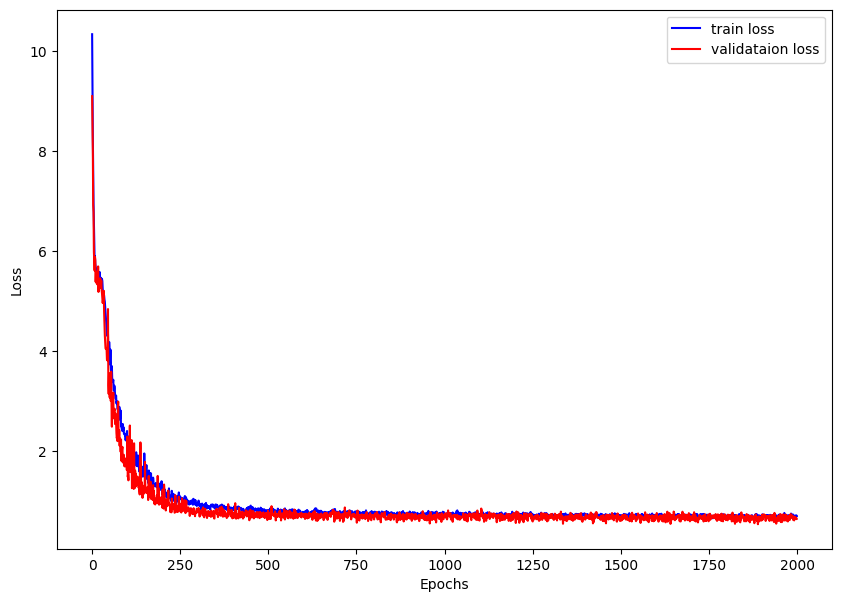

In [25]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [26]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [27]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [28]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [29]:
enc = tiktoken.encoding_for_model("gpt2")

In [30]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [31]:
generate_length = 128

In [32]:
sentences = [
    "Alice was a curious and imaginative young girl who lived in a quiet village."
]

In [33]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: Alice was a curious and imaginative young girl who lived in a quiet village.
GENERATED SENTENCE WITH TEMPERATURE 0.1
Alice was a curious and imaginative young girl who lived in a quiet village.  She  realized  that  the  chaotic  world  of  her  logic  and  taller . .  was  simply  a  manifestation  of  the  situation  spir aling  world  of  justice ,  her  innate  sense  of  the  situation  spir aling  as  a  sudden  comm otion  of  the  irrational  Kn ave  and  taller  and  a  sudden  comm otion  was  hastily  arranged .  was  hastily  arranged .  the  situation  spir aling  as  balls . . . .  and  taller  and  inner  turmoil .  the  situation  spir aling  as  mal lets  the  irrational  Kn ave .  was  hastily  arranged . ,  her  logic  and  reason  were  quickly  dismissed  by  her  logic  and  taller  and  declared  her  logic  and  reason  were  quickly  dismissed  by  the  Kn ave  and  reason  were  quickly  dismissed  by  her  innate  sense  of  the


GENERATED SENTENCE W